In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
class_names = ['freshapples','freshbanana','freshoranges','rottenapples','rottenbanana','rottenoranges']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
IMAGE_SIZE = (200,200)
class_names_label

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

In [3]:
def load_data():
    
    datasets= ['/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train',
                '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test']
    output = []
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train


100%|██████████| 1693/1693 [00:16<00:00, 100.55it/s]


Loading /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test


100%|██████████| 395/395 [00:03<00:00, 111.93it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 10901
Number of testing examples: 2698
Each image is of size: (200, 200)


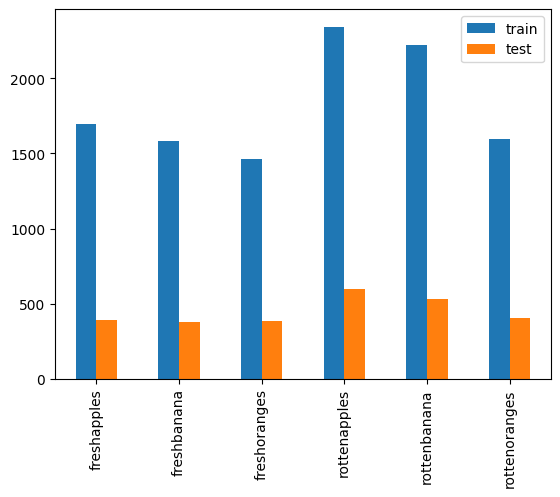

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

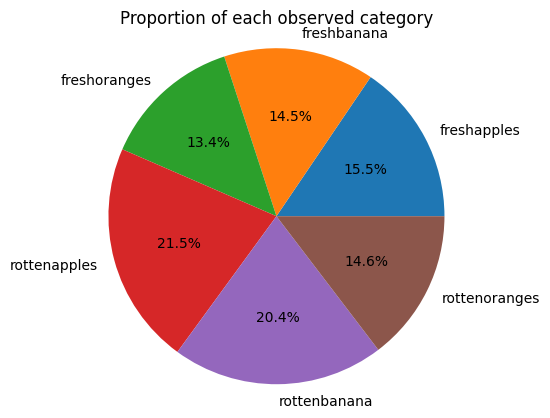

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

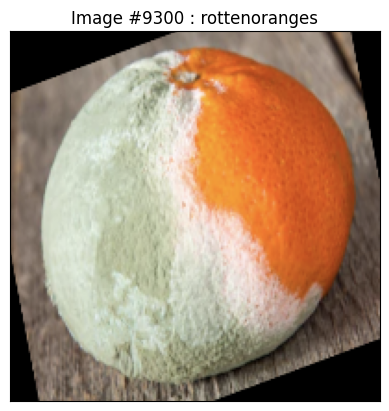

In [10]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()
display_random_image(class_names, train_images, train_labels)   
    

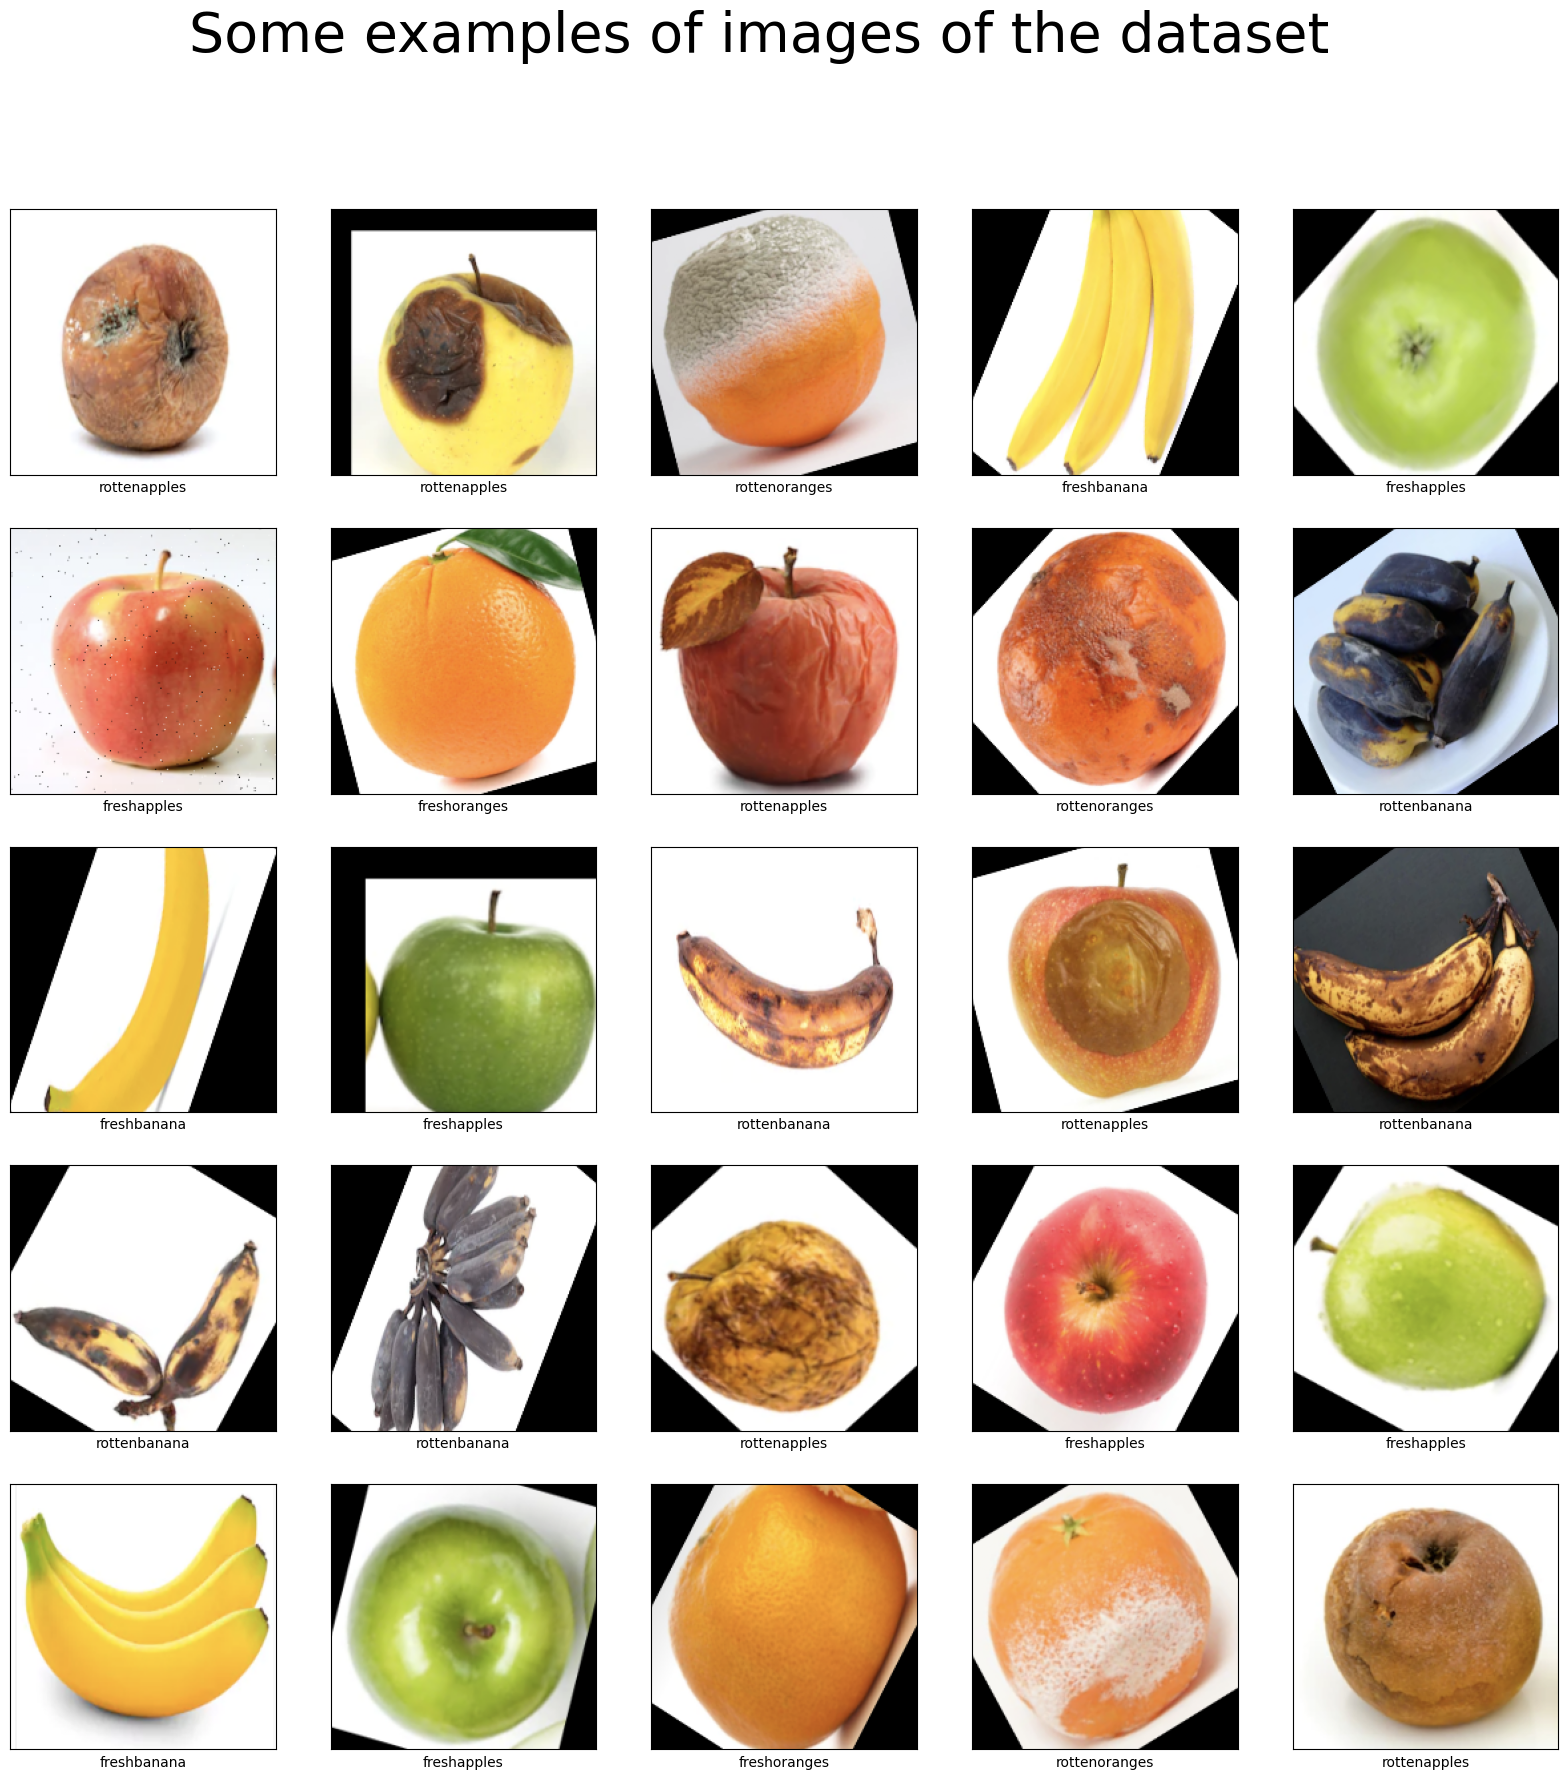

In [11]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(20,20))
    fig.suptitle("Some examples of images of the dataset", fontsize=40)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
display_examples(class_names, train_images, train_labels)    
    

In [12]:
train_dir="/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train"
train_datagen = ImageDataGenerator(
    rotation_range=20,
    rescale=1.0 / 255,         
    shear_range=0.1,           
    zoom_range=0.1,          
    horizontal_flip=True,     
    vertical_flip=True,       
    width_shift_range=0.2,    
    height_shift_range=0.15,   
    validation_split=0.2     
)

# Create the training data generator
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200,200),  
    batch_size=30,
    subset='training',      
    shuffle=True,
    seed=42
)

# Create the validation data generator
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200,200),  
    batch_size=30,
    subset='validation',   
    shuffle=False,           
    seed=42
)

Found 8723 images belonging to 6 classes.
Found 2178 images belonging to 6 classes.


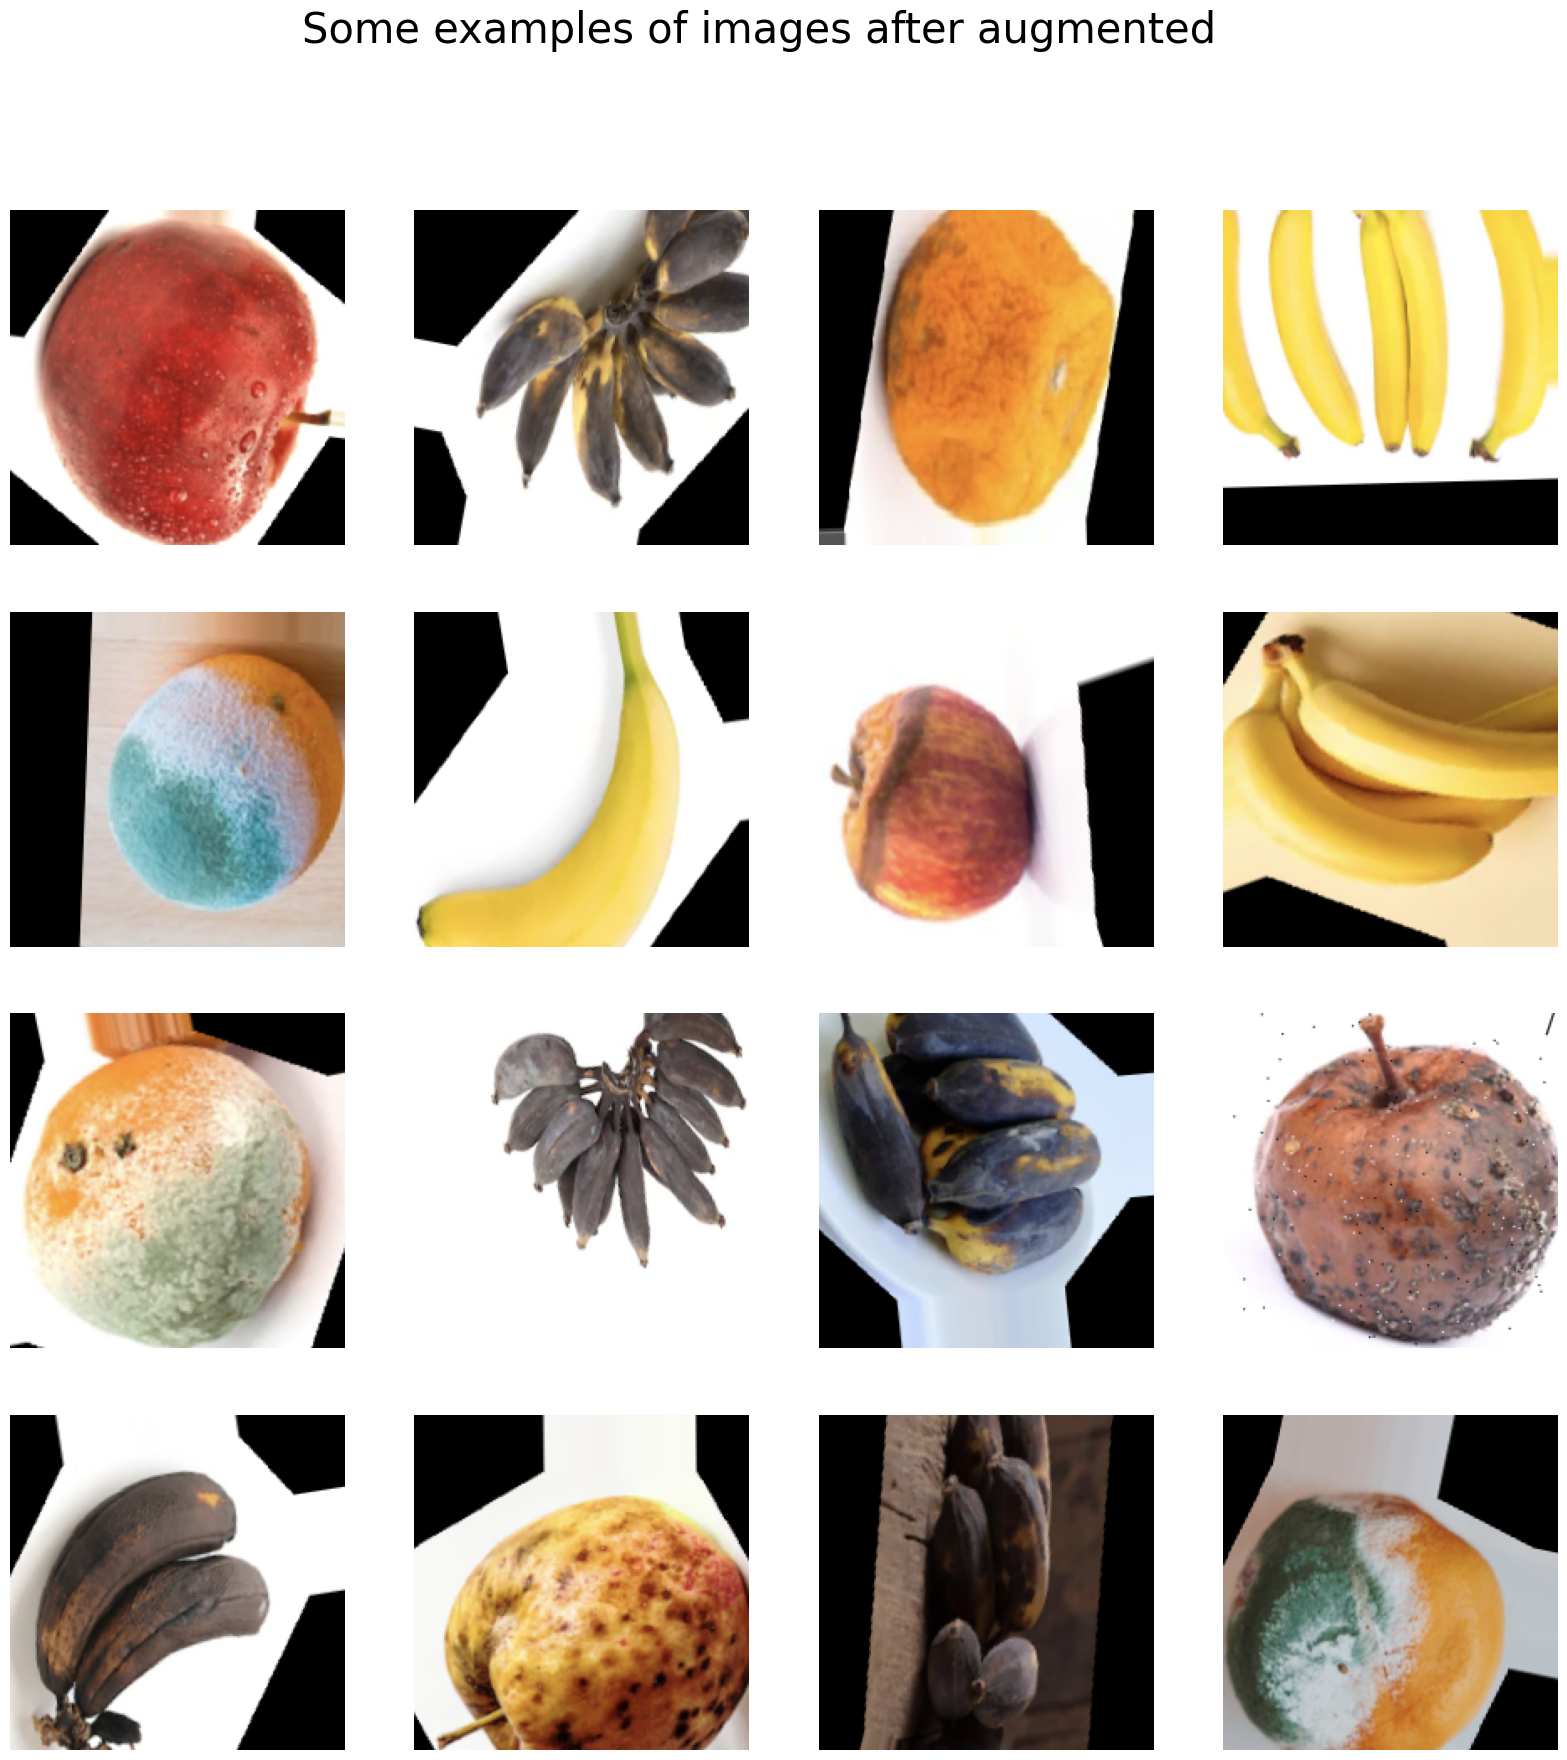

In [13]:
# Display a batch of augmented images
def display_augmented_images(generator):
    # Get a batch of images and labels
    images, labels = next(generator)

    # Plot the first 9 images in the batch
    fig=plt.figure(figsize=(20,20))
    fig.suptitle("Some examples of images after augmented", fontsize=30)

    for i in range(16):
        plt.subplot(4,4, i + 1)
        plt.imshow(images[i])
        plt.axis('off')

    plt.show()

display_augmented_images(train_gen)

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(200, 200, 3)
)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(6, activation='softmax', kernel_regularizer=l2(0.001))  
])

model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [23]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [25]:
epochs=25
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    validation_split = 0.2,
    callbacks=callbacks
)

Epoch 1/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 123s 415ms/step - accuracy: 0.9242 - loss: 0.6146 - val_accuracy: 0.7300 - val_loss: 1.0776 - learning_rate: 0.0010
Epoch 2/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 122s 411ms/step - accuracy: 0.9306 - loss: 0.4922 - val_accuracy: 0.8907 - val_loss: 0.5709 - learning_rate: 0.0010
Epoch 3/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 122s 412ms/step - accuracy: 0.9411 - loss: 0.3883 - val_accuracy: 0.9219 - val_loss: 0.3920 - learning_rate: 0.0010
Epoch 4/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 122s 412ms/step - accuracy: 0.9478 - loss: 0.3413 - val_accuracy: 0.9100 - val_loss: 0.4322 - learning_rate: 0.0010
Epoch 5/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 122s 411ms/step - accuracy: 0.9606 - loss: 0.2574 - val_accuracy: 0.9229 - val_loss: 0.3549 - learning_rate: 0.0010
Epoch 6/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 121s 409ms/step - accuracy: 0.9510 - loss: 0.2724 - val_accuracy: 0.8324 - val_loss: 0.6569 - learning_rate: 0.0010
Epoch 7/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 122s 411ms/step - accura

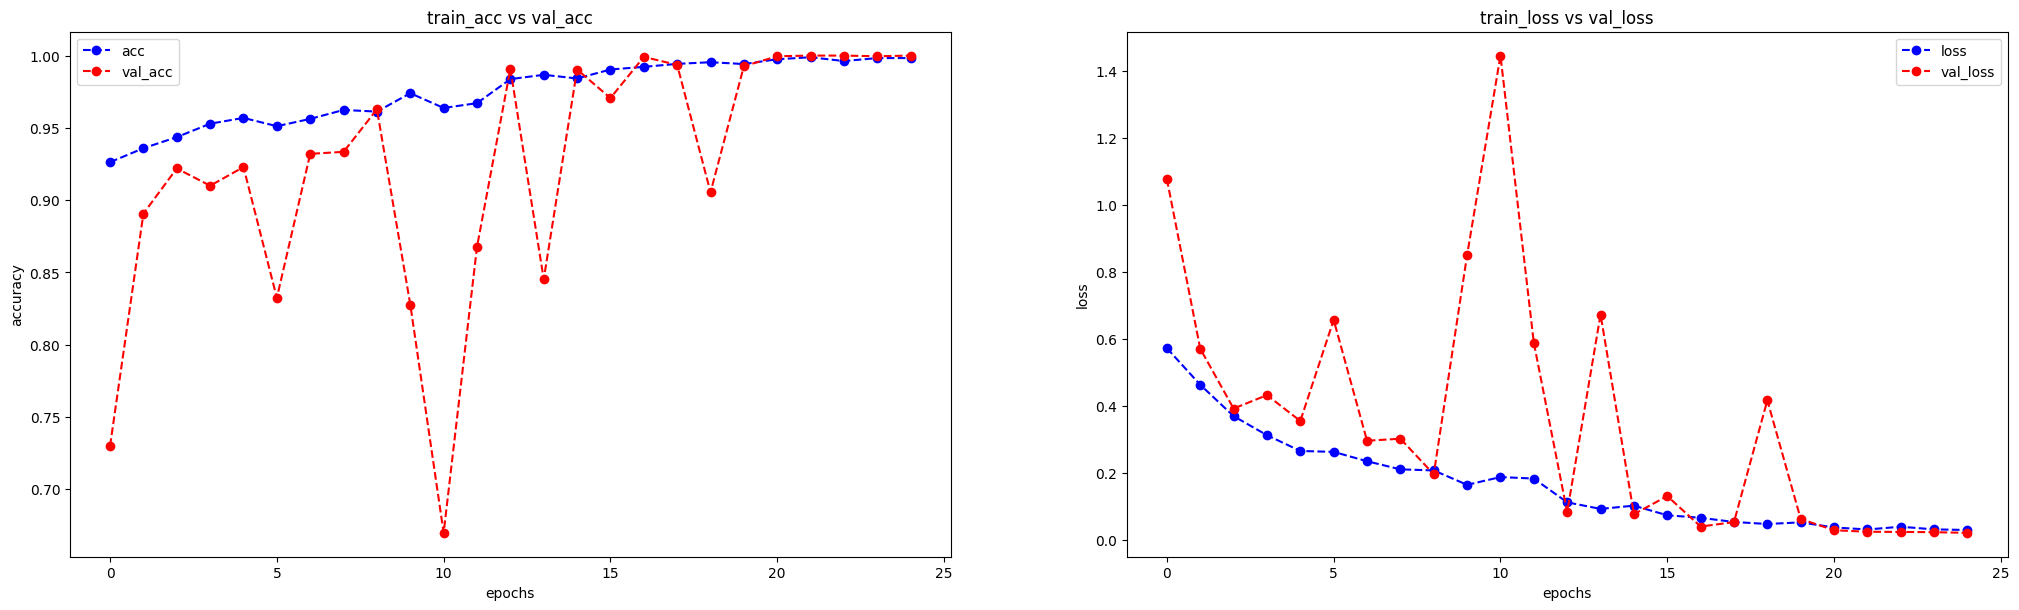

In [26]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(25,15))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
plot_accuracy_loss(history)
   
    

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step


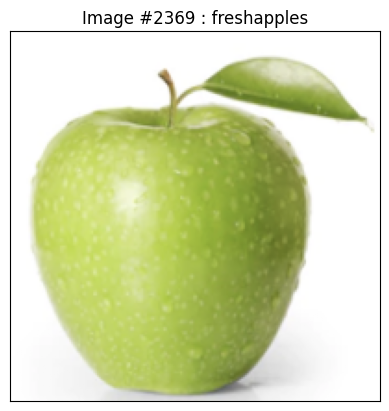

In [27]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [28]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

IndexError: index 3 is out of bounds for axis 0 with size 3

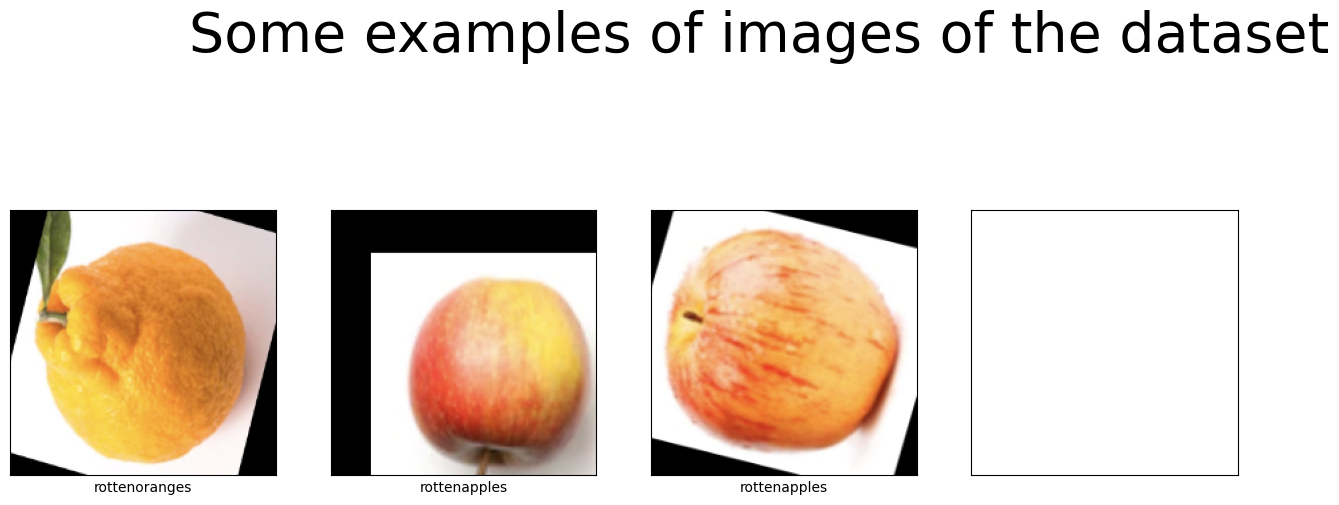

In [29]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


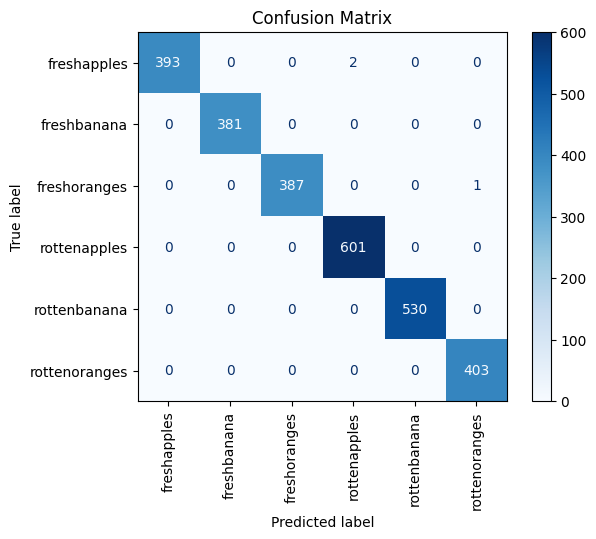


Classification Report:
               precision    recall  f1-score   support

  freshapples       1.00      0.99      1.00       395
  freshbanana       1.00      1.00      1.00       381
 freshoranges       1.00      1.00      1.00       388
 rottenapples       1.00      1.00      1.00       601
 rottenbanana       1.00      1.00      1.00       530
rottenoranges       1.00      1.00      1.00       403

     accuracy                           1.00      2698
    macro avg       1.00      1.00      1.00      2698
 weighted avg       1.00      1.00      1.00      2698



In [30]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
predictions = model.predict(test_images)     # Vector of probabilitie
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

# Confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, pred_labels, target_names=class_names))


In [60]:
import urllib.request
urllib.request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxASEhMTExEWFhUXFhYVGBgVGBgYGBgXFxgYGRcYFRUYHyogGBomGxcVIjEjJikrLi4uFx8zODMsNygtLi0BCgoKDg0OGhAQGi0lICUtLS0tNy8tLTgtLy4tLS0tLTUvLS0tLS01Ky0tNS0tLS0rLS0tLS0tLS0tLS0tLS0tLf/AABEIANQA7gMBIgACEQEDEQH/xAAcAAEAAQUBAQAAAAAAAAAAAAAABgEDBAUHAgj/xAA+EAABAwEGAwUFBgUEAwEAAAABAAIDEQQFEiExQQZRYRMicYGRMlKhscEHQmJy0fAUIzPh8VOCkqJDc4Mk/8QAGgEBAAMBAQEAAAAAAAAAAAAAAAIDBAUBBv/EACkRAAICAgICAAUFAQEAAAAAAAABAgMRIQQxEkEFEyIykRRCUWFxgRX/2gAMAwEAAhEDEQA/AO4oiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiKiAqitT2hjBVzgB1Kjl58Xxx+wMVdzl6N1PwVNt9df3MnCuU+kShFzS28ayYqYyK+7QADx1/wAKP3jxS95wttErnZ0EMsmLpmxwosv/AKEW9RZo/Rz9tHa0XzpYePb4ik7Bs75C5wa0SAPfVxo0NccyTUa1XfblkndBE6dmCYtHaNFKB29KbLdGXl0ZpR8TOREUiIREQBERAEREAREQBERAEREAREQBERAEREARUK01+8QR2fujvyHRtch1edh8SoTnGC8pPRKMXJ4RtbRaGMGJ7gB1UbvHiY1pEPM6+Q281F7db5Jn4nOxAeIp+UbeO6wbbegaSGHEfl4n6LiX/EZzfjVpHRq4aW5GdeNve/MvrXUnkNaeSil730D3YwXnTLSvUnfkRVVvLGW4pTT8GgNNyNSKb9VpW3oa9mxrTnmQKHL8Wyoqpcn5S2aniKwhDYpJnVlfhbSuFpp5Fb+7GxNaWxsDWjKtc60FTU6notA5tpzozX91PI8+akvA/D01pkoXHA2jnvGgr90E7kbUqFpnVKz6U/8AiIeUYbZtfs64dM1vlt0jP5cVGRE6GSlC5o/CMq83dF1sKxZLMyNjWMaGtaKABX12KoeEFH+DkWS8pNhERWEAiIgCIiAIiIAiIgKFQe7uOw63fw0hYGPJDHaFrwaCN3MnKminK439pfCssVqFsh9hxD6UybK0h2fQ6jwPRVzbWycEno7Ii03Cd/x26zMnbkT3Xt9149ofUdCFuVYmQawEREAREQBUqhUL4tvt0lYID3fZkeDqN2MPzPl4U33Rpj5SLK63Y8IyLy4oLyWWf2RkZTv/AOsbjr6c1FLY8Amp1NXOOZJPU6kqs9sayjQKk5NaN6D4Ac1jOshJxy0J5bDoP1K+bu5E75eU3r0jrVUxrWjy9sjsmVa30PPXZai/e3iLRCPzGlc/PUbqQ4wKEZV8/TkvMVnqcRFa55865EHbUqNc1F5wWvZC33VPJV0z3F555j4c/BZtihZQMDQK7gUJHXrVb21QYxhYNiK0zOYya3fPIKU8OcEgEST1ptFWtesh350W6pWX6RTOcKllmm4b4TklzBDYyTV5GdMqYBzGYzyXSrusEcDBHG0NaPiTqTzJWQxgAAAoBkANl6XXo48alrs5lt0rHvoIiK8pCIiAIiIAiIgCIiAIiIAsW8rEyaN8bhk4U8DsR1BWUi8azoJ4OMXTbZbovB7XNcYJDSRrc8Lv9Ro+PUOPILsdnma9rXscHNcAQRmCDoQVF+OrnbIxswHeYQCeh09DT1Wm4fvWaGrW0w1za7SvMclhfI+RLwn0a3X82PlHv2dFRaCzcRg+2ynUZ/Bbmz2ljxVrgf3uFprvrs+1meVco9ovKiLTcQ3t2LcLT33f9Rz/AEUrbI1xcpHkIuTwjX8U30c4IjmcnuGw91pGhUTnkDQGgVOw+pVbTaMNAM3OOQ5ncqkUJbmc3HdfMci+V8vKXXo69Varjg8RWYMq89558cugGyulpcNM/h5/vdXD8VjMlpUE0/f+FR2Woudi1oJ1PIK/YbLLaCGsa4HkQRQHd36FZNw3RLOcQ7rK5uI+Debvgp5YbGyJoawZc9z1J3K6PE4MrfqnpGa/kqGl2au4OHY7P3nEPk50o1vRjdvHVbxFVd6EIwWIo5kpOTywiIpkQiIgCIiAIiIAiIgCIiAIiIAiIgIr9o16Cz2SpObntAHMDvGnp8VDrBN20TZY3V1I5HmCt/8AazZe0igB0xuB82/2XM+Fr0FlnNncf5bj3TXIO3APUUXK59annHaN/G1HJOLutnaA1yIyLTq0jYrOjtD2HE1xBHL95rWW2zuNJYSA8ajZ7fdPI8ir9ltbZG1GWxByIO4IXF8pQeUbXFMkjeLmsicZGEuANMIriOw6Gqg14X+H1kc/vPcADrqaAfRbaeIOUY4kuGGYEhzmSVB7pycRs5v1C1fqHelGx6RXCqNeXFbNsGkkOrnWvly6LMEorTdRyC1SxnBJkctDUUWf/ENpr8dK/vRZpQaeC7Bn2i1AUGi2nDPD75z2kuUYOXN/gdmrE4SuI2qTtXj+S0/83ch0G/oumMaAAAKACgC6nC4Kf1zMXJ5Hj9ETzDC1gDWgADIAaBe1VF2sHOCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgNBxrY+1sx/C4O8swfga+S4Rf91Pc0Fgq6M/d1FKVr4inqvpK0RB7XNOjgR6rkt72d0TsVPZq14G4Ffln5Lm8xuuamjdxWpRcGabgy+8Q7J1chkTqR16jMFSp7ACXc9f7qDWyymKTt4ANCXNNd88TdlJbivpkwocnDUfUdFy+RWn9UembVldmzDqqxLFvt0+iynQVzbqjG7HIrBuL0TNa2EN9kA5mtdfHPVYdsuyKQU70bubT9DkpD2QVieygq+FyzkiyT3DxBZmxsiDDEGgNA9ptB1GfqFJIZmvFWuDhzBquWtjLdFl2e2PbmCWnmMl1K/iUlqSyY58RPaZ0pFDLNxJO3Uhw/EKH1C2cPE7fvxH/aQfgaLbDn0y94/wBM8uNYvRIUWqi4gs51cW/mafpksqO84HaSt9afNaI3Vy6kvyUuEl2jLReGStOhB8DVe1ZlEQiIvQEREAREQBERAEREAREQBERAUKjPFF2CvafdNA7odj56KTrxLGHAtIqCKEKm+pWwcWTrm4Syjk1suMDOPIDMDl0HT5KGXnY32Z4dm33XjRp9145fquuXjYDE4tObToeY8ea1Vsu5kgo6lNM9/HmuD5Sqk4yR1ozUllGguK/myANfRr6eTurDupI0hyi95cIMH9J+D8Ora8w3UeRVy73WuBoElJKEjKuKmxz1+aqsrjLcGTJK5pHVWg8b5KzYr0jlGRz0IOo8Qs4sBCySraPSyQCrToOSuizkHI5ciqPkLfaaR1GY+GajmSGiw6Jw8PorjR4r2HB1CDp+8wrtF58x+wYjpD8ljF7+Qoaa6jn5raNYArb4QVNWAwWvAz0oaE/osiO8Hgd2WQdA4/JV/h89slbNlp++asjc10zxxTMxl+WgaSu86E+lFUcXTtr3wac2j0FFrW2UnMjM/DosOexkO3z3122C0Q5c1+5kHTB+iQx8bzUJIjNK6hw+qyLLx5iArBXnhfn/AMSFFZLI4gluZqRQ8qqxBdTg6udNqfXmVcufYv3EXxa36Oh2bjSxkhr3GIn/AFB3f+bagedFIIJmvAcxwc06FpBB8CFyK0x4dQsS776kszjJA4tP3mVBY/8AM3QfmGa1UfE/LU1+Cizhe4s7YijHBfFYt4l/l9m6MtBGLFWoOYyFBkpOuunlZRgaaeGERF6eBERAEREAREQFi2WVsjS1wy+IPMdVEbzsUsBqe8z3+XiNipqvL2gihFR1WXk8WNy32XVXOt/0c8mtrQ3Kny+a1H8aO8OteXwUwvvhFrqvg7rtcJ0/28lDLRZnNJY9pBzHI/vqvnuRx7KXiXR1abYTWjDtjo5NqOGh0Pqsaz3tPCdcTeufof8AK9ssjq55t2O4pzVHxUNHD9fJVxljXZdhM3Fg4niccL+6eunrot3DO1wqCCPFc/tl3MIrTyz9eixWmSPOORwOu9KeIVvy4S60QcDproWnULybNycQoNFxPa46YmB7ee/jRTG57ZLaGY4mMlGWIRyDG2vvMeGkKP6Wb+3ZXKXj2XzC8b1+C8PaeSvPmkb7dmnb/wDMuH/SqsuvOL7zsP5gW/MBQlRNdxCmn7POLaiUVwW+D/UZ6hI7ax2be91aC71oofKf8HvkWS4DfVYtpvGFpwmVleRcAttFI12QY6v5HfKiqLnDs/4atecYHzCthx2/TPHYl7NDHbIxo9pHiMvBe5bY1oqXAA6b+lFJo7jflSBrfENAHokvB5kIxzYG+7GOlPaPnstEOBOb+1kHya17IVbG9o5oHeJNAK77Cmpr4breXd9njpW//pkMYI9iIDFn7zzX0AU2uq5LPZ/6bACdXHNx8z9FsKLqcf4fCvctmS3mSlqOiNcKcHx2BznRyOIc1rMOQHdJOI74s/BSZEXQSwZG8hERengREQBERAEREAREQBYN5XXFOKPbnsRkR5rOVFGUVJYayeptPKIHe3D8sNXNGJvMDMDq1aaaFrhp4FdVIWpvG4IpKuAwO5gZHxbuuRyPhf7qvwbquZ6mcs/g8BIFTvWuX9l5jhG/gpRedwzxVJFRzbmPPktOYdnN/fRcuUJweJrDN8bFJZTNJabM7bStB4HmNl5iYWESVMcjdHNJBH+4bLaTva0VrQdc/irb8DhQ0121r81OLkto9bT7N9c/G9pjAEzRO0ZYxRr/AD+64+illg4tsUtB2mBxywyjCfInunyK5vHFDlmKnSuVf1K8WmOSnsg09fMLVX8RtjqW/wDTPPiVy60dkbHG4VAaQdwAa+auMYBoAPBcRsV6zwuDopXtpq0HI+LTlTqt9YvtSfGQLTB3d3sNKeI0PwXSp5sJ9rDMlnEnHrZ1JFqLl4kslqAMUoJIrhJo7yG/ktutkZKSyjI008MIiKR4EREAREQBERAEREAREQBERAEREAREQBERAUIWtttyQSV7uEnduXqNFs0UJ1xmsSWSUZOLymQW9uD30PZ0Odf8hRW0cGvD8bZHMcDoNNa0I3XZFblha72mg+Kwz4CW63g0x5cupI4LxYyWPD96pw0ZWp8SNB4b0Wwua8DJE0uFCcqHcjl0XVbbw7BJtQ9PRayThfC3C1oIGnT1WO7i2qHj45/tGmHJg32QG2XcCcQoD8x1HJYNqjpQPALgMjTM+OxU7tNwkVyLfLLlqtJJcklO8PTw1y0KwYnD7kao2RfshdoGEA0c0tP/AIzSnLLn1Up4Z+0yWFwZaQ+SHTHSsrPH3x/28dFYmuCOSvfpnQnkeRHPxVp3CjACe0xChplkPitdPMVZC2qNmmdosdqZKxskbg5jhUOBqCFfXzy69LddbgbPPkTmx4qx3Ut50yqCDl0U54R+12G0PZDaouwkcQxrmnFE5xNAObKnnUdV26bo2xUkcq2l1ywdNREVxSEREAREQBERAEREAREQBERAEREAREQBERAFRVRAUVURAUIVp9lYdWj0V5F44p9o9Ta6NZJcVndXuUrStCdtF4NwxdVtkVEuLS+4omrZr2RG/uAbNamhr3ObQ1qKV+Kj9l+x+GOVkjbS44HBwDmA5jMVNeea6cishTCCxFYR47JPbZh3TZHxRMZJK6Z4rikfQFxJJqQMhrp0WYiKwgEREAREQBERAEREAREQBEWuva8uxMVWjC94aST7NaAd0VJqSBkMt6IDYoond3FDhFH2wbiMMUhfiADscMjwTkAHExOyHvCioOJpcVS2PD2r2loJx4RZhM1oHvE1pzQEtRRqLiOVwBEDT3JZP6raERiOgadKkyAZkUw9V4j4lcXaR4XNiw1c5tC8vDnPxCoaCwitNSBugJQiidp4oe6F0jGYcJg7tQZXY3w4sDCKOYWyFodXULYuv0UgpgrKC41fRraAHDWmbyHZCg0dyQG7RRc8VOoKRNJOY7+g7OeQtfl3ZAID3fxLZ3berpGOcYjia9rC1hDvbaxwNTTIB4r4HVAbVFH7xvVzLTgZLjLWlz4GhhODA7DT7xlc8NoAaYQ6o0K1MnEFpDW1fRwfNi7nZijHswtAmALwA8ijaOdTbRATZFD2XvaH4g2dgLmlzsWBnYFswZ2eItNHOZipjBzYToaK5JfzmugeJXOa5hL4qRl9BC+QEhoDi5xaKObRtAcs6oCWIogb8lMbAbQxkxeWhoMbo3uIY+geR/RY11HEUdlka0r6iviQ4y6dwGCWRwjbHiidHKGMjaHNNS8E+1UktNKA0QEtRYt2MlETBM7FJhGM5e1uO6AMtKgDRZSAIiIAiIgCIiAIiIAiIgCIiALy5oO2iIgKFg5D/CYByHoiIAI26UHonZt5DlptyVEQFSwcgmAch6KiICoYOQ5qtERAUwCtaCvOmaOaOQ1REAMbeQz1y18ULRrQVREBTsm09kegVcI5BEQHoKqIgCIiAIiIAiIgP//Z",'1.jpg')
urllib.request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAQEBAODxAQDw8PDw8OEBAPFRAPDQ4QFREWFhURFRUYHSggGBolGxUVITEhJSkrLi4uGB8zODMtNygtLisBCgoKDg0OGxAQGi0lHyUrLSsvNzIrLS0xLzItKy8tKzAwLS0tLS0rLS0tLTIwLSstLi0tLi0uLS0rLS0tLS0tLf/AABEIAOEA4QMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAABAgADBAUGB//EADsQAAEDAgQDBQcDAgUFAAAAAAEAAhEDIQQSMUEFUWEGEyJxgTJCkaGx0fAUYsEjUhWCkuHxFjNDcrL/xAAaAQEAAwEBAQAAAAAAAAAAAAAAAQIDBQQG/8QALREAAgEDAwIFAwQDAAAAAAAAAAECAwQREiExQVEFE2GB8CIysRQz0eEVccH/2gAMAwEAAhEDEQA/APflRGFIQARCkIwgIoijCgAURhSEJAomhSEAqiaFIQCKQnhSEAkKQmhSEAiCeEIQCoJ4QhAIgnhAhCBECmhCEAqCaEEAqCaEFIDmUUUQGqFITQpCAWEYRhGFBIIRhGEYQCwpCaEYQCwpCaFIQCwpCeFIQCQpCeFIQCQpCaFIQCQhCeFIQCQlhWQhCArIQIVhCUhAVkIEKwhLCASEITwgQhAiEJiEIUgCiaFEBqhSE0KQgBCMIwjCAEIwjCMKALCMIwiAgFhGE0IwpAkIwmhGEAkIQrIUhAVwpCshCEBXCEK2ECFAKoUhPCEISIQlIVhCUhAVkJSFYQgQgK4QITkIQhAhCWFYQlhSBYUTwogNUKQmhGEAsIwjCMIAQiAiAiAgAAjCaEQFIFhGEles1gl3oN1yamOqOMAtA9Wj7leO5vKdDaXPY9FG2nV3XB1qtVrfacB9Vn/xGnfWBvFlyM8k5jEEyNPgVXXexojO3rE6QuVPxio94RWPU98PD4LaTbOpW4rHstBEakkT8lk/6hgw5g8gST9F56txRtN3jPh32P8Ayqf1MvL9GAB4LgQCPM29FnG/u5vK/Bs7KhFb/k9l/jDIBgyfdFyE9Pi9AxLw0nZ1l5TD4mm4F4J7vLma6wDnTpfzNgs+GfmFWu9wZSYJMwAQNTf8stIeJXOrDijOVhRxzg7/AGg45WZVo4XB0hXrVwSHZh3VIA3c47ACTN/mFu7PcPrUKPd4iucTVNSpUdUIIAzuzZBJ0EwPoF5XhtJ782Kbmph4HdZrPNPYAjn7Udei0t7U1WkNBDspvmaTm8yLgr3Q8QjqcZpr8HldjJxzB5PZwgQsfD+L0a5ytdD4nKdT5c/qt5C6EZRksxeTxSi4vDRUQgQrCEpCkqVkIEJyECEBWQlhWEIQgKyEITkIQpAsKJoUQGuFITQjCkCwjCaEYQCwiAmARAQCgKnF4kUwN3OnKP5PRX1HBoLjoFwa1V1R063gC/oAFzvELz9PDEfufB6rWh5jy+EJWcXXcSZuJ39OXRAWsWw4aNIMO8769Fto0B4hBcDa3hBI1GbUwUzqBEmHHQAn+o5vTVfOeXKT1Pc6qqRWyONisRTbOjCNrz89F5ri2Je6zIeSQAJAfJMCCvWYmj71vCSNLtPXkuHjOHUqmYlpPNwhsHnKrTaU/qR64SWnY+ecd4qKdXu8grkD+rnc4tcYvkLSIvI30XD4hxerUvVqPy/2y7I0bDLpbnqvT9quEMqvL6dZve025W0W0xmquIkyQ4BotOc28RlcPs3wZtTHCjimZHNAcGS1zCBuXAxF9ZX1VJU9GY8Hz9WVTVifJnwGKrVmNms9zaQLhTD8oDQdA3MB5r2raNSphmUc1V7Htl2cQXufJGYmYN51tlEJuIcPxdVxGHrYanRexgB/q5n02uL3jNfwBpbMiDn9Vr7M4tlSpXw7sQcRUoAOpvDQzDtpkQGNaLkzN4v0UtlSzACu9gw9V9NlKg3xPYAwvv7IbtHO5MyNbbzwgMiAAXAOgciN436JOLUyK+FFMyS8E+AeFrAS4lpvEuHxXpq7yWwCYddxNi48p1I6ElcO/wAQlszrW05Sisnl6lAsu12UtMi95Xb4D2puKOJPQVDtynmseLwLSDbzuZPzXDq4IAmM0jSNvis7S6lTeUzWtbwqxwz6rrcXBuDsgQvJ9l+NZC3D1XAtPhYTq08j0/OcevIX01KrGpHUjgVaTpy0sqISkKwhKQtDMQhKQrISkIBIQhPCEIBYUTQogNkIgJ4RhSBMqMJ4RhAJCICcBZ8diRSbJ1Nm+apOahFylwiYxcnhHO4vir9206XJ6rNhSGiROY5gYFwLfPS3VUF0uLjGqspuI8QIJY9jg3UkCSfSy+LncyrXDqS9vTH9HejSUKagjoUgYJDSYDm3/bqDF/QfLd395lDmlrXyPC8HLAAkcmkkTCytxbckS4OLjB9lr5fcAm2hVdXiQuGj+oZ8DCXua4iLHQDyXShUgo89vn+/Qw8ubfBjxWFeym51TJ3jyfCCcrW7QZgH7rxnFeJ1azv0uFaS8NzVMtgJ6m24+IXquI1C8Gm81GHKA7fILkkX12uvMjjtKhLKbZIaRLQ1uZ06udqf+FlB09WdPHT19ToRhVcduTNQ7MAu/rk1PCQWsdNRxOrSY9n4LH2kwH6elNJlB8hrDTe1mZrW6U2kXLQJEG9zc6LrYPFYmu0va4UaROVpaJdUfOgn1v0hb+GdnmCoyo9z61QVDHeQ9tgDYHdbwrVYy3aS7GVWhBp692eFdwtlVjg/EuwuJr0qWemQX06NNpzZXRcEzZsnVe17J4LD0mVBg6dRrJAf3gdTfVeACHkuEwZNwvQGgMxaGjyAiLq3Cuax9/YNnERcDf4pLxKUtksHl/RxSznJTgN31ww1jDTlMZW3Ia2dQJ/JWjHVW2AOw8p6clhxbhmJaSQCQNpCwVsXrJNvJeBuVTPdnrjBRafQtxFTXfdcvGVef2smdjgTAgyD1PwXNxVXaJMEbqadNxe5tlNbFZrCZtG439Oq+j9m+KtrsyAlzmNBk7i2p53C+WUzMjb6Su12Rx7qVWRtYtJs5pN/zquxaTdOWOjOfd0lOGeqPqJCUhO0ggEXBAIPMFAhdg4pWQgQnIQhAVkIEKwhKQgFURhFAdCFIVkKZVJAkIwnyo5UAgC5PG7loNg3xec7fL5rswuBxp0OIN5cI/aABIHqud4pPTbs9dlHNVHMJvKZrSRl1d44DPaECZ6ixVeZIaxBkEh2xEiF8dB/Vud3S3wR+Jafec4AyGvAezTQt09VVXxLgC12akC3wtpiA69pE2CXE1XuuHZ3REE38rrh8Q4jUpxTpAmtUBEDQX1JtA0Xtg5SeF1+fP8AppGCM/aDiJo0wxr/ABVDLosBA0H5uVz+Ednn1nAVs1EFoqMa8ZTVbIvfQQZnlK6eA4WaeapiQK1R7gARLmsAOoJ3J6aBd6l4MwLnVHPphpILgWEkES4i7R0svbCUKccciU57qJYadOKQaGscWlpDQ2A0NEOj3SfSytojQEmG5na6OLRc+fhCpphjRAdmfFyAIba9/Oyu7rwirUc1lAES4SXvOhawRLjbyXn+qctv6M5NRW5dicdRwuHqVqrh3tZoFGm45i4ZuQubiZ0+a5BxxLA4Am1o1+Cw8RqivW70tyi7abTENYAA0R5I4ik9lEVo/pk5GwREgxcC+tlpUippRivtXxlYLRvJ7t/EWio51yQNQB7R0XIr0nw+51Av7J9VtpVwBI2brrJOsSsWIrEkjmb9VSm2tkaOKZU4MDKZzFjwSHAXD9w7+FgxFUyTM+S195T0qCWmxOhaeY8lynOEui8EgHmOa9v3pSZlGOluKNFCoMp53PyWjhboeDpJEHcGCQR6gLIBYed+q18Pb4wTAAuToAFqnuiJLZn1js/iBUoNI93w+mv8x6LoELz3Yp/gcwiDla/obmT8V6QhdmlLVBM4FWOmbRUQhCsISkLQzEISkKyECEBXCieFFAOnCMJ4UhSQJCMJoUhALC8pxdxNZ4I0MjrLoXroXmOOgCrB97LfSJJ+Wi5fi0HKj7nusHip7HHc5Z3ElaKjLmenzCoqO+HwXyenDwzvx9DHiAYJv8wFVw+g5pe6oAS46akAWHi+a1VHxceQvCzmq4iG308gt4vCwjTkvfU25chf4qhz3TJcZvqQJ891U+rFrDodFs4PgqdU1H1Gl1OmGySXNa0mTltqTAtylbUaLqSUUZ1KipxcmZcOTUcKbCM13Pd/42M3cY2HzsFTxbiXfVDAIosApUg8ZRl5xsruN8XpmkaVB1IZn5Q2hGUMB9ohoEH7rguqE6yT6QOgXtnSVFaIvOef4MKcnVeuSxjj+TZ+pgbH7LPisQ8sDBUcKYOYtmwOs/7LNVECfOcwv5Doqq+IPUagE6rOCaeUbNJ8lrsTaCbQDc3PoqXViZiPSxWcOgF9xNgfacb7DYKupVi09T5n+VooFSyrVmwaI+MqlrRJ/PzVLn+vomZ+dFqlgg0t0vtK6GBaJIc0w4saP9QJPwB+Kx0xoL2AJ6STb5rpYKkSRDteXwn6j0Upbmc2sHuex1YPcYETRb1sIXqSF5nscRncwatoUz0ymAD8G/VepIXat/20cG4/cZUQgQrCECFsYFRCUhWkJSEAkKJoUQk6kKQiooBIUhFRACF57tTT9l1xrf3RaL+sL0ULmdoaOaibTBgxrBsSvNdw10ZI9FrPTVTPLtGdhO4I8PIAgGPiLdVzqronnpfpb+F1MC0jMJggHT88lzsa2ZAHiGa3MW0+y+Zr0spSPoKT+po5mJqz+fkKqm+BGvzBd5I1xyIIOm09DyVLwALkZh5x+aLFRPTgWrUv9dwUx4wWUO4DTLe8gh0McXiC5zYu4bX2Cof+XiPssVYn62nXqV6qM3B5iZ1KUZrEkU0gABsAImyfvOZE76/VVt/y252PkFXUNtesXOX4q+MlsC1qpJgGwGx0681T3l5vp72g9FHDe3wE/VUu6T9SPPktUirRK1QWJJP/AM/NZnuNuptGpVzmnYZuc7lEUif2mZk2ELWOEUaYrfLQ+d72WmhGptAmd90lKnryHzPXotOGok213POJujKstgQCSYJ0i5I/5XdwGGi518IBGotBHoJPqubh6EvYIFgSeVyLfAR6rtYQxJkcxPOQZ+qvTW556r2PZdkqbYqOaBYMYT71pIB9It1XoCFyeyfD+4wzQSS6oXVXE+0c1xPouwuxSWII4VV5m8CEIEJ0CFoZlZCUhWEJSEBXCieFEB0EUFFUkKiiKAiWrTDmlp0cCEyikcHi+7dQxGV5BzGMwG5PhJH5qsPFcMW1Jb4TOYHYHX7/ABXsOMcO70B7QO9Zds6O/aVwMUO8Y15aWuAh7b5muFiPQriXFtpzH3R27e414l7M8zXvchrXTPsuDXDny1VGInVzQJiQLA6adCOS6VelB2B1ggw4aTI015clncwjM2NDBBaS0+gsfMRuudKPc6akjkvoGJa4uEX/ALmSND9wslRrJMuiwJDBLjPI7Lq1sPbNDSJiBYgHkTf0KrqYc2yEG0tDnA+ZZGiIvk47qLRo9pneSHeohI4H+4EciP5Nwt9Sg4AG9jJgNOXqYuldhovLcpvIMwTtfT1CvknBy6lHnB8rhVmkeYB/cdfRdVtC8AEHkQJI5wbfNI7DEe7mEn2ZA/07q6kQ0cz9K/cSP8yspUBu0kgRa5B5Ona2i2ig0SAw3FxJj/2yp+6ygaEg2JuR05q+oozM3DHWC3QNznMQOgWhsN9nQwPQSkc7qT5qp9RRr7FXDudOnUAk6HT5E/Zd3sxwoYhwDp7pmVz76jMSG+sD0Xl8DTdWe2lTGZz3AQNupOwsT6L6pwfCsw1FtFhmLudu90XcfzZdG0pOT1Pg5N7VUFpjydmQhmWP9QFP1C6hyDZKErL36nfIDQSgSqO8R7xAWyoqs6iA6YKKQFGVUkZFKCjKEhRQlFCSLncUwOcFzQM24/u/3XQQlVlFSWGTCTg8o8PiKVyHCIAEOkEHkD6fkKnEYRp8TTBI10JtfN917DiOBp1RJ8LtnDX1XlsbRfRkHxMkEObcevJcqvauO+MnYoXSntnDOW+gRIMHYEEh17gdfKVnIjaTEloJB5Gxsr6mJYbTe35KrLp/LbLmNpPY6ST6mOpTmHBpJ0Dicw5ZTNz5LO5gMkgNMG4hmm3Vbarx031vI2klZ6lXfUqNaLpMymlb9szBAt0lR5AkfW/ohUq2hZalVFJ9CdOS2pV/P4WSpVVNbEgbrn4nHgLWEJSJ2ijXVrjcrJ35e4NYC5x0A1VWFw1au6Gthu73WYPuei9JgcAyi2GCSfaefad9h0XQo2je7Obc3sY7R3Zt4DXGFaSRNV3tOGw/tHRdYdo+crhPCoeunFaVhHEm9byz1DO0I5rTT42DuvFOSZiNCVfJTSfQqfFAd1ezHjmvnlLHPbuuhheKE7qckYPdNxasbiF5fD46d1vpYpCDu9+ouT+oUQHsgVJSAoyoA8oyq5RlCSyUwKqlGUJLJSOcpKR6gGbE1V5fjVR0GF6asxczGYTMqyRpBpM+RcerYlriabi0+UgrmYLtfiaRy4ikKjP7qfhePQmD8QvpvEODB02XmeIdmgZsvLO3hL7lk98bl9Hg5zO1mFeP+6GHlUlh+ac8aou0qsPk4Ll47sv+1cPE9nY91eX/AB9Pu0epX1Tsmekr8Ypj32/ELlYvtDSGjweguuE/gsbJP8NjZawsqUepSV9V6JI11uNF5hoPmbI4dxJzG51vcfA6qmnhY2WulShelU4x4R5p1qk/uZ6XhnHJysqZWwIDhYHzGgXaNe0yIOi8O1q7PDuIQ3I4GG+9YwPJaqR5Zw7HadVlVOqKp1QESLyPQqnvT+XVzIvL1WXqouJ3TMYSgGzK2i0yno4UldHD4OFJVj4WV0qDiqqVBa6dJSVLM6ifukEB7qUZSAoygHlSUsqIB5RlIohJZKhShAuUADmql9JaAoUGTm1cLKw1+Hg7LvFqR1MJgtqPKV+Eg7LmYngQOy9y6gFS/DBRpJU2fOMR2bafdXOrdlxyX1F+DHJZ34AclGlFvNZ8rqdl+Uql3Zt4X1R3DhyVTuGjko0onzWfLv8Ap96ZvAnr6U7ho5JDw0ck0ojzGeEwvCXixJhbRwM9V67/AA8clqpYMRorJFHI8ZT4LC1U+FgbL1f6Ickf0fRSRk87TwEbLQzCLtjCojDIQcpmGV7KC3igmFFAYu5UW/ulEB1wUUqKsQMiEqIQDIoBFARxSgqtzrqByqSXAqSkBRlSBpUlLKEoQMUpUlCUACEpamJQlAVliU01aUCgKDSSGktBRAbv+XQkxmknosv5rQQ388ksNnVQCGkgaS1NIIBULRzUkGM0kDTWzK1DK1AYzTQyLUGDdK5o2QGfIgroRQF6iiisQQIhFRAFFBRQDOmCiiqXHRUUUkEUUUQgCBRUQAQUUQClBRRABKUVEApSlRRQSX4fT1VhUUVioEFFEApSlRRQSRRRRAf/2Q==",'2.jpg')
urllib.request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMWFRUXGBoXFRcWFxUVFxUYFxgYGBUYFRgYHSggGB0lGxcYITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGjUlICUtLS8tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIANwA5QMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAAAAQIDBAUGB//EAEEQAAEDAgMEBwYDBQcFAAAAAAEAAhEDIQQxQQUSUWEGInGBkaGxEzLB0eHwByNiQlJTcvEUM0OCkpOyFSSjwuL/xAAaAQACAwEBAAAAAAAAAAAAAAAAAwECBAUG/8QAKhEAAgIBBAEEAgEFAQAAAAAAAAECEQMEEiExQRMiUWEFMkIVUpGhsRT/2gAMAwEAAhEDEQA/APcCUgCWEqABCEIAEJJSoASEqEIAEISFACEoATXuDQXHIAk9y8fPSXGVq5qb9SnPu0w4saBMAQbZ696XkyqFWMhjc7PZELluiW33VD/Z6t3sYDvk9Z5lwIIjSM9V1Kunaso1TBI5KhSQIAlQhAAhCaUABKUBACVAAhCEACaU5EIAQBKhCABCEIAEIQgATSUpKQBAAAnIQgAQhNJQA5CQJUANewEEG4IgjiDmvIukWB/stfdIzEtk7w3RkWNOXOBmvX1idKthsxNOSPzKclhGfMc5hLyQvldoZCVceDzejtf2NSnXhrtywn3hOnMQT4L0Xo10lZjA7daWuaATcQQf3TnbW2oXg+0sHXo1S5zz1S4gOm5vbd0EL0f8KekjHu9ibb43qeRu0XE8wCY/RzVMe4vOKrg9OCVCE8QCEJsoAchCEACEIQAJsoSgIAVCEIAEJCgFACoQhAAkJSpIQAgCchCABCFz22eldKjLW/mO5e6O069yiUlHlloxcnSR0BKifWY33nNb2kD1Xlm1+mtV1i8if2WdUd5zXPYjbzpubm5zkdp0SvWXg24/x+SXfB7gdpUf4tP/AFt+aadqUf4rfFeGjbbozns07eKmo7bqx70KPW+h/wDS5f3HtX/WKH8Vnimv2zQ/it7pPovH27ccR1gD96FSU9r03QSXN8wfioeZ+EVf41rs6np3svC4xhe0ubWA6rwIa6Mg8Ejx9V5Hs7azsHWbushzH719CCJA7YBhei0sSHCx3hyN/vtXC9O8H+ax4Hvg8B12jjzHolLNc6aKvAoI9bo/iCHta5tGQ4A+99E49PT/AAR2bx+S8v6JbRIo7r88xPn3Zea0341smY+CVk1M4SaZdYcLS4/2eh0unLTZ1Eg8nD5KxS6aUj/hvHgvNWVpOasjENteez5KFq5g9NhPTKXS7DHMub2tn0laGH2vQf7tVved0+BheVe1nkp2BxyHjYeCfDUt9oo9HjfTPWw4HK6QleT08VUYbEjm0kLUwfSyvTIDuuODr+Yunxypi5aGf8XZ6KAlWDsvpVQq2J9m7g7Lud81ugppjlCUXUkKgpCUiCoJQEAJUACEIQAgSoQgAUdes1jS5xAaLklOe4AEkwBcngFwO3tsOxD91lqTTb9R4n5JOfNHFG2Mx43Ni9IOkT60spksp+bu3lyXE7WxO7b6rdxbYaeC47aTy50T8e5cnHllllukd3R4F4M3F1idQDxOQ7gkoNtJJcdJFipfYbxJiIHW+/JSGjlndb10dDakNpNkwDAHLOexWGgN0m/io3s3eXIWzRUeYjK9/gigXL4HVK5PVaL6JQWg9YydQLAKF9EMG9mSOOmkKu2sA2XC7vRQrsvtVcGpS2gGE2JGmviYt9FLiMRSrjdrNkCCLkEEAxBHIlYFGqSTBIBuRMSRopjiWtkGTxAjsV6+Rc9PFrlGlg8PQpuO6am6QGwXNcOIuROZPirJw9JzvefPCAs3daWiMo7+5QYqo0ERnrdDxxly0J/8eI3qjaQsQ+3EgD0TmYlrDZjB/NJWMytImSfS3Pn8EU61gCL6cp0UrFFeCFpca8HSUNqu4DuH3CvMxxOs+S53DPEeiv4OT2afBS4lJYYLwa5rE6KtUM81cwoMEZHUaFNdh3XLb8lG0oopdFEv3Tn4roNg9JX0iGzvM/dJ/wCJ0WHVboR80ynTIvomxtFMuOM1Uj1/A4xlVocwyNRqORVkBeY7C2u6i4EHtGhHNej4HFtqsD25HPkdQU04ubC8b+iwhCQlAkVCbKEAOQhV8dixTpuqOyaJQCVnM9NdrRGHYYJu8jhoPisTDYcRyCqYYmtVdVdcuM+OS13WC83rs7yZKOrHH6aUTn+kFaGnT7suMqukybCV0HSCoXGFiVIu3XIcvqtWmhUTtYVtgkRUh9bZp9TKcgrYoEDLs71AaJceWnNbkidyK5ebAkxNv6pKVLedEnKTqO9TPblbLxS0wGyY4+iktdcoobVrfs5xlwH3dU6lYE7pE2hp4Hir2IbM2z8lTNHLdGXmrRjwXjJDQC2xzFuN/ndSSCWmAeNrc5VRziTbL5J/td1XSGUSVqhEgC3DP+igrHeAc3v5HmOHNMdVJJgn74puFneIBzt/VQ18C8kW+jRoW4x93VhpPjpms4EATwP3981p7MbPWcOQ+ZVuheSShG2XcDhnHOwXWYTBNA5iBlmucZVWlg8UNURkcrNmnI36bQPVLWqiDPCVl1g4Q5pv2/cqHE1HGJBAJAtEGSLjUeAUt8WIWVVTNl2LpvAJvocvA8CLKuKQ/ZXB4badSli67KgkEydJvLSOBjxW9gdqg5FRjybkr7Kx3Qf0a2IokGQtzottg0ngOPVdZw9D3LHo4oPHNQvBa6eKYOlFZI0z2GU1YXRLaXtKe4T1m+n0W+ApORKLi6YAISoQVEcuT6e4r8tlIZuO8ewZT3nyXWrznpbX38W4ZhgDfn5ys+pntxs1aOG7KvrkZsmlZW9oPDWpcAyAqG261ivOR907OjCO/Kcnj6vWlUMO2XSdSreKuc4lV6VMzK7OGNI6r4RoUaIM8E32PBTUKdgrTd0mwWlGZyaZkHDqH2R0W8+l1TxVKtRCs0WWSznsSC0mR8jwVR5IMT6crFaWMpXus5+aB8HZnPtMcUlUSfPsUlcNuZvw+81VqO+/mpNDfArhH3CYXXlPdTj66KM8UMhdEvtCe9dBhiGgclz2H94cAtph15Ks2YdXK6RcbUulo4zrR6KnvXPD7lOpGDl8PFIcqMu2zpNmbRBbDjlx5KPaONEA093ea4OPAgTPkufc4hxIPGeEHgq1QQJJ+8/grepcGhGTErsqYrEl2LO+TDtQPAjxU+AA3nSPdOd9D8fksfHPBqNeDnY8jmFo7Pxb21N7P94cRrPgjG0oqyGmdvgatg5psrlSvIWfQ3C0OpusR2EToQkr1IatN0TgfupnS9FNp+zqtJ4wew2XqYK8Nw1QtIXsHRzGe1w7Hagbp7vpCtFmfX4qakjTQhCsc8F5PiKpfiHu4uJ87L1PFOhjjwaT5LyfDiHzOqwa9+xI6X49cyZ0LHw1cztjFyVb2lj4suaxtUuNr/0uuZp8dcs62lwV7mRVK0lLTKrB1/RWcO2V0os2SjRrYeBBVqRqAqVCqnkzeexMUjJOBNWfAnwVKq6bKOtVnNMDryrqRChRUxozssp1O/oTpxWzjHCFl1gLcVNjoJmbiKAGcHvz4XVJ1OLn77OK161Ldgx3afeay6065DJSmPVtEDnSf6wEgdEJHBJChstVE+E97tWszgsjCHrZd61WOjtVJM52p/cnYBefvgm1TYcpEeGXilpAz3fBMxhyEiRe33ySZMSuwkWjjHcVWIMkHT7KfQPldMbTL6m6055nQDUqia5ImjL2js/de/UDKLccvJWtn1OpDonjGdtVc2u1riQ3LJoMZkwFjYao9pc0ASDBmCJGivjk2hXHk63o7V95h0uOzX4LQebx2DzXMbKru3shwtkOzwWx7W+eoT1LigjH32bNVuX3kvRvw7rTSe3mCO/+i8/qNkLtfw9f1nt/T8Qnx7Kat3iZ3KEIVzkFfH/3VT+R3oV5VVsRyXrGJbLHDi0jyXlNbgsWsVpHT/Hdsy9pPJKz3EgAznPgc1pY4SZVKszJY4o7+N8FQyYnICArOHH1TI++CkoadqamMl1wWgIEpGu7ktS8c1HVaWm+eqncJqwptnmZUFaxPJT0nc72VauZJVlIFHkq4pxHeoqbxBspN2SU1zB9FKkMcSKt1rQOIWZWo3nNbL2W4WVB1ESrKQLgzKjDlGXBVd1bzaXL6KlXpwb+SspDIuyvgqeZm60KTetyTKdGFM1llSzk55XNsk3NJTW4QSXOKUXT7u6uiqxaZGcOALag/FJQf7Nm9GmmYGcq8aQ3d0RkVk7arNFgZYbSAbNyJIjQJM07UUEmmjn9rVXvJuRefD6gK23qDd117dVHsrCl9TefcNMkch7oPMmLLSDBvHitLlsW0Tjjb3EmzqECdT9haLdFBh2TA5q42LjkfRUTHM6OifyweQ9F1H4e1PziOLD8FyeBM0B4eBK6n8PR+eeTD8Fsj4MuX9JHoyEITTljQF5XtCnu1COBI8CQvVl510oobuIfaxM/6hPrKzalXE3aCVTaMCtTVOtTtMLQebKAskETz8lzjvQlRnbloFyhjT4KRrbhOqdmStY+whK8a8UgenPdkiyCHdgpHUplPcQM01lQSp3AUw2FFF1ZcLqN1IwTmBndWTLsGgxKqVGDgrJfZR1ArWVKrx3KGtRbui3WJz5K2WptSncI3EroqkZpVLUZdNAQmcmfY/emJzT6NPMqu9wiFWdjDu/5gO0K9fAq6LxqtaHve7dAEDt5eBPcuTbU9s+RMTMkyZm5BW1taj+Q41JacxbQgiSO1Zuy6e60c7qFSTku+iidtI2K1FrBuUh1Rrq46kqJlOVI10hLhyR3pV27ZoS4LFIwrJvMKKiJMqcOseJ4K6YGzso/kd5XZfhsz8yoeDY8SPkuL2V/dDvXe/hqzq1nc2j1JW3H4MuoVQkdsShNQnHLHrkOnmG9yp/lPqPU+C69ZfSLCe1oPaMwN5vaL+kqmSO6LQ3DPZNM8ycoTn3K0bqrWELkSPQ4pWV3MgqVzQbDzTZuE2qVQ09jSc00c/vgmh8FKRKsWGYhllVbSVqo4TmmF1irJE8EfszOagqSCrtHI2JA8uBTX04upSLbvBWn7smOarLaQTX01NgQBhAnu5prqalcE1rkNlW6TZXe26ieAFNOqY9sqy4OXLllNw5pdkY0Uao3wHMJvIB3eDh2KWo20Qs7F079iYuRUvspbXxT6ld4edcshu6eiG5J2NG+0OsHszOW8zWeYsonVIA0PkVZq1RSPD4L2FfHFaDGQFQwdUEc1fY9pGs5co+cpG3kenwWKdhzQ5yQOyVnCUZKt9FoK2bWzKfUA5etyvT+huB9nhh+olx9B5BcHsLCF7msGbiB8yvV6NMNaGjIAAdgW/EjDrp87UPQhCac4a54FiQCcr5pQFgbdj+1YUmMyJkAi7chF7wDPG0GJ6BAHnHSHZ3sa7gPdPWb2HTuKxK4XpXSfZ3taUgddlxzH7Q++C85qBczUw2yOxpM26JTc1V3ySrbhHeq1Zqy9HUhKys8mc1I10qB6cx47/JSP8FTGHQmOxS06Ra25Bk9UjztmpK1IOzTKeGjsH3ZT20zPkxOTtMloc81KVEQim+6s2aKHluqa8KUFMeI4dyrZBCWqvUCtkKGuJmBCmyMn6MqtPJIWpzQlIVvJziF4zWe9klXqqpvTIMVMpV2gdqZSxrg3dhkadUSMuHYFLXbKhZh5TuGuRcYScqQ/D1JWjR0MIw2BAWpQwtkuvg2LTy8lfDUCSJWvhqURCjpsW90e2W6tUawa5ngNSrwiWk44o2dZ0E2XANZ38rP/Y/DxXYKPD0WsaGNEBogKRboqlR57LkeSTkwQhCkWYO2XxisNzJH7fEC0dXW8zbhmN5Y21sODXoVOt+XMgU6jpnKHNs0gjXQlbKABcP0t2NuONVg6jjcfuuPwK7YptSiHNLXCQRBB4JeXGskaYzFkeOVo8frsVdy6bpHsN1AyL0z7p4fpcuaqNXInBxdM7unyqStFdwCqVFaeNVDUOneqJs3RkMD4z8kb9pUNR9ufwTmvG7CuNSAVL3y1hSaSqofClNURCksyyx8nPvTibKFhhSgyooqxXRoZUJCkY6OBTg6TfPRFEVxRRqMISArRxDQVWfRGiEYp4pLozq7VTqhbRwkpo2cMymRmL9CUjDp0iVoYXCclotwwGinZTTLNWPFHGiGlhxN8tVYdGg+icGaKTC4ZznANBJNrZlSiJSXbHYLCl7gGiSTp6L1bo3scYenB993vHhwaOxU+i3RwUAHvvUOQ0Z9ea6NbMWPbyzhavU+o9segSSglIAnGEchCEAYG393+0YWT1i+wkxAc2+7vAG51EZahoO+sPbVRgr4eRLnOAH5hbugEQ7d1ud3nvRrbcQAkJUIQAyrSDgWuAINiDcFcL0i6KOZL6MuZmW5ub2fvDzXepCl5MUZrkbiyyxu0eI1mlpuoHMByzXrm2OjVGvJjcf+83X+Yarhds9Da7JIbvjiy/iM1gnglHxaOtg1kJdumcnVpEXhQl4V5+Hc3quBtxsQqlbDngl0dCM2QugpKRvmmhhCN1FDk77JmvKmbVVZSsRRa0Tk6pYTGsJtPcrFOlGaKIc6AmPsqakLZd6jLLQntmFBWyZ5ECO9RA2zQGkqSjhyTAE9l/RSitpIhaLqf2eupWvgejWIqZUiBxd1R5rpdmdCQINd+9+llh3uNz3QnRxyl0jJm1eKHbOS2ZsmpXdu02k8ToO06L0PYHR6nhxPvVNXcOTeHatXDYZlNu6xoa0aAQpVsx4lE4+o1csvC4QJCUFIAmmQAE5CEACEIQBz23Xf9zhRIkvsIcCbyTvZRANs9MnFdCkISoAEEoTSgBQUqQJUACEIQBXxWEp1BFRjX/zNB9Vk1+iWEd/hbp/S5w+i3ClCq4p9ovHJKPTOTr9AMMcnVB3tPwVOp+G1I5VnD/KD8V3KFX0ofA1avMupHn5/DQaV/wDx/wD0psP+HFMe9WcexoHqSu6TJUejD4LPW53/AC/4c9huhOEbm1zv5nEf8YV6n0awgyoM75d6layFZY4LwKefK+5P/JRbsbDjKhS/22fJL/0jD/wKX+2z5K6hTtj8FfUl8lRuz6IypUx2MaPgp6bAMgB2WSp6lJIq232CEIUkAhIUNKAFQhCABCEjkABKRJKEAf/Z",'3.jpg')
urllib.request.urlretrieve("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQBlAei6ICf85QJzGSxEm1s5jH9fxy2FJhhCA&s","4.jpg")
urllib.request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMSEhUTExMWFhUXFxUYGBgYFhgXGBUXGBcWGBUZGBgYHyggGBolHRoWIjEhJSkrLi4uFx8zODMsNygtLisBCgoKDg0OGxAQGy0lHyYvLS8uLS0tMDUtLS0vLS0tLy0tLi0tKy0tLS01LS0vLS01LS0uLS0tLS0tNS0tLTUtLf/AABEIAOEA4QMBIgACEQEDEQH/xAAcAAEAAgMBAQEAAAAAAAAAAAAAAwQCBQYBBwj/xAA6EAABAwIDBgQFAwMCBwAAAAABAAIRAyEEMUEFElFhcYEikaHwBrHB0eETMkJSkvEzYhQVFiNDcoL/xAAaAQEAAwEBAQAAAAAAAAAAAAAAAwQFAgEG/8QAMREAAgEDAwEGBQMFAQAAAAAAAAECAwQREiExBRMiQVGR4TJhcYHwFKHRIzNCscEV/9oADAMBAAIRAxEAPwD7giIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCLwuA1UZriYvPQx55LxtIEqKu7FAQNTp7+aq1trNExfMcrZydAuJVYR5Z0oSfCNki1v/MyM2+ovzAEkheN2oZgsN8ouuf1FPzOuyl5GzRUm7SbqCOJiwVqlWa4SCD0XcakZcM5cWuUZoiLs5CIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiKGvimsiTcmANSeQ118l43gElR4aJJgBV8Xi9yIvJA6E5TwXO7Y29uAggyB/F9iS6Q3w/wC0Ak6ZDMlc1W22XGYg5tgkkOynOBA0i1o4qhcX8KbwXKNnOos+B2mM2lui4LYPiIt0DXP3Z7T3VBm1m3dTpEXsXOuTYkXNzylcS7EOJ8Ti6LCTOd9ZhZGrF+1ufsrHqdTm5bL89DTh06KW7OnftuoZH6bm/wAiQ5zr8zFh0hYt2q6LkRcRlE5mIMlc42ubDeMcNB2VpjpVKd7UznL/AD6FlWdNLGPz7mxOKMmCRP8AudPfeKDGOnMngZM+YVFruXvopg+8fZV/1E+Uzt0UvAu0toumSZ6k3VyltB0yInkYPzI+S0xdf/H0UrHKWneVIvkhnQi98HWYHbIyfyv9wtvSqBwkEEclw1GpHDpE8/cLYYDGOY6W5Tcfhblr1JvCn7mZWs1zE6xFXweKbUEjuFYW1GSksozmmnhhERdHgREQBERAEREAREQBERAEReOMCUBHXrhmZ4xzgSuExu3N+r/3C0Q1zQKbg4gPIaXfqZNMEZc8pVj4r246DTa8Cd5rgLgtMAQQOBPe2i4Cq+D1KyLy8xLTE1bO1ytUjY47aTnkk8gGgQ0AZADRV2n3z1VUukx3WeIqwPksOeZPL5NaCSWET1KwGvCOs/aVnR8WcwqdKjvQTxyV2k7hkopYS2JYsmayMirlEqnvK9hyAJIzyPMR8lXa1HcnhEggG19e/wBslMx0gERAzgcT6qs55genv3mp6X7XNvpvdjnC9S8ERSW2WTgCBN5vAGg4lSNIiMp0IkcuixpUwd2TaM+MXI8vkrLaWYOYtcZz753Uii3wivKSRECOEEaLNjyD38j1WRYP/bsbcOmSgqNjjz6pvA8TUja4HG7pBtnmunwmID2yO44FcKCAPea2eytoFjoz9Lfda1h1HRJQnwUrq1UlqjydcixpvBAIyKyX0qeTHCIiAIiIAiIgCIiAIiIAtF8V7RNOkWs/e62s7sEuiBnAN9JB4LeONlwHxTtSWeDwl7gS4TMROelv0+VjwVa6qqFNk9vTc5rY4vHY4ude0WAuIGggqrXrAiRorONa1xkCDeTJO8eJ3ibrWMpOdUDWxxPQZr59R1yN6U1GOfItNqi5vYDTLipaF/Ee30Wr/wCPA3wdHQYvMwNM81aLnuAhsDj+ErUNBHb1u1WUXzWhGVrzdRU8MWi5lSsABVNpeBeii02pKtUXkX5wFUClZU000KhaJS4Bl/Vby5q9QN7GOWtxl9Fr6VQyruGdD8ss5GR6LiPJHUWxLSHiy8JJgf0/jJbAOJdNt02+/wApVTCuAJg38Rg9de2p4rOnUG7BEXy1FoViD0op1NyzBFuMezFysHvaDETHEZ2usm1YMZwOQMjLPlC9cBu2zF5J93ySe62I1s9ymBxUrXX98V5iBJmZmOcW4rBqpZ0Swif4lk6rYOLtuHt5X+/mt0uJwFfdcDrx1suyoVQ5oI1X1/S7rtaWl8oxLyjonnzJERFqFMIiIAiIgCIiAIiICjtioRSIEyYaCMxvECRzXzbb1MGZcQd4jdtA3Q1tonwtjdubxlcld98TYgsYINz/AB43BJ7fjVfMdpfukGZznjkel5WR1GolsalhB8msxLQBmStfi8Q1jd5rt0wevPqrlVm8TwGqrPoA6WCzqNTRLJdrUu0WGR7IawtG7PF0iDJ6rdMcBotLs0xUubG3cZLcvChupOU9yW3pKnHCJSR2UX6U63Ue8pWvsq+Gi3E8aSDBspWvsoS+eqlpEQUOi5SmLX5KehUNyTfjE9uSqYasWmRnBtyIP5U+Gqi4IsRlPqPmoWketGyZULwTvAHsN7j3WVCuXW1OWWeXdU6FTdiCrTmmDIkTMsI17JGTZBKCWxbp4h0ERvGcxHHMc8kNS5kAWgDUHXuqkk5TA7W+6kHE73LSfnIXMqjZE4IlceQGS8lRtcO6kDrHjb8/RVp4Z1jBYpuldRsCrLS3gfmuTYVvfh+qN+OI9/JbPR6umql57FC+hmmzpERF9cYgREQBERAEREAREQHIfG7yLj+LAed3gGPr2XDU6P6lQNi0SSP6RH4E813nx1ZoOphvI33oPkuNpscyi51pqCI13N6x6EgjmsG9X9Z54W5t2bxRWOeDU1RAgZeyq2GZLD1KtYmCFBhxDTHGVl52ZfUdjW1KZBsttQq7zQdVXxDNFjh5Fo6LuXeidIsSkcPmsarvZWDX9lHgkRMsqD/VQFAYhMEqLtJ1+impO5ctbKlKnpu8lG0dF+hXi2h06a3Vhr4uCefLPX3mteH2jnb6qdlTOPdlDJBxNkzEOiJkeX5XoedTmqVN0j3ZTtd5qKTbInTXgWmmBFjMZLJqrsMclM0qGXkRuOCZq2uyKkVWXzMLVMCvYZ0OaRoR6FXLKWmcZfNFWusxa+R2wReBer7w+bCIiAIiIAiIgCIiA5X4+YTTZwBM8hGcLlNrsI8I/gxjY6ASROkk/wBy+i7aw+/T6EeR8J9DPZfP9rkmpUDs2m3EgSO8gjyWL1CGG35mvYzylHyyc9VB4KNjIBHvmrdVh49FXN8ysV+RrENUWUVKBpqrDmKEsK9i9sHqPXkQs8Lhi97WtBO8QIaJMax2Ue7biuo+EmBsvi5O6DwAiY6k+i8lNQWWeTk4xbRPifhGi0f6tTXRv2WrPw44/tqNibWM/hdntlpLAcgIk6haMEi2fv0Udas4y2WxWoVZyhnVuc/X2HVa6BHnHPhksa2zKrP4l2stBcPwuoc7w7u75Oz1y/CxpvM+FpB4gmfwjqpPD9yaNeeNzlGvgwQrFJb7E4BlQ7z23GZbwvmRnlmsKeBpZhneTe/W915Nx8CZXMcbo1jI4qVhhXcbsmoXy0AgwcxN+pVX9FzX7jhunnzyPRRzpskhWhNbMlpulWGFW6mzKYIDKpNhNgR5hWBg6Y/qsbyc4z04riVu8tZXqVZ3MHxn0KdNbHZ1Pee0cXD5mfQLF1KmMra5zHLny6qfAPDHAi8aZTz+antlGFRamsFSrU1ReDrgi1B2xbIecj5L1u1TwB9F9T/6dtxqMbsKnkbZFqztYZ25ibqSpj7bwyXsup26Tec4POxn5GwRVdnYg1G7x4n0VpW6VSNWCnHh7kck08MIiKQ8CIiAxqMDgQdV89+KsIWVif6hY9DcdYjzX0RaD4s2eHs3r2jITxv6+ip3tLXSeOUW7OroqLPifOX5+awe3zVhzYMHMWKxfBEi6+bcMo39RSe1QFmoVtyhqC6gTwSorHmun+HyBSYeJdfjDj+Fzbguh2G6abRq0mxyu45c7qTRri4/I4r7RR2haKlMgajVcw1mYMz1gd5XSbKr77RxGa0O0sIWVDP7SSQoK+9ONQo2zxOUGV/0SBvQY6W80rADhNsvksGsk6ypaYbYC5nKbearpZ2SLnHJnTfaJAGvlwGZUzXtAtcjl537FUsQ1wuaZA52HyCyp1bAWaOuvHkpIyx8XJw6ed0WxX3rx2v9L87q6/abd0Me0nwxMAxIuLrV0qnA6wsHvvJzJM98+i6hXlBPS+Th0Yye6J2HdMQCI6CFMyv1PW/Uce6qtdpGR8x2SmcwLgQZ7xInS4UabT2OpQT5LbjImDPaDxg6rAVtMxeOUqs6uZsD2PuVPTIIvY8fuFHNZfcPNOld4s/rWHr3Xhq5j8Ku5vn7uEL+NuyieTnQvAtPqHIm4EC62rf9NsibaZLnt64+hPmukoeGk0HLdGfRXLaClq+hXuFpSLPw+/wvHB0+Y/C2y1OwG2eRlvR5D8rbL63pWf0kM+X/AEyrj+4wiItAhCIiALGowOBBuCIKyRAfOviPY5pExJBuDE2GYPvQrncMCCZ4ifVfXsbg21GwRxg8Jsvnm2Nlmk4zE3ETBI0ImxB+yw7y0dN648G3Z3WtaZcmhqtj1UD1crs56SAcwqVSxWNKOGakHkjctz8PvltRmd2uA9D9PNaUlWtk1C2qOct8xb1AUlJ4khVjmDOx2Xiy0xmLc/VbfEYQVmQTGoOcLmS/ddMRYHmNSI0ifQrptmYgObwy7rmMFCs6cvhfBmV00lUjyc1iHFpc1uhIPPmfLJQfqmZOfH381f23gCyo54/a+Dxg6hUAyLa6nh2lVp5hLSX6bjKGr8+ZIy5InTO8TJuIHu6xfFhF5mZ0UTXeIZwOeQ7L2S072ZDtc+YPmvHvydad9icOgnXI/QrF3iB4nun7QDq4ZdlCSQey4yxGOeCbCPIdDsiY6LISJvBEg3zE2+nkjqwMb8dRnymLWXmJbDpzy+111JYWVweLd7khdnmsP1ODiJ5xZYO5GdT1+q8AuVEttj1R2LLK5b+6Tw5cwpHEEW99VXNVwBiCIy+3BR0nwP3Ry/K9lucaPEu4OgXvAixOYm/FdJjbNKg2PRaGB4F3CVlixvubTH8iPLX0V6NHRRwuZfiM2rU7Sp8kbPYVOKQ5yfPL0hbBYUqYaABkAAOyzX11vS7KlGHkkjJnLVJsIiKY5CIiAIiIAqu0MAys2HNB4GLjorSLxpNYZ6m08o+c7e2A+nO6DGe9Et07grksS0jMR9498F9xewGxyXJbe+DRUl1F264zIOR9nism66fnvQ9DWteoY2n6nzA1F6yrBBBIIM9CMipdtbMrYcxVY5vMixPUW8lqf+IWU6Mk8NG3GUZLK4O8FcVqbagPijdfNvGI+fh7AK7sbFbsZ2+S4DA7UNMm9jmOPDuF0bcXk9pkaEZc/qo7qDmtS5RXdLHc8GfQ6jW1acaH04FcfVp7ri0tJIJHWOa22xNrAiDl8vwtnjsA2s2x3XaOH1GoXDxcJNfEuSjTk7eTjLhnIMc4EmB5WHPtzWNC7oOuvYq/jMLUo2MxoYkHvoVVt+4NIgCeuU91UlFxWH6GlGaksr1Pa1YQQItEHUDKCfKy8u63XPSxKOAnW/GPVeNaQTPC3Qj8rzU/se4WNuTxgmRY91mB4ZzvHGLCO6hqAW3ZHWJkZ5AKam4Oa4ZOkHOBb/K8UU9hLjIaCLf5uJkdl7UAF5FotqRry/ysYJuLgZqcAEW7cfLmnC3OZN5Iadr6SrWEwP6jgBkb9Aq9PDlx3YNuF11uzsKKbL5kX/CkoUe0lvwQXNfs1s9zMMFFkA2ATYlEveap0s3rqfL5qriKn6pDGCSfTmujw1EMaGtyC2LCl+or6/8ACHHzft/Bj1p6IYfL/wBe5KiIvpCiEREAREQBERAEREASURAVsXdpBaCDmCJB6gr5D8a7Gbvk0qDaZ4skA/8Azl5L7NCwfRacwD2UFej2iwi3a3KoSzjP3PzDiMBiQbAFS7LxuJoO8VIuYY3gDcRq3n81+kKmzaRzY3+0Ku/YdA/+NvkFVdpLGHh/b3L76lTfg/VfwfJcLjYIcw2PKOxB15Lrdk7X3ov2+y6Sr8N0HAj9NsdI+S5bafwdWpnew532/wBJMOHIE2d6d1k3XS6kO/T/AGJo3dCutMtvqdRhsSx9p7FSVcKxwIIEZaLgqe1X03btVpa4HIgg+RzXQYT4gBESD6HyVWF04rTWiR1bKcd4cGGO2C4S5jt4cNfytbVw9RsbwIdnJHPic10rNqNtn0+atsxTXGBwXCpUJvuSwz1XNWC7yycQ+Iz8Q0znnP0V3ZmznVXEgEWNzYTHRdM+lSJALW9wOKsiuGruNtDPelsezvXpxGO5ylXYlUGd2ehEK/s3Y7v3VLDhr+Oi29bHNbYn8KtW2nnu3Ols144W0Hzn5HDuK844wWQ1jBYAfdVqlc1HblMSTroOZWVDZtWrd/gb6ntp3W8wmDZTENEceJ6lXLezrXPxLRD939F4FOdSFPxy/wBiHZuzxSGcuOZ+g5K8iL6KlShSgoQWEilKTk8sIiKQ5CIiAIiIAiIgCIiAIiIAiIgPCF5CyRAV6tAnUhc/tTYNZ87tU9CSuoRQ1aEaiwyelcTpPMT5btH4exAzYXD+5aSvgKjD+xzT0P1X2yELVQl0qDeU2atPrlSKxKCZ8NG069M8ffNXMP8AE9TWke0D6r7IaY4DyQUxwCgl0WDfK9Pckl1qnJb0V6+x8k/6iqH9uGe7ofxkrOB2liqjw04Wq1p1h747QPmvqkL2F1DolJc7+v8AJWn1SD+Gnj7nPYLYzTd/6hPPwj0v6rdYfCMYPC0DoPqpoXq0qNrRpfBFL7GZOrOfLCIisEYREQBERAEREAREQBERAEREAREQBERAEREAREQBERAEREAREQBERAEREAREQBERAEREAREQBERAEREAREQBERAEREAREQBERAEREAREQBERAEREAREQBERAEREB/9k=",'5.jpg')
urllib.request.urlretrieve("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQsmeuI2GWlrmzmc0O8iXrneFlqQ4kZewfbrA&s",'6.jpg')
urllib.request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxAQEBAPEA0PDxASEBAPDQ8PEA8PEA8PFREXFhYRFhUYHSggGBolHRUVITEhJSkrLi4uFx8zODMsNygtLisBCgoKDg0OGxAQGy0mIB8tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0rLS0tLS0tLS0tLS0tKy0tLS0tLS0tLf/AABEIAOEA4QMBEQACEQEDEQH/xAAbAAEAAgMBAQAAAAAAAAAAAAAABAUCAwYBB//EADoQAAIBAgQDBQUFBwUAAAAAAAABAgMRBAUSITFBUQYiMmFxE4GRscEjQlKh0QcUFUNy4fAlM1OCwv/EABsBAQADAQEBAQAAAAAAAAAAAAACAwQBBQYH/8QAMREBAAICAQMDAwEGBwEAAAAAAAECAxEEEiExBRNBIlFhgTJxobHB0RQjQkRy4fAV/9oADAMBAAIRAxEAPwD7gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPmnbf8AaRWwmKlhcNSoTdPTrqVXKUXJxTcFpas1fzKrXneoWVpEx3cXLtVm+JrUqjqzU4O9ONGE6dJ3tdNPinYz3yRHebLq0+NPueVZhDEU4zg+S1xfihJrws0YstMkbrO2e1ZrOpTC1EAAAAAAAAAAAAAAAAAAAAAAAAAAABzfb3OnhMHJ05aa1V+xotcYuXiqLzjG79bFOXJFe3zKdKdUvieEyvESX70qEmpNzhKUVPVG7a7u7atbpzPOycrFWeibd2ytN91g+0OMl3IU4tRfeUaVTa3K3IxW4/H82t/FPql0PYjOMSsZF1FKNGN41Uo+yj3uHi8SV78ieHPg4t46Z31dvKGSs3q+vn0LAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+dftaTqSwWHjByc6klJq/cjJW1O3v8AiYOVkrW2/tDTgjsypU4RioQioqCUElskklZfA+F5Nptfc/LbHaFZRqKVWrZbqSTa5tL/AD4Fl4mKV2haRzUa2l/egnvzs2hqZx7+xE6fQOz2P9pT0Sd5wS3f3o8n9D630fnTyMXTb9qv/tsefH0zuPErY9hQAAAAAAAAAAAAAAAAAAAAAAAAAABxWbVFVxEp8VHux9Ftf5/E+V5+fqvaf0elhr00iGqcbJnzWS3Vda5vJZXlKX4m5fF3N3JjUa+yN403doYOm6NZcm4S9Grr5EOJPVFqfq5EL3s5jHHRPytJdVzO8flzxOT7kePn9zlsfXXTuac1JJp3TV0foGPJXJWL1ntLzZiYnUsibgAAAAAAAAAAAAAAAAAAAAAAAAQM3xfs6bSffltHyXNmLnciMWPXzK7DTqt+IcuoW5HxnMy67PTrDHFXUH6PgeZi73hKYcz2eT0U3a/dPS5f7Ul69l/mGC9tRnT5td3ykt1+aMGDN7eSJciqLkMmoJPZpuLT4prkWcqPq7Oa06vK8do7svA+D/C/0PT9G9X/AMPPs5Z+mfH4/wCmfkYOr6q+V+mfcRMTG4ecHQAAAAAAAAAAAAAAAAAAAAAA116qhFyfBfm+hXkyRSs2n4SrWbTqHN4qo6jbbd3bhySfBfI+Yz5ZyXm9noUr0xqGiXE+Z5Vt5Jaa+GFWGxRW2pdUmEwippQX3XZei4G7Lk653Py78LulLZXMNo7ob00VaCjJzStfxr6lkX6q6n4SbYVeCfPgQmou8mxv8uT/AKH/AOT6n0H1P/bZZ/4z/Rh5OH/XH6rk+uYQAAAAAAAAAAAAAAAAAAAAADne1WYxpqMXK3B+sm7Jf51PK9QvuYpDVx6fKsVV2v5267czxbx2a48s09z5zkxq8tFfDKfAzw6raztP1Rqr3qQl4SptboU5I7oykTRXUQqsLSXxRo+BKhPhv6FUbidx8H4dNlmM9pHfxLxefmfoHpHqMcvF9X7VfP8Ad5WfD7dvwmHrqAAAAAAAAAAAAAAAAAAAAAHzXtQv3jMo03JqFC1VxXCU00o/CzZ43Jtq1p/R6GKNVhOxFSyUUuPHirLqeTPddVti90fP8qPrldVtqysr9DNWNykqMdVXckndatL96/sbMVZ1MEJGGqb+pVevYmE+NXyaKOlzTGrG6+ROLfDmmrRe29rO43p1Mw2IdOSknuuvNdC7h8q/Gyxkp8fxhDJji9dS6jC4iNSKlHg/in0Z+j8Xk05GOMlPEvIvSaTqW00IAAAAAAAAAAAAAAAAAAAAfNcVT/1DEVNV1wav4WpTPB5VvMfmXo44+mHmY0VqVZNr7PQ1Fd9py5apKK8V+F7J772MeOdx0rfC2oRW1uSsj53nTHXK2vhumjDEpwos8SjSqTeyhao+PCLu+Hlc9DizNskV+/ZzejCVdUU16nMldW0lK5w07pGK8alBucSGxHqU97lkWd22QiiMzImYHFSpSut0/FHr/c9H031K/DybjvWfMf2/KjNijJH5dDQrRmtUXdfLyP0Hj8nHyKRfHO4l5dqzWdS2F6IAAAAAAAAAAAAAAAAAAPnOMpezxuJbX+5VVn7pOx89y/25j8vTx96Q1YvKMPWlF1aEKkr3UpXbWxgjNfH2hbra2o01BRS2SSSXRI8TmUnfUnWUie55+3YQMbh1OMovhKMov0asaMV+m0T9ktKLKKlkovitn6o3civfaS8wtSzt14GG8bhCY+VjFmaUXridrPd1goW9C29J1uDbYihxtw9eVN3i/Vcn6m3hc/LxL9VJ7fMfEq8mOt47rrCY+E9vDLo/oz7rg+sYOVGt6t9p/o87JgtT9yWespAAAAAAAAAAAAAAAAADg+2tCUcRGql3b0pXXN3aa+B4nNr05f3t/HndGqjVUlGS3TSa9GePlrqWiFjB7GPLrXdKGakmePl11bhNrqwI1l3blMcvYYl/hqfaQ9fvL4/M9fH/AJuGJ+Y7JwtaFRSRjtXQnUMTbaXxKLU34RmEuFeL5ohXdZ8IzDdGpHqbKZqa0hMS97p21cFnO712Oexh/J3eKx2OPi+Jk3KXh8bKG19S6S/U9rieo5cMam3VH5Z74K2SoZur2lTkvNd5Hs09YpPmqieLPxKVSxtOXCS9+xsx87BfxKq2G9fMJCNkTtWAAAAAAAAAAAAAAo+1OGU6cZW4O31R5XqdPpi0NXGt3mHHYD7PVBvwyen+mTuvhdr3HjZp6oiW2IXNCdzDarrY423POzYPmFkTs9srqN1d8jH7dtdWuzqHm+WRxENN9Ml3qcvwy/Qu43InFbfx8kSoKEqlGXs6sXF8nykuqfM9C8VyR1UWR3WlOsmZJrpxs2Ig78pMdnHjqSX3mNVc0PEz/Ed6Ku6exxlT8R3phzUH75UvfW7dLIlvsdMM/wCIVF95W9DsTb7uTWFL2jzLE6Y+xlpTdpPZO/v957fpk0v2v5UX3HhK7GduXGrDCV5OcJz0U6k5XnCT4XfOLfwv0PpcV+iO/hiy0ie8eX0+Mk907rqjVW0WjcMz06AAAAAAAAAAAAi5nBSpTXldeqM/Kp14phZitq0S4XE0k27q/J+h8vbt2enEs6NbR4nZXST5dF9DNMbl1YwqFNvsNGiMZuo3u7RV+Xl7yOTH106IT2kJnk5Mc0l1jiMPCpHTOKkvP5p8iNMlqTusuxOlFjMtqUu9TvOHT78f1N+PPTJ2t2lOLRLRRxqJ2xO6SFiPMr9tzTyVcRQ0wdW5LpGUahyaj3Wc0F7hyVZm+Uuu6b1yj7NucUn3ZS5XXM9Dg8v2LePKrJTbT2Z7MzeJVepL7KnJzjDa7q32V+i4/A9H1P1OtMHRXzb+SiuP6tvomGxUqb2e3OL4M8Lg+q5uNbtO6/ZLJhrdd4TFxqK64rxRfFH3vE5mPlY4vR52THNJ1KQalYAAAAAAAAAAQMzqWiV3Sq5HE8W0fOczH023D0cVtw1R4eXxs+hgt94WvXUfJ+8z2Sa6VaqpvVKLg33beL0Odcad1CyjUTKMnTaCGtSkpXburbIxXrWI1HlJub1KylZ8na5TGqz3gU+Ky1ydprv/APPBKMX5Sjf8z0a56a3Sf0n+hEyq69CpSdpq3R8n6Murat43CyJewkzkw62xIS4zUGzkzDjfCg2R25tJhhhFJlyZY1IK6hrUHLq97c2kaIrXFXqmN6Q7ytcNCMIqMElFcF9fU8nNktktNreXdabdRVoV+b5m8NBV4bzhOGmN2tackpQ87q/5PkfR+g2vXJ28KM9YtDquz+cU8bQjiKalGLcouMrXUouzWzafqj7ettxt5lq9M6WRJEAAAAAAAAAQMzp3iV3hKsuQxkWrnncjF1101Y7alBp4qzd+D2kv85ngX+iZiW2O8JKVldbxtsynLXUbjwRLCy1arK9redjFa+vCUQ2U9t1sUWsnpu9oVTG3XjkNDfRr8mQtT7OabatKE4uMopxfIhW1qTuHHIZvlWJoNzozVWlx0zXfh71xR7PH5GHNHTeNT+PBuUTLe0FObcXp1Rdp6d7PzLs/CtWNx4kreJXVHMaXX8mZIw2ie8Oztsnm0f5cHJ+eyLemsR3RmJQMxx+LnFRpulQurSm05Tj/AEp7e82YfYrHVeNq56p7Q2UY+bb6tts8/JbczK+I1CdSqSXBszTWJHtXF1U01NKCT1pxu30s+XM7XHjmNa7/AAhZxPaPOKmIadOb9je0XKnKN57XcU1eSab34H1npfG9qmreWTJeZfW/2fZVUwuBpwqpxqVG606fKk5pdz4JN+bZ71I1DBedy6QkiAAAAAAAAAMKsbqxyYIcrnOEtd2MuSq+lnHZjJxdzy+VxYy948teO+vLHL84089S5x+p400vjnUtPa0dl5TlCqtUJLzXRlGTDW3eDcx5Y7riY745r5Tidmsr6UnqqDQzUzmnUeti6sZwakvZpS1xteTfKz5FuOmOazEx3nwrshR7WU3JwdGb4p+Fq3nc9jF6RqItvyo934clVpU/3tSowSpWezsnS1J3jtx3jE9Hkbrg6bz3/m5j733C9w1K/wCp4l501rGlKEOHefkWYOJkyzu3aFV7xCbGEaitOnGS84p29Oh79MOOK9OmSZne2SwUF4dUfK7l89zLn9NxZJ3XsnXPaPLfSwif37f9f7mX/wCLv/X/AAS/xP4XeAyWhNJyqSk+m0TXh9CwxO7Wmf4KMnKv8QtqOTYeLjJUIOUd4SklJxfVX4Hs4OJiwxqkMtstreZTzUrAAAAAAAAAAABCx+FU0yu9dpVnTis4y177GDJWYaqW24rMcsnGWqm9L6cmZskVvGrQuruO8I2FzipRl3r0314xZgycT5qvjJHy6rL+0VKokqlovrxi/wBDFfFaPMO6+y1VOM1qi1Z807oyThifCXVMMHh2U2xWhKLQx9myExKW4acTQlKLUXZ9S7BXdu6FnzrFqqq04aJa9du7HaVt23c+1xdM0ifjTBaZiW7AUHFyvdOUtTSlfcy5+nJP7luPdV1hm9t38zPXHSs9oTm0y7Ts9ho1Laoo9DDEW8s2SdOrjk9K3hsbIw1Z/clpq5JF8CM4HYytP8EOezo9xLwuXaSyuPSM32soqyLYVvToAAAAAAAAAAAABExeCjNPYrvSJTrbTlM3yPi0jDlwNFMjkcwyjinExTW1ZaYmJcxishlCTlSqTg3xit4v3PYl11tGrwanzEsMLmONw76+cW1f1W6Kr8TDfxLsZLR5XeF7a1uFTDKXmpaWZ7enfayXufhYrtWpcMPP3yiVT6ZHzLvuNdXPq09oUowXneT+hZThUp5cm0yhxwlWo+8278uCNsRqNQrS6WRy2ej3kumTqhOw+VSuu6znty51w7Ps/hHC2xvwU0zZLbdKjczPQAAAAAAAAAAAAAAAAAAAwqUlLZo5MbdidKjH5LGfBGa+CJW1yac9jezr6GS/GlfXLCmxORPnEonFMLIvEocsgT5fkSisu9UJGG7MN8LEuiZc64XuB7JPnYnXjTKFs2l9g+z0IckaqceIUWy7Tv4ZDoWe1CHXJHLYrkPag65SqVBR4FsViEJnbaScAAAAAAAAAAAAAAAAAAAAAAMZQTOaEergoS5IhOOJSi0wjvKYdCHswl7ks4ZbFHYxQ5N0unSsWRXSMy2EnAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB//2Q==","7.jpg")
urllib.request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMWFRUXGBcXGBcYGBgXFxcYGhUXFxcXGhcaHSggGBolHRgVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGy0lHyUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAOYA2wMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAFBgMEAAECBwj/xAA+EAABAwMCBAQDBQcCBgMAAAABAAIRAwQhEjEFQVFhBiJxgRMykaGxwdHwFCMzQlJi4QdyFUOCkqLxNFNj/8QAGgEAAgMBAQAAAAAAAAAAAAAAAgMBBAUABv/EACsRAAICAQQBAwEJAQAAAAAAAAABAhEDBBIhMUETIlEFFDIzQmGBkbHRI//aAAwDAQACEQMRAD8ARqdwVZp1p3VbQsKwmkzYL4gqRtJDmPIVqlddUDiSWfhqN1JSMrArpCcV4IW21FMWrk0EVkFiiQVNoUVlw+o4+RpPXoPU8kyWHhio753ADt+ZH4JOTNCHbJUWxfbTMqUsCebbwtR5gu93fn+CI0+DUmERTaPZVH9RxrpM7Z+p5k3h7n4axzvQEro+Hrg7UH/QfmvXKdlAx9gUotkp/UZ+Ig3H5PHjwWu3Bovn/bP3KOpbVGTrY9sby0j8F7JUtgoBbA8sLl9Sl5iStrPHxB6KQNXqN1wiiR5qbD/0t/JCa/hig/ZhYerDH2GR9ibH6hB9ponbfQhglTN7phufB9Ruab2vHQ+U/iPuQXiFtUpfxKbm9yMH0cMFWseaE/usiiL4i7bUVNmVtr9TtA91Zx43N0BOairLzMgn6Kd14KVOYElcUKUktHZUuLUDMcth6rUx4lBUihKbkzu24kHtc0/M7ZdWXgd9XLnTKgsbI0zLt0y2dSoY0uKZua6B22Cq/wDpu8fKVun/AKbujJMp74ZQrTL3SEVR+pIHaj59JWgFvStwsU1jWlZ8NbC7aosk5DSF22sQpGFEOG8IdXOIawbvPLsB/MeyGU1FXI7a30V7MuqODWtLnHkB9vYJv4V4bz+88x/pB8o9TzRXg3B2U26GCBzP8zj1c7mewwEy2lpgACOyydRrHJ7cYylBclOy4cGgQ0Y2HIdgOSJsszghWra06q61iXh0csvMyrk1HwQUbZSGgDyWXN02nuQhVXxAJgNcRzIG3scrRWnxQjVFe5S5DLaY6LWkSgdbirnfKYAiepJOAJ2P3Kg/xIWODXEiZg+R2BiXBp1NHt1RuMK6J2SGp1EFRPtgqZ4rpp6yMiRAyDAmfRBj4xaR5QwmYLSS0juDEEJM8eKXaJUZhitSnACnoWYA2Q1nEZ01GxBBMcwOuETF7iS09jj88pcNLjvkOUpVSMr2wIgQqNxZgjSQCDuDkEeiLUarXCRErdSiChz6G/dDsGGVx4YgcW8JU3SaX7t3QZYfb+X2+iUrfhrqNQiqC12/Y9IPML2apajogfGOEte3S9s5kHmDHI8k3SazJpZVm5j8+QppZVS7EylpYJ5lCbuvqeIRutwh7Xwct5Ec/VccR4LDdbc/gvS48kckVOLtMpuLi6Zu04aHEOqOx0TNw9tBkaSJSO0kRJOOSsawRLSQ4KWSj0ovESFQdcFQeG7o1KQkydkUNEdFKYLs8EaxdFiKUPDtydmQO5AVtnhWudywe5P4LI2s1uRcc1chNjPBrj81WPRv5lSO8K0WAanvcSdpAHcmBt7qJLZFyl0SotgngHBzVIe6RT+10b+g7p+sbMQAAAB2gDsFHY2+AABAENA2jH69kfsrflyCwtTqJZHwO4hE7t7ciMSjVCkAFFa0R/hXA1WdHpvzSM7Nlvg2GrivUgH0Kir3bcic9gT9yC3t7BPn0nEek8wfdaMpKPCFRg2RuqOc7V5Y3EGXSMn2iB9Sqrnw/Q0tMjn7SCPdT0Wh4aWwAcxzE7/Q/eqz2hs6B5swOcwYBnOUEeuRxbfYOLAAN8zAIGM++w+qDW/AtLiXjmABsHY3PZAG2lzWqhrq9VlufM+Hua6od9DGzDRjLo7ZOxm+uKdH4TGs06naW5JOcFxc7JzA35o5RVIlWX+KVS6noYYl51Ef06CD65j6IFacJpUA6rWcGsBkknqYEnmSSAGt6wirn6Q4nnLo77O+6fdR/tdGPj1y1lOk7ya3bH5Q+P6jqIEZEwDKTGPvphXSJ7O7Lhr0VKbQfKHgMLgAMhky0dnAFQXvECRqLTAMGSTH6z9Eaq1AfK0AukAjAAGMnfbePZBq17TDnMjW9sBwJhpxMjlOUe1WCEOCF72B/wApMkZMxyP/AL3TJw681tMxIMEjY9/dJFbiWuA1uhs+bzcuriIkRy2U1hxFzwwio5jKkfDYwAuqAkgOJM/ytLsbCM7wXK6BlGx9hQXFAEQUI4XxhsAatQ6g6voRuEdY8OEgyDzQZMcckaFcxYvXVsHSA3ZD6PlOl2QU01qXRBeI2kZVTSZ56KdP7r7/ANHySzKvPgDX3B2P+QweiGN8OmcuR01WgZMHp3UdMajvheqhKM47ovgovdF0yxwO2FIaZlGgVVsmhW1DOF6lS/X3LZrAIdUvnbE7fr6KpWu+6oWbigX691zVG1ku1HJPX7vTb6qOm4uyUTtKWQFj6/Pb2rpDEqCNhbo3aW4VS0oYCM29KFR0uJ5J21wUtRlJWMVa/qODTH2clPcVQ0Sfp1QQ3hqai106dwD12jqN89lsz9kaRUgrdgo31QfMHCMwBLecDG/IzlAbrxa0O+G+kRMwQ4kkxJaJgT0E5hNldoc2HNieYgfXv3wlLj/hFtdpa2oWmZa4jUWkZE/1Nn/2l40r9xYNWHGGug06hgkxMB7TzBB37jIKNUbs1dxFVnT5XtOxbOR6HY9QQSEr8NFEAM0NMDBcJLo80PPzGQof2pzKzROnXEHcNfHMTlpjOU3a4uvB3DGihZh2omQdMdR/jf0QbxHw97g15d/CDdIn/wDRsxntMdiu7nilZg/+PLoMRUhjj0lzJaCZyrtK5a5jHEFpe1pLCZLS5uWu5SDImeSN/IBriDgABjnP2T9qUf8AUe8e6hQ0hvwKpl+P5g4uY0cgIa+cZj1Ryteark0cHSzUe2rTpHqc/RB7e2dU+A2dTLWq2oZmHBpqlgkGNUvmex95x0p2wmuDfDeKVv2bzh4q0XNbqcCHPpu+XVOXOEETzEIFxziR+M+oCA0OaSP6nAAAdzI+1Nniji7BTlvmc6IB5OBO3WAfuVbhPhVlQUa1ZznODA5jD5WNJORkZqSdzsR7qYJOTk+iG6QPfwmrdENbULGO0sfk898DfEYlPlpwQUralQLjV0s+EHuhrvhgAFo0gQ2AGyckAic5H21m6nULZwPMBzG4g/QH3Rn9u8kHzEAw0GI7l2zfXfsVDn4IasqF1CnUpUC8Cq7V8Ns9AXEAHJEdew3TNwx8DSd5mPUA7dJlJA4G41PimtSB1a3NAd5Ty01HGTGOQmOSZmy34bjLXE6QXEEugFwJPXDt+qU+HaIkk0MBQ++pOPy+6t21QPaHc9lzdUi5pAwlanHvg6Fwe2Qi+I+Ga2kSQTs4ciNj6bg+qRqfFK9u4tknsV6rxG3xG5Xn/HeDuqVmFvM6XewwfoCPZH9H1TX/ABn+w/U490d6O7XxjVjDFYHjKr0H1Riy8OU20yI80JOveHOa9w6FegTRRphXi9ctAd3g+6HW90ajwwbn7BzP0W+M15pvHYx68lH4Ktj8M13DNTDP9gOT7kfRo6rIzT2QcjfsZ6TRgcsfYEX4ezIKEW7ZI7T/AITBw9mMLzeV2RN0gvYwfZFGt5qnYgK3UfAWvocajjtmTmdyB3FPMRg4OR1GD9EMqAMJqNIIHztbvoP8wHIjp2KuudqJzJkzmDHY+n4oe8ROogDmeR7ADO3SU67YSVI5urYyHseBO+TB6EQIlVtTy8AtmeYiPXsht/ZPB+Jbn/syR/a5h/iM7bjl1VB/iWqDodbvNToJh3doIn25KdiYaYZvrD4jSx9P4jTno8d/bqEu8Y4TWbTmk/U+l5mSAH4yAQcOdvg/NtHItfCr9t1R+JRLmlp0VKZH7ym4btOcGMgnqtufvMls/wBMn0Od/REouLO3Wed8G8ZOrPFO6PmjBLAyDtsAAR0x1Ra+4uGTDXAtLdJ0lwOZLsYgfrKpePuFMq0zUaQypTMsJgE9WGeR37EdJS5a8Ve2jL67RiPLvOMOk49pmFY9KMuY/wAEbq7CLeKmneElw85p6hqBIgc4OME4OdlZoX4bS0sOSCPYERPTEIP4Y4gRUqGsy3ramgtApsc4/wAsAlsho3ONzKl4tXFsHVagpMqP8zKFOSG4ABcYEAR7lFLFzSOUrQVpzb/Dcf3lxW8o/pogiTAOcCJPMkbSjXDKV7Qd+6eajXEkg6NLnE/MQ/5R/tPJK3guwe6bqsC9z/l1P0saN+WT6DCbqty6Dqc0CIifIOpgHP8AhLye10gu0MNKg4Nl5BeR5nTlxO4A/HkArVG0bIJDRHKdvoMJYtbl7ml8l4Aw4ktgeg+uUMv/ABExrvhPeS476XOBYCMHmQ7n9FX2tkD5ccPp1AWw5h6gmD6yumWjQQXuLnNnTmSCRkhuw/ykbhfD6jhNLiN1pOfNUYTvsDGr2Cs3FetVa4U6hZSoguuKpDviO3hlMHLtjLjjbdTKK8M5L5PReHVR8uoasmAR+pRB2y8v8Dmp8RtaoHAlx06p/hlulpg7eaT6EFen6lEeE0xWSNMF31LmSlLiPkcHd05X7yMgSlfjQkbLJi/Tz2i5h90aZx/xAU2l5OIwki84qXPc7qVc43TeYbJAzI7qO14dR0DUfNzXscU1kgpGZOLhJxAdeq6q9tJpy86Z6dT7CT7JwpMa1rWtw1oDQOjQAB9iUvCFm5zn3DgQA0hnfVgu+mB6psLxOP0F57Wz5UTdjzyXrTcJh4fG0HIS5akSmSzEiJWLk7IydDBZtELq4ZI7KKz2HNWahW7p+cZky4kCKtu5mQB6k7ZmFA19PcuaSOrgQFDfPc93mJAyMcuQEfrcodQDw2SNpA9Ad+2V0Y88DfHJZrhnc88YP4H2UNWYkDH9xcD2xH3qVwJZMHqDPfEjYYWqUVqeo7jEkbEYOJ29Ue35JsSPEnCaFR5rVHXFDyhjqlIsLCBMF2kFw3iSBiEBvnWlATb165wGwys8NPfynzOPruvTjRhznF2pvJjWA56hzRPsdkmVuB2jAahoOZUqPNTS50ua4uLgAGPLW88DYDKt458U2C1Z5zeX1yajnPa6mGscQHh3m2Ay7LjkH2Qi7oVmBr6jXAPyCecdhsn6/efhPeQKbJLdRAcXOAkNc47CIMD6oPxRn7VRYKcCC4t1mCdIGqIBB3iMK7jnHwivOL+SDwZcPY5paBlx1POSAADBEfLj0kp2ocFbdOFX9ic5z4h1SGtLckO8zgM74BPZLfgbw/WqVS8j4dvTDmu+JBL5iWgDBzz25ZT/AMR422mXMYQ54jJ2Yen+FX1E9suBuJWgP4p8O3DKYqOr0abKbcUhqaJjysY7+Ynb5Ql6wLy9rGy+oSAA6Q1pdtjmU4cK4i59akHDW1zoft5WlrgHH/q0+xKaeI8Doamva0TTMscfmaYIiRktIOx7HdV1JNchttC/f2bqFpceeaopmqXHALmDURB5RK8mo1WFxc6pqeTJOZJPdesePK9RtleRJIZEf2vcWuPsHfYk/wAGeFGfBZc1iA90OYHfytM6XBoyXGAZ5AhOxqKxuTAbe6gnwO3uRTdUYwk02khjvK50CSGiCS4CTBieSavDnHW1WtaXUw4sDXsJgA4BAJw7c4H0UPD6ZpyQfJgtc7y+pzyRIvpvIq6Wl7N3MpjUBG5dEx3VCU4sdyEb2q2jSe8wXafK0Zz1JGw/ymPhlz8Wkx8RqAMfrdKFlbzU+I1zzgAZOk5OrHMmY9k60Ww1o7Cfoog+xeTojuQISxxgSDITPdNkQlji7IbCzdT+Ih+mBNxaNqvY0QC6Y/7Zg/T7VWfwCqDEKrb1jTqMfMgFriOwcJhOP/H6H9Y+xej0E7x18FfVQqVnnnBGn4FOcl7S4k/3S4T6As+iuOqCAZXVVkYGANvSMfdC4HXBxELCyvdJs1YqlResquU1WBBAnbqk62Odk1cOcDp/NUMqpkZOhmtYjHJTPVSyIBwSrdVbWlkpQMmaqQtcVuxrazT53dATERLnR0kLiw4oGQzTqjE85+i1x+iQ/UCBO7jyBHWcDf7EIuK4ogVazgWkwxjBOoYzMgAA45z1Xe5SHJJoOXPGKQBB1ewby25qk27DsFpp0+QIAL/SDIHfH4rXD/ENvWOhr9DomAQSOWWnzN+hHdWBaa3AiT0Okyfb8TATWyKKdWvWIIYDoyGsY3Lh3cdhn7Up3/CbxtZtydL/AIbh+5btBkFuRnBOU+Xj2UBDn6CdwJc8+sQAlq84rra9tIYglznGGtxu52w+1EntOXPRS8Q37ar22tq1usgufVLQ4UgIBcwH/mQYb0BJSTxqqy2LLeiNTmAtLiQT5naiOmtxifQL0Pg1lSl7mN0aw0zmahA0tcZMNEQg3EKVJ1R5FNj61MlrSYByBkn6ge/VPhmSdeCHAT+IcTuAxlL4z6bNWkaQweaZnUBqPPn1XdS/rU2U2VhByZkEvjBcSDvkTPVR37Ws+G6s79/UOptIgDQyIDn/ANJOYb3ThZWLK9AB9Fr2uIa4QD1BId8zYgZBBTMjVJSBjx0ReH69KtTgHS+Mnl/u7FN/B76dNGsf3gw15yyo2cBxGA7bf1HQeZmyPC7zS/WaLgDSec/MNnEABxaZBA5QYynZtB9SmKlFzHtdnYOB9Dsq+SG18dDE00EPENEaSHAGdTXNJEOYdp6jJ+qBC6eXhtMa3nkMADqdoC1S4gwOcyq12qYcxwkEbAtnbqFc4aKFMvcxplw0nVqyAZECTifSVXkr7CSopXvC7x5BcA/MABwAb6AxHruivAba5oHUQ3OMu1fYM/cr1HiwnyyI5R98bLi9vrrUBTa3TAc5+lxIbJH1wh2o6xgt6h1SRiQfLhue3XBn1CYmCAknhFSr+0sAfrpuy4EbY8pHTMCO6dGnfmphxYnKV7x+MJW4w09T7/rCYbwn2Stxevkz3WXkluy8lrTqkLlY8vT7zP67IHUbDnDo533lGa1U4+n0n80LrWFRziQCQTIXofprq7E6tWkFC4k9+Q9NlGXkZ3/D9YUX7R+KxwIHWc+36Cx2jTZboVSCJkeqY+EXCVhVjB7Irw+tBEH1VTNEirQ8WNQ9ZRcHCWeH1QYJKYrZwIEGVZ0E/wArM3URp2QXtu17SCN0uXfDhWlr6eBIG7Yb3MxymU2uahPGiQzfB39loZFS3C8cvAv2vDaFHy0mhoEFz/uifndvkqK+vakmnR1AfzEZd6l367IrRAI5GekOgnY5XF1diiA1zxq/lDhLnew6Yycd0GN7uWMYj8Us3hpqVSWt2a3LnvPIBoy5xUfD+BV6ppNrOIpB2p1IRp5kNe4fxHEgAjYbDqWGlWdUqPbLjoOmpUdsXj5gwQBAIPYRzV+tooU6lYuHlaIMSNRdgSfQE+qem+kjnwV6NYMNRwIwDLiJknYDpmIS1wO1vGg0q1NrmjeuYB7Sf5iJwIlGbcNqtDqbtTNeqY8rnaSAJjIBJPspHXbviNosAexpOp5BcGkZMTgHEep+oY7ppksCGrS4g2pbV6AY4SCQTqpuAkPbqaC09ufNRWFwbOu600wC3XSdBJLR5Tk/MQRJ9Va4LXpCtXqES99V7XEGQNLgxonlESR19Aq/i2g+5DW0XindW7mvpyABU8h1Na44EklpnBLIPZ0e9jfH9AP5QwOsm3FN1Ov52uAnG2RDhGxG88oSS/hFawuXi2qvb1EBzHGM6qZGknYhwA9ubj4Y4h8Wkx1VjqNYeV9JzXNIcDBif5TMg94RC+dTfVex0fEw4Zhx8oExuR6SEvfPHcSaT5EJlldXFRtSveZA0gfApiOf8unn6q9aWd78QU6nyf8A2BkNifmmSCe2+U207VrsEA9zjHXG6pu1MrfC/wCW4amzvEx9QfvCXLM33/QSVHNr4daKhrNuKoYRpghpDy3d2w0jf6bqUTqEuJBOn4jXSOg1CZA/UrL6jUqW5YwwQXb7nEH8o7qDwhwaqHHUT5oxmGgGSekntkKU9yOv5HTg3DBSzueqJ1IAXVNgAVO7M84CRnmoREr3MoX1bufwSfxOtJOUd4pcwCJSrdPBKzdOt07ZowjUSrWfJPfknvwzRH7NSkAmDy/uKQKn3fmnDhV+WUabejRz7L0Wj4sq6nlIQ7d0gHkQCrDqkZQvhL/3YaTJaS0942Pvg+6uPOFnzhUmjQ7R0KsxOFdtq8EQUNqOyF3TdCROFnDtwm7GRn0HMpo4fX9pXnVhWzIOe/VNvDb8kAGMb9fXuqX4crQrNDchtpPndRXluHtLTzVe1rZ3RCQtbBmWSPJmSTixJe4W9QsdMEfNzAPQrujYPDdOol7TpLtRJeN2OJnBg590zcQsGVRkZGxhUzRLDOOQMfkmbVEYp2L9bWXOpuJbIcZxqgzBzg5z7JMo2Fzd1XMqvc20pPcGU8NDnMhr3dX+YECcACYnf0TiXDySHtOdo6icZ+qHcPsXNeQ/7Pdx+kD6ollcE68k7UzDafui1mA1sADGwgR+fZd29iKbKbB33GdUAHPIb4Vv4zW6i75RmTnAaD+vVZXDK1GPNTY9pjSdL9Lt9LhlpI6ZUY5rydJM82/07mpRfUcMvruecYcH0w4x2+Iz7CE2cO4G12qpUOSXaPRzg4/bMe/VV+E8LFJzWUxNEUxTkHLXMc6A8f3NJ83UHqiNOo79pfT1loFJj9PbVVB98NlFknuk5EpMrXQY3yglrx/DJ5kcjJP0Vy04xb3LWtqgNfgAubIJO0OiJ7YMobfUnPYWmQ8mWE9Sdp5Yn9BS8FtW1Wk1GAvE6pGYBLSD/VtOeqW5BVwH2UA0wXYyNTsemTkrX7LTdDnFhLSdPvvB6FROpHBBBAxmZG0eyv2LXPIhuOZ5eo6FBKLZF0ZwyznJG2IHXmjlKgG7BboUQ0QPVd1HwE1LZHkrylufBDdVcQEFu7gtBk/RW7q4aOs9eSWOK3ix9Rkc5lvBj4KHE7mSZKDVnKxXqNM6j+aoueSDjurWnx0ixJmnHP4osyo4ACdkMos8wxiWg9xIJCf6XCqTwHRvlb+iitrbM3VydpI8Z4FX1OeO/wBkD8kZfsqHELAW1yHtwyrgjkH7/Q5RPks3Uqp38mvDorAbFct3grt6jc3IKRRzLVCuRzRuw4jtyKWWlWKNXukZMSZyZ6Lw/i04xyTBa8QaV5dZXWkjKabDiIcBlVbnifArJhUh4pvBWqlIHBQizvCYnoiVK6BV/FqoyXuM+eKUXwU61g4fK4x06LitZ6WkySfuE5RSZWFia0n0QptCjXtXHW0j5gdO+8c+W6reH6jn0i1zdJY51KTGdMEO+hj2Te+0aeypjhMSBEEkx3O6hRoZvTBFlwcU3Oe1zi5405iGmSZgCcErXELOKguNBLvhlj2jbB1CDyyHCe4TFRso3gzuVjbH+4qHGbI3oT/EtpUrUQ2jOkhxJnRJEaW9Z37Kn/p82s4Pc9j2xUxraWkiPNvy7r0D9iZ/TK7p0Gt+UAIn1TO9VeCszh7d49uSvU6YAgDCwuhQ1boAGVKnFcsV7pE7qgCGXt5mOXMqq+8IJJMhBeJcVEYwFRzapzW2JZxYKfJviXEgJDTgfel+vdbri5uwc/8ApC61clRixeWWuEjqs6DKiNQEH2P0XLzzJUTHw4RtI32z17LShChbYTpTrA5AAx/SSIz12KYqfG3gACMJds2ZdJ5xPVNdrWt2sA3gbwtvTRrHyZOoleR0J/i2z10XR8w8zfUZQnht4KlMO7fbzCcr6lII7LzSi421w+k7DSZb7lZmWG+P6o30+RgeFyVjXgrHqgEyB2620wtlclTQBOx6vWt6RzQqV0HpcsdnWOXDuMHmcJhtLwbg77rzWjcQiNpxMjmqeTA1yjnFM9Mp3gAmTPRXm3eJK8+s+M8jlF6HF27n3CFZckCvPTpjWboBTh43SxS4s0Zkdp5KQcVbB82CmQ1cl2JenYx/FC5dXhLP/G209nYXbONcw4EI/tbaI+zMZPijdVXXgk8hnKCji0g5EdenRU7njIAgEHugnqXLoKOn+Q3XvAcHZDrjiAaN5QG84zjdCa3ECUpRyTdsescUFr7ik9kCubuVUuLrMKEuVrHp0gnL4Jn1pUReoy5YSrsIULbOjUC4Y6Q6Yw2e7iDgekSonuXLqNRzKhptJLW57A4n8v8ACs4o7pJC5ulYfpuhknGJPrzSfd8eqa3QYEqzwzjRLTTdvBA9YS9cN8x9Vv44pKmYzTbs9nuKe6Q/HnDZaKjfmavRa7Evcft9VNw6grHXDPR9iJwjiOpozlGGVZCSS40qjm90w2F5Iyq2owU9y6JhO+GFCtLhtWV2qoZorS6C1C4gyVtr1orUKKIJ21u6sUr0hUVpA4JnWF235WncRKElx6repD6KOsIuvid1qlfkbSPdUNS20qfSRG4Ku4k4jf8ABRG8KoFy6aVywoHcTuuJXJeVGwLSbGFAtnS0sKyUxIFmLTitlcOCJAnG6hoeKH0mVKVMDS8+Y83QIHtvHqtXrahGmm1zi4ZIBMDpjmVY4J4IuKzhrb8NnMneOwWto8MYx3y/Yo6jI29sRXquJOqIzuOqkpPZHmmea9mr+ErdtuKQYMc+frKD0/AtqBlpJ6yVdWRMqNUHqpQ+8pyCCrdRyqVam6yDfR5F4qtNFwe6pW1YtTN48o/vGPHOR77pbaxPS3RplaTcZBqzu5Cvsq9EstOnKI2t1IVHLgrlFmGWw0H91iqU6uFOx6rONDCULIWgVigg3CxYFpdRBuForcrS4g2Asha1LA5SQdStly41rRepBJCVsdlF8Ra+JCkgsArcqsKwWjcY6d1JDLDiubS/t21QLhztAy5rBLndGTIDZ5mdh3QW64kSdLDJ21ch6KG3t+fNWceLywWuD1e38d2BwGVWDl+7Ef8Ai4o5w7j1tW/h1RPRwcw/+QEryGztpIHMr0Xg3BmNpAkaSee5+iueoxEsERouI0mVSQttZzDEy3p27Tt6Ig2pIlsQn45qSKebFKLKldgKoVKH6KKE4VKsMqgbEWLXibgJrU/IYeDqE7GJx233Xnj6ZaS1wLSDBBwQei9mnCUvGvh/47DUpYqtH/eP6T36H2TccvDFZI+Ueb3tz/KPcqK1ruZtt0XAYpqdNOdVQlcBe2vQefsiNOqgNO25q9RBA3VaeBPoasrQXZWXXxgh7SVyKwVaWFoaslhQVF18RDBWXXx0r02HuCJcuS9Uf2ha/aFHpsi0Xta18RUDc91ybhSsbOsIfGXJqoc65Cr1OItCNYpMFtBd1buo33AQN3EXH5R+SxtJzvmJ9E1af5B3BOtxEDAMnoMqu7XU3wOi1RoAbBW6bU2OOMegG2ao2wHJXKTQFw0Kzb25dhMBsM+G7OXhzvWE5VbnV+CXeH0DTbkK2LhSEXqlRQFs5kfWFWfcKibxQcxvhRVWrFiCiVJlYhQVAsWLqJ3M868bcHbTqfGbgPPmb/d1HrzQGjTWLE+PQiT5L9OmpQFixFQFhPg9iKjpPyjccymq9tqFVoY+i0wIBiHAdA4QVixG0tpXlJ7xeu/DNNp8r3Dps6Pu+9UqnhyoBIe0juC381ixD6UXG6J9aalVlO74ZUpjJb7E/kh9SQVixJ2IsrJIhdVRPg3Aa128MpOpgn+suA+xpWLEUYIGWSSKvibgj7S4Nu+oHPaGlxaCGjUJAaTl2OoCpUbIc8rFimSroOMm1bLdOgFYZTWLEFBWTMYrNKisWKaOsIW1lKN2Vg1sFYsXUDbCZeIiEJr1YJCxYio5NlOtdlFLXgAcxrnVHAkTiIztv2haWLqBlJn/2Q==","8.jpg")
urllib.request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMWFhUXGRYYGBgYFRgVGRoYFhcYFxcYGBcYHSggGRonGxgYIjEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGy8iHyUtLS0tLSstLS0tLS0tLS0tLS0tLS0tLS0tLS0vLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAMgA+wMBIgACEQEDEQH/xAAbAAEAAgMBAQAAAAAAAAAAAAAABQYDBAcCAf/EAD8QAAEDAgMFBgUCBAUDBQAAAAEAAhEDIQQxQQUSUWGBBnGRobHwEyIywdHh8RRCUnIHI2KSooLC0hUlM0Nj/8QAGgEAAgMBAQAAAAAAAAAAAAAAAAMCBAUBBv/EACgRAAICAgMAAQMDBQAAAAAAAAABAgMRIQQSMUETIlEFMmEUIzNCkf/aAAwDAQACEQMRAD8A7aiIgAiIgAiIgAiIgAiIgAijsbtujTF3bx4Nv55KFxXal5/+NoA53P4Sp3wh6xsKZy8Ra0KodfbVdxEvMcvljygryfiGAXOJORmQeR4Hmq75sfhD1w5fLL2Kzf6h4hcDwWBb/wCtUqRDdxuKMWGVN7nNvw+UeCvlETMEyyzpJktyJ7wVSH4eNsU28arr/wBzCR6hLXK7vzwauN0T36d4+IOI8V6VGrYAwPmJ6o1lRgs9w/6iL9wXVzlncRP9L+JF0xeJZSY6pUcGsaCXE5ABcW7Z9s6mLduNllAGzBm7gX8e7ITrmvfbTtFVqn+G+IXMYRvXzeNOYb6zwCqlQQkcjlfU+2OkUrPtbRie5eTJMC/CFnw2Ec/6bD+o5TGnEypXD4JrBaZ1JFzPoOSQkINCng4EnP0/K+7gHepCs9a1KmXuDWtJJIAAEkk2AA1KkooCe7CYH4+Lpt3Zaz538IbceLoEd67Uq92K7OjB0YdHxXwXnhwYDwF+pKsK1ePX0jv1j4rCCIieSCIiACIiACIiACIiACIiACItLam0BSb/AKjly5lcbSWWdSbeEetobQZSHzXOjdT+BzVP2pt59Q7s2yIaYHnqo/aOMNVxgknUgWPefws2CotEBw9IHj+FmX8mUniJp1cVQXaXpioEk377nyUnR3SLjrmPHRen7o5G/wDLbxiFpF7hcQebTB8Aqjl19Gtdjeq0x+CLrHQEWPfbjxC1BjOPvvC8OxXNVbOQk9Cm2tE81jSZAgnXnzXPNqs3dtUjxq0v+TGhXKhjeapnaep/7nh3/wD64c/82j7JlN/aWDkHnK/g6bWo2gKH7QYz4FB9WBvCzP7nWB+57lK7UxvwqNSrE7jXOjiQLDqYCpWKxlXG4ai91JzWuAeSGncc6IJ/qDcwMtbnSc3rKEdn1bRR6dF73wJc65cSdTeXE8+OZW4zBtEb4LjyHy/k+7KTNBlOznhusGG+X3N1jrYqmMqjP97T90Rx6Z7jL8HphHEctPLReK1Y8vFR2J2nTA+sHuBd6Cy84DGsqGC6Br8sHzT45fiOKmb+DZpU3VHBoBJNmtAkknQDUrpXYrsaKMV64HxM2MzDAQLukfX6KJ7J7QoYd0saHEi5MF/Q6XGQXRsLiW1G7zDI8xyI0KvcemPr9GfRcPTKiIrp0IiIAIiIAIiIAIiIAIiIAIiIAx4muGNLnZD2B3rnO3tpOe4iWgu1v4Acfx4T3a3aUO3W33ecXP7eqo2EZvPmA45W04j9SqHKt+EavA4/+7JXZ9AuEZ8TMDyzU3htnjl1FugstPBgSAfAacyVN4SjGZkHJu6Ij1Ko1rL2OvseTEKMNs4Edwjuhq0KoGsTxEt+6lapOW7APAep/RaL6CjcvwIjIjMRS4XUFjqxbxVofQ0UfjcCHAghZso72QkQFDaqg+02MmvSdORYf9r56rPtfAVKJJ3SW8Rfx4Ks7YrbwnOPl1kHOedirPFo+/siMJbOodqNoOrfDwjHEGq4F5GjBJ+zj/0qwF7WsbTZ8rWgNaBoAIA8FzXs7tH4lZ1Ym+61o7yAXQNBYR1V9wQJElKuc4f2/wDoYPI7P0nmXNk81ld2doaU225KRplbFNyKkiSbRD1dh0t21NvgPfmovE7EonOnB7lb6lMERZROKpmYufAjxVma67Q6EslYbszc+g24HL8hS2x9qVKLwY5EaEcDqP2XrE0xko3EOLctNDw5JtPIcXsJ1KSOo7PxrazA9vUag8Ctlc17PbZLHggx/U06iePv89Fw2IbUaHNMg+4PNbVVimsmZZW4MyoiJosIiIAIiIAIiIAIiIALFi64YxzzoCVlUH2txgZSuYzJPJoufv0XJPCyShHtJI532ixTqh3BILz8xJyEkmSNc7civWzKYa3daAGgXdofDPpmo+q3fqOcbAQDOQAkho9TzIX2ltEkwB8unJvPjP4Gix79np6a/s6oteEqtFm5aniePd1UxhiSPl4fUR593rwVc2abbztLAc/fqFKsx/8AK28nP1jilQ16U7q3nROOeCSB76eKwvoWlYsKAWTqQDJ4H36LdbFxpA9xxT3HstlF/aR5oXWKrR8FKuaFrucDl3+/BU7aTqlkhn0ATksFXY9N/wBTGnvaD6qXqUx78V6YAOGuvqqahJfJLBGYXZjGfSxo7gB6KRZhYWz8PLnqsjY1U40v5IZMdLCr2KUG622RErFi32lW/oqCyR7NvB5fT4BRuJHvVb9F4Ihe6+Ha8Qc9CM/fJMcO60SjLq9laxF1G4unwUpi6ZY8scL5g8RxWhiBMqrjDLieiu1nFrt4GCPD3CvHYnbkncNg7nkeXLRUvaFKPeaxbJxjqb85vYE930nQ8u5XuLY4sTdWpI7gi0tj434tJrpvke8clurZTyZTWAiIgAiIgAiIgAiIgAqb2yqF1UMtuhuUSTHzu5XbA6q5Kh9qa3z13/0w1ul7W6uAHcUu39o/jr7znu3sW4f5bL3O8ZsXu+YmdYkeXBNiUS76TLQQSeJ07gFF7XeXPFJpk3ExYmZeTyz/ANqm9nv3RuMyaBP455DxCzLnhHrKU1DCJz+LhpDdLA8Sfv8AqVs7LdOfXgRw7ok9x5lV7G1wfkmGjMzcuJv3kAm3et/Y9ef8tp0jOS2TaDxDZuoVxyLuqxAuuGf366+Ek5cOpUhScDY56/uPBRWGfDbDIWHkJ96rPhsWGg7zgTfTQZCB19hP0vTFnFvwkmlpM+zoei8ObF5WOnVu6IFhaIF9cs5WHEVmgOE5mOQ3rRKhJLGxSg8nk1QTA5ZGZ5ysbagNx7utepULiTGgEdw5LR2htFtFu8bk2A4kHyAVGbx6WFD8E++vAXl9cQYN81TsJtfEPdMiDpuiB3a+akqe1PkJqQ0AXN4/KirOz0iEqcFgw+Kmy84rFFjSIknSbd596qs4XtRRmSXCBq3OO6Vq7e7Ruqt3KAc2c3mA6LRu3tMZlOzmPpFVvPhYMHtQNa51QgMAJceABzyVL2nt2tjappsc5tIxDJAyAkuLc7zaYyVax+0cU5obVh4YfmDQG5WDiBn8pB6npJ9n3OBFRgBbEycom/vkmKDSSGJJb+SXwuxqtIlzHkO1GYPeCso2yQd2s2D/AFNuOo081tsxNUgPjeaeB+wz6qv7U7QYckgubaZvPfGh6KLhl6QxZa2SOOhwkG2c/cKEc4hwsTn14j1WLZHaCk53wGl0EEguG6J1YJvlfx658XTuhRcJYZx+HR+wO0bhhJO8Ik8WyR5TfuV4XH+x2NexzYgw9pN4lsje6wfRdgWxRLMTLvjiQREThIREQAREQAREQAXOe2L90VidKm9zO7JH/IeS6Mua9uyGku0LyDnbcFWofSOqVb4WeJ/kRzOlTJqvn+W1s5tPQEkqZwtRtKkb/TMn+pw+026KHFvikZiYi8neDR6LRq4iGtGYi9yCdT3ceqzrI5PXUrssG1TxziTObpueZk+gU3sffDHPYQBYuJ4RJVY+JlOf59z1U/garRSjfbLg5paR8wIMyDqIRFD+QsrSL7sXEuLATJkE5jwj35qSAGcZhrcza/LPOFU9l46GA6Wgg9I5Kdp4sxbwTMJ+mHdU1InzXAEyBpfiYtKj8Q+xgXvY8T0yEkqIrVyC1kG+94kRvd8SvVbGiwLjIiAJmchfObx1SbHnQuNDXht1xuOLHQd0NuLc+iiNtw9g4tcPOZHovb60kxN5Gd5Gc87rWFTeaRNokCOdlSmk9D/ptLJJbJojd+m/GeI4KUZs9r2lhFnAg9xkeysOym/KPVb+IxIpMe4n6QSLZ5bo6mArddaxszrJPOjnJwm69zJB3XFsjI7piR4KcwOCESQo3C0YIMyrFhCQPfioVwWQnI5z2grmnjnFoy3M9flBm2X7pVxLnOilvMa6S5odIl31ZRa3mV57Qgux1QRk5vnTZ5Z+KlsJQvfLp4rts+uhtcco87JqVKYABluRH/jz5KFx2zm0qjqYIIbbLWBM88xHEFWDajhToPcx+44FoBAvczAObcpJF7cJVQfVOeczeSbm896ZVnGS9xoJ5kzUxdKDIsRBBByvn3q17OxXxaLXOILsnRxHvzVPrOnv19jqpTsxiYqlmQe2Refmbw6b3hyTLI9o5/AvkRWdFw2DUAe7eJEixHH3C7bg371NjuLWnxAXDtlNiqDE5i/dZdq2O+aFM/6QrXFeYmPyls3ERFaKgREQAREQAREQAVE7btaRUa4SL+bJ9JV7VN7a4YlxtIc2eoa9p+yhZ4O47xNHJcVRG5VEZvMdDvf9vko3EUQPptMEcIsL+Xmp/aNEblQfzBoqDvex8ee8oqrSBaDyjzVGR6vjy+SPmQLAEajU3/QdFttbBtFwJmeEz6rVwtPeyykenvwWwAW5Xj0Ij0lV/Ga3q0SuAq7gMOjKcuemU8ippuMkH/MDTGcZDWzb5z+qrlTFNeAN0h/80CxA5TnyHE8l8/jAJMQIOl+Ucsx4JmUUp0uW2WWpjj/K502vcC53eOet9O9eP4kEjWIMTYxcXzj89yrhxjnObO82RvAbpa0xlaYItnCzt2hTEx/Tugx/raSZm5EbvcoTWSCpwtFgNScj9XzOAnO0gAnvOtiF9pVXEsnIl05XiC6QDEKAZW33sgn5iQSbmSIF9eJWTCYkkB0mAbjQEl5MX7pyVRpEZUtI6RsapLBMQM1E9sdqiRQbnIe7LIzutzmdfBZ+zlU1Gi9gcuOsnqVU9v4ppxVXdMjeAnSWhoMcbiOitqWYHn7IdbGmb+DdJ8PTmfurHg25D3wVa2c4E98KbxWNbSouqG5AO63VxuQB1ClBIVPJTttjfxdVwNgQ0QLfKA2M73lbmzRJvHPuyCxbF2W6oC6tILrwM5OZ/T8r3hJpVXU3ObugfM42Go8oFuirWwy8lut6wanaSoPguBGbmgGdRJNv7ZB7wqiHwYItlEdSMtcuvJSW38a17zu3YwbrTkTmS+/EnwAUQ48u7jYa8vxzVquOEacV9OrD99PVMEXEZHnnbzkra2f8r6bhYhzeomI8DCxMbp+g6r06m+cuA4xl55p+ClPZ0LA0ocD3x4flda7P0dzDUWDJrGjoBZcp2SA4NIBktE31IyniuvYCnu0qbeDGjwACZxV9pk8p7wZ0RFaKgREQAREQAREQAUH2rpSxruBg9b/YqcWttKjv03N5SOl1ySyiUHhpnHMdhx8MyPmADN4a7heYI6jxUCaYLW62nwNladqU90ObF9IyzJ9R5quvpfKCMr5aZGPIqhNHpuLLKIv4IbMBfapi3O/RbVVl7LE7DzPMz+UiSNiuRhxDAAw3+m9tZMR0jwWk5szGq3doSA0DjB9fssVZoZYGfydPNcihvY1sXinPeC90kANngBkABaw4QsTXCbnODMXAtNpjL0C8VBfjmsW/Hdr76lTwKcseG4MUZFzkeUEjdz6BZ8NVIO60kgQ8jSwM37rKLI+/7eCyteWuseI/T0UJQIueTouy8f8ADpug/wD1VSQJsQHEdfyqpReFOdmWb4qM+o/DeIHEiI9FWN6DwS6lrBg85JW6LRs2vGqk8Q/4hFOZAzOluHIKv7LYbE3n3KsWAwgbIA3S5w84HoPJOKJvfxFPDs335Dhee4Ln20tpl8wBBJMkQ5xIMzBMZ2HdmrB28fu7jBN/ndygQ23UlUumYOvEd/4lRxlmvwqYxr+o/Wa9Vp96e5WSlkLe/wALOGycl7ZSiSnxJWNyFGleT7C3cPSLrGwOVs+MrxhqJ48fvb0U3s6lJiCBaTu6Xnv4JiZUnos/Y/B75ottG983G28PQ+C6uqf2JwfzF0QGAx/c4n7T4q4KxVHrExb5dphERNEhERABERABERABERAHPu1Gzyyo6Bb6h/aRcdLeCo2KaGmBln3SZA8yPBdg7U4Dfp74+pl+mfquX7Yw4kEcx0Onj6KrbHZs8C74ZCPLd5pPUdcx3iV5Ahxk62+6+VGX9+/3XlrSbeHiqc0egqlkwYkAz3grReOK268k8DqO4/stao339l2KHN6NdzRn0WJ9G3PP9Fmc23vovJTMCZM0qQh0ELMKcQIm8jPUgeW6fFZfhjNZBTEifLuXGK7Fg7F4006rnZANLnf2gA+cKDDt55JGsqa7PAb0DlPC3JQdPGU/jmjO7D3NBORgkROlhqkwWW8GZz/3plr2SWwJ43vp9irD/COcAIzcCXTEQZ07vMqF2f8AAaAXv7juuN+gtms+0tplzHMpEtblORIHHgCiU0ivXROb0ivbfqCrVcQTAMNJNyBrPPOOahXUOCksVf5uh5LXDNNdCiD0a71FRRga3gs7WL2yjxWZtPj77wmx2JkZMI0E66d15hT2y8O6WSRmJjXp4Dx4KKw1AucAPfL890aq/djdjbzxMlrQ0u6adTforEY5Zn8ixJF22Dg/hUWiIJ+Y95Fh4QpBEVsxW8hERABERABERABERABERAAiVzztZsjccYbY3afeoXQ1q7SwTazC09DwKjOPZDabHXLJxDGUtSIOv5Wg4RfxVu25spzHOa5sEdQeqrOIpEen7qjOJ6Xi3pojsaDMjL2FrFvv33rdr+wtZw0hLWjRUsmqWrxUZZZ3N98+F14c3SfBSyRaMTWzb3Pv1WUUzw1C9CmBrccII53CzmTE5BRchLWDc2dTggzAkHoLyq5gWb9Z9T+rXW7p9FZsPUsRHv3K1nUwJ3QAOQi+ZS4zxkqX195R/g2cUIDQI3R+i2ajwGiNfPL30Xgjea0c48QvJZmDpBGnf0ukssx0sGtjaOnHPmtYM43W7WqbwAOfNeKbI9+ibF6OTNdjDN1s02TkLznkvtMeWVlt4enlx95J8NlS6WESGx8M4uAaJcTAA4kx+y69sLZooUgzN2bjzOncMlB9iuzppNFaqP8AMI+Vv9DT/wBytivVxxswuRb3eEEREwrhERABERABERABERABERABERAEftnZTa7INnDJ32PJcv23sh1Jxa4R6EaEcV19yjtq7PZWbuvHcdR3Jc4dizx+Q6n/AAcNxFEiy0ajVeO0PZ2pSJMbzNHDLrwKqtfDqpKGD0FHKjNaZGPb18V5bbr5+ytp9JYHCEtouKeTy1kHgeenOyylwMAWhaxRhhRcTjZvCpFkox6nyWqKp/H7rJhzY+7JbiQwbTKkAR3hZcVVkh2uvVRxJ6eULP8AFj37uo42cckjI0zexnjbPNeg4RbTqtR+JAn36rf2LsuvinRTb8urzIaOup5BNhW5Fa3kRits+UGlzgGtJJMADMnuC6Z2P7KilFavBqWLWZhvM8Xei9dnez1LCiR89TV5F+YaP5QrCyqr9dXUxeRynZpeEmKi9hy0ab1sMKcUjOi+BfV0AiIgAiIgAiIgAiIgAiIgAiIgD4VhqLM5Yai4BHY4yCFQ9tbCNywdNOnBdCqU1rVMMCouOR1djg8o4xjKW5Z7XN6W8VpuLXXBB6rsmK2Mx2YCgsb2JovvuAHiLJTpRer/AFCS9OX1h1WHK6vmL/w9B+l7x1n1UXX/AMOKulV3l+FB0Msr9Sj+CrfxEarDUxzRqFZj/hvU1e49V9Z/hvxuuf0/5Fz/AFFvxFPqbYHGfNYnbRe7Jp6roFL/AA/A0W7Q7EAaKaoiitPl2S+TneCpuJBcJ5aLqHZfbRhrHiALCBEdFlodjwNFKYPs2G6JqjjwrSn29J/Ds3hIW7SoLHs3DbghSrGqYlmGnRWZrF7RdOBERABERABERABERABERABERABCV8RAHkuWNzkRcOoxFeS1EQdPm6vm4viIAfDC+fDC+ogDyaIXz4A4Ii4AFAL0KA4L6i6cPopBewwL4iAMrQsjXIiAMgcvqIunAiIgAiIgAiIgD//Z","9.jpg")
urllib.request.urlretrieve("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQwudfFttcKnZIe2ox9CJVZOsttrGcfgPgSmQ&s","10.jpg")
urllib.request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMWFhUXGBsbGBgXGB4dHRodHRgdHx0fHxgYHSggHRolHxcdIjEhJSkrLi8uHx8zODMtNygtLisBCgoKDg0OGxAQGy0lICYtNy0tLS8tLS0tLy8tLS8tLS0vLS0tLS0tLS0vLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAPcAzAMBEQACEQEDEQH/xAAcAAACAwEBAQEAAAAAAAAAAAAEBQIDBgcBAAj/xAA/EAABAgMGAgkDAgMIAgMAAAABAhEAAyEEBRIxQVFhcQYTIoGRobHB8DLR4UJSBxTxIzNicoKywtKi4hUkkv/EABsBAAIDAQEBAAAAAAAAAAAAAAMEAQIFAAYH/8QANxEAAQMCAwUHBAEFAQADAQAAAQACAxEhBBIxBUFRYfATInGBkaHBMrHR4RQVI0JS8TMkYnIG/9oADAMBAAIRAxEAPwDa2ZnSrapAGzN3mPnkDWlzXndqBy08yvTSVoW8flVgks4yp9hwyJgLiXCrhpb8DloVc0Git6rJ9QCODxYwFpDTvAI5V4qmfhuKrlmte+F2nKbqztLKU2SxbcOOPL05wV0NxTeK33+H28VDX1FUbY7MRVaaDfXuzh7DYZ0ZzTN7vP8AGqXlkBsw3SjpZ0gEpBb6i+FI1PsOMc5zsbLQWYEzg8LW5XIbZLmTFqmLcqUXJ+acI3Y3MY0NboFq9mqk2M7RcyhSIlvf4Z2vAVSScjiS+xACm5Fj/qjIxwpMybyPXWiSxsNG1C3V+ySClWhHpAtrREObJuI+yzsG8EFvBLIybJ1fExChSNBxNO7X5zgjN/ou1KpeKq68WamLCoUgVC8krBJd6CuEOTw4Fo0sHhO27z6ge5WdjdoMg7jbu9h1wRaEobE4UNAMiKf+XONtgjhb3aU+/wC156WR0rszzUpfNvZKCEqS6Xop2IL0DVr8IgJ2gBZoqhZeKz9432rJU0BSFOk7ilClIfhltE9tJIKquUpbaukGIBMsLURlh0fQUJbgR6RzWubdxVhG55ytueV0uRZbSslpSUv+pZ9n/wCMScTC0ULq9db07FsfFP8A8D52/fsj5FzzD/fT1kfsQcKfJn8BAH7QH+A9VsYb/wDn6Xld5D8n8I4WZKE4UpAGwHysJmVzzVxXoYMPFC3LGKDr1SK2KUheNJYjwO4I1HCH4iCKFK4uBsrSHBWWzpfKSppdnWpIGa5pSSf8qHAEORwmla0ryqvP/wBPA11812qResmegVBSr9SSCH3BEIHacUo7LEMy115Hiu/jSROq0qj/AOGU/ZWlaaUNHblz3hc7Le80ieHC1jbr1R/5rad5pBXwuqdQkAtT6hTaKDZeMDg51LWFxb/i7+XDcD7L6XdCiTiLDjn4CnnAhsiV7yXuoOevjQVHuudi2gd0V+yMtFtlykgA/SPhh+XGw4ZoijvTqqAyF8pqd6x19dLk1Evtnh9I5nXujOcybEOrIaBbOG2cRd1lkJqVzVlcwuo+XADSGgWxtyt0Wu2MNFArZdgihmUmi9XdQ744Ygrg4LyVIMpQmJoUnb5QxLniRpYd6ksa8ZSui3FfEu0oCJg7Q45bfg6wWCVkgGGxIr/qetCvN4zByYZxezRQvG7lSzuk5H2PGM7HYB+GdXVu4/B5q0GIbIOfBCBBhChJRyQqpi3i5NVdoooxLWkmgCkkAVKFnzCpWAHAP1KI9BqftDscAjNJbclkzYqWfuYYH/8AX44eKoQlQQAlRSoZqH6oJ/JDRRvql2bGmcO8QPfr1VpssxZcUUcyB9XMamAyYrOe9dM/0mJmrz6IG19FZ6s1niACPEisNR4rLYRnryVGbNw9e9IaeQ/KXno2ZdVSgeLP61iTjS7fT2WpBgMENGg+N/0iEIagDeXlASa6rUYxrBRoAHJXSkP3xVSTRWzJBHz40cRRVa8FCzk0iWlFCQXpKzjQgchSCyy1ol9oxqNdZZr23Vdqt02zqxyZq5Z1wKIfmBQ98XjiZMMr2g+KDtAdnRwNF2K4rytEuVL6yZimYU4ywzav0gDN48o94jlJg7oranBH/iNcwB4vS/imy+kU4jMf1gz8diHimenkhjZ0IKDn31PU/Hn+IC58kh77yUdmCgalFsQuYO2skajTvi7aMNQLp6Ps2WaEOmwNpEmQonahEIscDMioZlemQ0DL6oRfVS6uIqozIe0WcEQRjkVklECMcpWJJKW1HzhDFQ8UTJyStobp5d3TnD2J6ezoTl36jPiKZiHIppmNy/W3gdf2sfE7IFc0ZotPZLfZpyThwgKGYIq+xFIJHJg5MzCzIdNACst8OIjINaoK1XelJ/vEsahy1IzZ9nCM92RtDpW35TUeIc4fSUn61eIsqmwDeZr6QBkpiBDLc/xwRP4vaGsxqP8AXd58fsi7Hd65h1O/9Yo1ss5OQFxRJJ2RCmidybolS6zFCgqPldI1Y9lxR97Ev8h1VZr8ZLJaML43hKR9ErVhip9zHCfCwu/txXratvyV38eV/wBbvRUjpCpx2Bn8q/tEDbDrd0frxr8In9ObTUos3lIUO2GJL5P5gcGhk4jBzt/uil/t1RA/jYhh7iEt3R+VNTilEPWvz0Igb9mjLmw7q+PVkeHaEkTssgWVNnVKXhIYjLR++M4G9DY8FtiRsrMwRE9Yw0bX8eRMEeRkt1wQmA5rpXOgTU61I7wGcPRKr1lLR9RjWZos92qpmy+snyUfumIB5Yg/k8XackTncAULG997G8XBdZlrjyRC0HBWpIiEMgq9CAeHHu+Vi7dLoZNFZ/Khwz7v46twFNIYyA01668lTtTS69RLGbjOo4ZV/DmrxSo+q3h7X6J3qC46KHVEFm31gJaa5SrZwbrxaG8/QQNwoFIdVUrjkQKpcEaCrhCWopZhrTJsoMAAbI8da1Kz95SnB8vL3h6F1CmCUllpmJUOqUpKlEMEFnJ4D3h1xYR3wCBxSz2g3XQLossxKAJswzFnM7cBTIeflHn8RIxzu4KBKuK0d2XXidS6JGZMThsI7EVcTRg1Kz8Risvdbcoi1XpQolDCkasxO/EesNy48Mb2WHbRo37z+PuhR4WpzympSpMwkniGjMLiTqni0AKG8VoFdeJESQuKgqYeHh7wTMctFYNCNsFuWhTpLjXFQHWrlnc5/wBIbw2JmjfVptvrYH39/wDiWngY9tHeVEdf0lM6UJqTUgZ6d27w5jwxzBiGb9QlsE90MnZuWOM05HPnlCOq3w0ahRRZ1zKIQVcsvGOqGm650jI/qNFKf0StKwzJDtmTryEMRy0Nmk+XFJvx0PFAK/hjalEnGkcMJ/EaLJpaf+R9QEm7GQ11S2d0bR10ucg4ChQUw+lTf7Ty8IVbj39m5jr1Hn+0/JhA97Xg6GqaJt2EsaGFDFUVCcoDqjJFrFIE6Oio6OyZSZzt5e3h7RUC6VeyiZS1O2RoxYgOCz1HGHAa8+NDTXVJuFP37KycsHWhZq6DKlBzOYiJXNdYGxpTw9vPeAqsBG6/z1pxVJUHCi+hbgH23YeMLEtzBx8fvw42RADQhUTd+Hm34gLxevXXBEbwQcw5xUBMNQ00v4wUIzRRAzF56kj1OcGARwEovFRq2TaeLc4chGi5yN6J2Bk9coVJITwGRPM5chxgGPmv2bdN6Ve7ct5c93Yu0qiRmYUwuFdiXXs0alZWKxOWw1RVvvBK0mWkYUjLi3twzh3E4xj4+xjFGjTnT4PrvQYcO5js7rnf1xSlau4vVm+NGaXAt51TwCgDX57RSgNlY6LxRam0cCpF1BZbviWipVgKqsHj8/LQTJW5KsoFbRWhqrZap1cd4ApVLNGDg77iNbAzNEZjfuus/GYchwePBe3Z0VExRmTKAlwnMacnimEwb8QKg0bx1qq4jahjGRnqn0sSZJwgY1gOyWo3MsI0IosNhnZfreLmm71NAsxxmmGY2B49XUF35Q4ZdRm5yzBoOUQ7a+obHca1PCxt14qwwOlXa8lFN/s4VLqNjFBtstJa+O4Vjs+t2ussBNlRihy9Q1yDt1hExLGh0UMxBopSw1CtWqzaLWuTMMuZmNdCNxwjSMbZWZ2KWvoaFaGwW0EbxnyRUKs9tbhO7FaiKg5VqflYGxzmGoScsQdYo/8AmQQ2Ifah3zOmsXdJmFK9fn1SvZkGtOvwoiaConMB2duQoNXbuigIL66jd9vXTwU5SG04/wDfyhJsxyedYXNyUdraBUTS0WA4orboKfM+fOEFaEwxqBnKYHkK7fmDtFUYIObJK2SMyQH2d/ndBmuDauKq8gBbG7bJ9KQKAARjyPLjzKy5pKCqe3kvAkShzU2p29/CNCasMQw7fF1N56+OCzcO3O4ynySib8rGeaCyfavAdKc4k0GikjeoqNYg3CkKRT2miANyitkPNqaVEGoG80VtghZk8DiYkNJ1RQ2qpSok8TFyKBXsAtlcFzBIxq2qTkOXDjB8HhP5BzmzBqevusHG4wuORqYT70BGCWCAQAFu3IBqhxR8xtGm7HMDRDCKCgAdp4Ab7i1dRwslWYUg5368OuHuhLOg4XcEpDOzUNCDx1c8OMCga7sq2JbbhY2IP3qabt1UeRwzU3H4uD8U/S+mzAtDkVJUlOQoVFv9QIBPA8YpJI2aOrhc1A8yaeYIBPI81zWljraWJ9Psd3PwQcwF3xM4B8QIzZa5szn0JAPDcmG0pSmiS4QahvnKAvBYcpWgHVCptErhSLNqEVjlnek13dZLxJHbRUcRqPmoEP4KbI+h0KI4VFRqs7dV4NrGlPDVdHJULYXbbwR6Vypv7RlvblsQiPZmuE1lTi36W4h/aFwacEs5grvUlzHOe3FnrRqDKKuJJuoDaBQUc+dfaK0KkBCT1+uUXaEdgVE3I91eRgjUVuqBtZfSmx5uf6QaMURQF7c4xTuCQSPT/kY7EWj8evhBnPdXQOj0tnUcgCTwhfZzQ7EZjo0ErAxzq90IW0WgLWV1SSa+EDlkMkpkFqoscZY0N1CGd8iPtXwgIqjUovCj8/NInW1L71IcvClw4zGfLf5wjstrKQaHxTGTdUxaQQAHQWc61byjQg2dNKA4ClvzT8pN+LjY6h4pDeJwKKHAahLivIbQHsjG4jetCIh4DkuEcmAtF0Wu3GcZyyHufaKZO2eIgacVnbQxGRuULSXrODdSmgS2IlwH0Dtk48aRq4sNEf8AGZoNTu5CvI+9uKysMw17U6nT/nVroKUkqP7g9TR+zoRVwxNX8YXiaZHf7CvKttx1rYmhrffVMuIaOH74ee5TYMQWYGhB+oKAJSTyGu2YiRloWu0Bsa6h1DlJ8OPClRqq1Naj04UtXr0UJKgQ7EFJWw4sM+LtFI3tc2oBBGag58+ennorOBB8aVUbwTgUAGPZGfAN7QHHjsZQ1lNBrTdb4UwHO2p4/v5WSsBUXKqOo0GQrUDgMojF0Lq8U3gi/sqO8uKOVLcQq1Mh1Cg5iYICjtK5pbpXUz1oyAU45Go8i0elid2sQdyS9cryE2uy2s1YUniqmmPWns1pfWMx7KIpaCi0ToCWoRYvlzI4BcGoSdOgzWo7WUVUxffwizQrgIK1r3rmWHLfug0Y4Llf0W+pe+EeZMUx30hLTmy6MWRZVbqIHzuEDhpHgXuOrjRefu/Ejkks0whpotFoUMOXvE1AorVVkuSa1ApuB+YLG1zq0VHPCd3WqXKRjWUlRZsIOIg0Awlqk6xt7PbFFH2r6F3LWnCltTv91mYoSSPyNBA56W58grL7v5EoECqylwnvbN86GkPYrGNZ9OpCFhcG6S50qudrKDUJKDsC47nqPExhudwC9E2u81XsuWchq0DJG9E5rptxWTqpQp9KX5lvdod2ZCbzEaX69F5fGS9pJTiUrmKKkhSHJNC1cRPeDQE5PnU5ws9znxgx1qbG9yTx0NqnQHgTqnWgNcQ7T7f950V6lhKULIIP0qSNkHfN6DOCyPETGSkEHQtBtRp+9t/NDALnOYL7wfHrcvgjsF80s4A/aVBu+lYr2Y7Ih5uNQP8A6lwp52vc+S7N3hTQ/ICr+kuAUsUvQGp4dw5GFweydmAIIIroRU/803G29W+oUN61663IxMlIzGLZ2cDJvKHxGxhINTwrSw0pqly9x0ssthbiHPKsYzpC/wCq62RSlBZeqyf4Yq2pupGtEHNEXTDVzvpynDPQr9yW/wDyo/8AaPQ7MOaIjgfulsUcrweISuy2lobfGpjkWmu+2UFYzJYk7G9OZVpBEJOjoj0BVvWxTKuyoeYsZ/PjQQBXConWkCpNP6QRrF1aJXa7SC/yhGf45Q1HGQguejuiFsBnlO6PMEfeAbQipEHc0tI6oXV7XKBsyS/0kGvhpxIir4g7ZwcDoa/FPVYMTy3EkU1SJbRjUtfVaYqqlHR/nN4IAKU69VcLyiQ5rtFmAHVcak0CHmTynCo1OJ/AN7+UMRvLXZ1JYHAt5IK9Z7qQdcOmnaV+IMZO0AJ1/ZUxsy1HP4CAVWsQjhH3NLBmofJ3PcH9oFKQGmqpMSIzRdIt83BZxhJTiIALsRQnPujZkk7LAtyWzUAvQi1fjrVeZhbnnOa9LpVLpiJUEvvU8Q5DqrsqEG1Zmc5wbXnyuNKnydZOuvQAV69vMLyQgYV4wQoMQFez6wGBoayTtgaihAPpbn0FLyatyacl4EKDEn6gFHDrXg1R6wOsjaOd/kA40330tTTeN514qatNhutfd19lNDEsqrqOgyJJfUgg75OYhr2ufleK1PLQk1O8gg8SaAlVNQKjcOvFFScdcxXjXc+MaUXaEGoOvO/P1QHZFmFTGqfT3jFaKLZDa6IdUzXU8Xi6KGqhRiEULnP8Q5n9rKH+FXmR9o9Hskf23eKztoOo9vgVnJU2NNzUFkic3N1kxWGWkrPDTmch3wliMjG1eaJyKQnRdAunoraFtjIHAVPjGK7EBxpE0lGdjWRi5Wms/QctUv3t5CLfxMY64aAlH7ZaNEanoLK174YGzMUblyWO2noS2dAJashnqCRFHYTGxnu0IRGbYB+oLF39/D2ch1S1E8FZZb90EbjHxGk7Kc02zFQzfS6h681lrpUuy2uX1qSjtYS+TKDO+wd4ZxAbiMO7Ia2r6XViHNPeXc7Iess6kas4HKvtGVg3CXDSQb6VH3WTKOzxAfz/AEkRLHLxjKa6hqtMXVRpUxbWyvyCpmkk18IJoKK7QNyHtKnPKCN0qpAQNsFRy9zBo9FZVSxFiVYJrcaGnI7/AEgMgzCiFif/ACK6Bex7EqhV2hRyCThLVFQY3sXaGIAVvxINcppcdcV5vDfW+9LfISYplsVBJYMwJ31GprSMgxwBpkAsNBXjvHG9vBaAL65SfbrxVs8vhRmrFiURkHAzGramLznPli1dXMSNBXlvpvJKowUq/QUoOK8mfUQpQP7lcsqnwYP7wCVodIWvcDXU+Glz6UFR4m65v01aPAf8+UVdSklSQvtvRPZpv9RYtDOzmsztbN3q2FvOtTQ/cIOJDg0ltuN/haMAR6+gWPUrlhmNvyj5+BRe3Daqsn40WVlFZpEDVSFyXpxaSu1KY0QAnvzPrHrdmR5YBXfdYO0XuM1t1ld0N6NTbatg6ZYLKVudk7n0jsdi24cUAq46BRhQXgudZo3/AIXe+jnROTZ0ABISBX8kmpPOMuLAunPa4l3lu/SifGmmSMWTGffiEMJacW2g2pQn0gr9owQANhbXhuHlr8ckNmBkfeQ0Q943wtSRhJQSKgZg61z5ZQtjNqPdGMhyk7t44318NEaDBsa45r80F15zxKBJfMskeL6wg6d1KuJDia76Affr1Y7MaUFPupJt8wF0zFPmQouOQBeOZj5m95shrqamo8AL+9FBw8bhQtHlr8Jvd16iYCJuFLa5A+Osa2D2lHiGlk9BTfuPrv6skJ8I6Mgx1KW9JuiEm0oPZBcU8NDHTYGSF3a4Y+W7yR8LtEs7klxvr176pd0WtCpKhJnF1JoFfuSCwVzyB48CIzcPKyLEdpSxt4HrTl5pvGQh8eeM1Hv4Hq6Y3pdgAM1FUGrbP7Vi+O2flBni+g39fhBw2KqRG/Xr3SRSYzGkLRBVRTHAq9UIpFYMCiIS0jtNwgzDZcvpcuOJUpxZkJlpC1lssMSI/wC25x13JaR5ecrfNbiUkTLOQSSwNRm4232jZwYE+AyuJsD42+/yvPOJjxFR1VZ9CwalRGWE1YGlGS9B5RjNcH1c5xGlDenhaum6lwtQgiwHj0V8ZmJRCSQNAKPXbk+cDdIZXkMsNwFq9CupHipy5WiqtVY8TbtllXka89ajeLDCGQ09Bpfw1tv33HFDE2Xw9UTJASAEVJSCs6l6Ab6gsCIcYBGwNiuS2rt+tgOO+oAItqhOJcSX8bfn4VyrfMScKQSE0cHg/jWD/wAyeP8AtsBIFq15V9boQgjd3nb1hit9YyAF6WlF4DHLiqbfaUy0KWosEgk90XiYXuDRvUEhoqVyq7bCu12jCM1qKln9odyfPxaPVzTNw0NTusOaxGsMz/c8l+guilzyrNJDAJSlNOW/MxkYNmdzsTiOh1oh4uUuIhj8F7eF6GY6XAToAeee5yNKDzgONxvaVbu4fnid4pYe6Nh8KI77+tEElRCgrJQPgd4yhK5rw4WPV00QCMu5WioUzsDQ6/CwMXIzZi3Stjz/AHqqaEV3qMo13NRz0gTXnPXU6eNbKXCymZRKiBu3mw+c4t2Jc8sbYVp70CqHgNqeCvnSkhISCCalzsHr4Cn+YjQw3JAxkYa01Nz5Df7W5kjcUJjiXVPXXxVWXdeBlkMXRQYT5kbV/MEweOOHpQ1bYZfueV/bVUxGHEguL8fjryRt/wB1pmpExGYq4z4H5vDm08KHNGIiuKX5jil8FijG4xu8EluvpOlMw2aewXoDkobpJoRwzECweKfHF3u8z7cjy9uHBNYjBB1HxePXNMZ13SVjFKWE5FiaV8xHSYLDTNzwuy8jp+QhsxM0ZyyCqGm3EvCWUl+/1aBN2PLlrmFfOnrRFbtBma4NEIbkma4R3xX+mzDUj1R/50e6qEn3UgKdU1uDcOcT2Mcfdc/2V24l7hZqXW+/7PZgye0vTVWoy0r3QSFhP/m3zPX2VzG9/wBZ8lib1vSfaT2nSl3wg6tmfDIUh6OOOM11PFMNZQUAsuzdBL266zoxfU3a/wAw+rzryIiNmy9m90B0rUeBuvP7SgyPzBfW+UZZKWACaggBiDk7lyaEf1hPFMMBLAKAaUAoQdK1NzqOR5FGgeJBm49GnALyRKIOLDRqjd9T9vu0Ughc058tt/Ov53i3AVrRS94Iy1666svBMCgQEhH9oHbN3ahfQP8AiKtIe2gaGHOK041pY13CtfhcWlprWtuvVELUJQTn2UlmyKsvEB3hiV7MKGWNmmlNC7T2FamnJCAMpPM+yKsSwEJxZ1OXEw9hHCOFofr4cz1e/FBmBc85dPFc7MyPP0XqqL5K44hQsX08vdwJCTnVXLQd/tG1svDUPau8khjZaDIN+q0n8Mejo6oLWlzNDqcP2f0hsmIr3wHGSunxIjabN6P4QCRDBfV323J70rK7KrHZyeqAHXSc0DM4kp03UzDXeCyBh/tHo9e6yj2sYEzVbZZgmoE1BCknPccxGbiMBKKvb3h7+ifw+0YpKNd3T7eqJlzH57xnXqU65tFaKcvSOpShrb7FU1VkkErA1JGXr+YvEHPlDd9d3W7iquIDCVYgsnFsQE88ye7Lvi7TlYZOBGXx1J8vlUIq7L6/brwUQ7EZksDy0AHcPARNXZSN5oPIaAe3hQKTSoO4dVURRNcnyfOAVdkv9NdOJ6/SnU2Tq47wylKILjs0ZuHGN/ZeNrTDuNbWtSnLn1xWdjMPSsjR4/lYr+KVxvKMxKaoOIHhqPfuEAgacLizH/i7RaGBm7RmU6rB2DpFapYwiZiGyxi88/OHZcHA/UU8LfpO5QU+kdNbWc2dmoSGy0fh6wF0NNHuVBh4/wDUI1XSG0rBG7Zkn0ZsvWF3Cv1OJRW4aMGzUvtEqfNPbmEPU4aeYr5xIkjbelTzujCOgoFXIuRKakOX8Y52LLlcRhXzbKkZD4PtFBISr0TDorefUTwklkrI8dPEU8I59QRK3Vv23hJ4yASsXVJ0iXPQCQ7ZHL4I3DHDjogSK8N3QXlmSSYdxASSQtROE9nCoBqjJ6YXcmjGrNk8ZULn1yG2Ugbxx3ak2obkU0qtF7WgVF6jq+7jp4r1TBJTmAzEhnJV28O+QT4xEmVjCzWlL8anvU47m+t+PCrnB2lfxav39FAJUtaBmyqnR9W0+OamAhj5p2WrQ34V303eHqbmimrWMJ5f86/CjbLQRhzYpBHLi+Zd4risSWFtzQtBHh/2qtFGDXxusLj1gdNy3yld934mSgnNR+kbn7cYaw2EMruSXmmEbVg7JLVPtCAqpmLAPImvlG9I4QxEjcFlNaZH97eV+irnkCTIKqdlJPCgoIxcCMsTpjfUoWLf2swZzola5jLL9oMWGIkAnWvmDCU0uR5rcUtc2J3prshJHTTjZYqetNivFAfDZ1ELAwv2FF8BycBSSA+QrG5gpBI0OPmvMTxlji1a5U5KjjQaEv3afPvGTtLDBj+0ZoStvZmL7VvZP1GnMfpWpmRlHktItROdQ+x8PcekS9v+TPDrxQtLHxREyT9I1AyGdaufmQG8MOh7rW8Bp47z1SgBOtEIP1PXXyoEgA/qUfAe5PlzigLYwS4ZnH0H5r6eKtcngAhyITKLVXWZZSoKGhDcxvBoHPY4ObxHhUXQ5GhwIKddJrMJsg0cFPkY9FtQZo2zDdQ+R+VnYB/ZzUK4V/L4VFOxKfCLZ8wrxv6r0uVMLukikLyuVgFoLPKHlGe9xVjZEFHlnA6qKqE5PznFmqWlBrTvBAUVBT5NfnCDtcuoth0Q6SFLSphLj6f8X/tTviI5n4Z+dpOXeFj7Q2fn77R4rY26xCay0EBbVH7hShOYPGNaaFmKpJEQHb+YtY7wee5YkMxh7rxUfb8+CU2mWtCgZgw6Diw0bIB2Db84yZ2yRyNdMMvDn4UrQDdSn3T0bmPaQy/XVVZd5xA0YOCT3uNaDsgU9oPgnF7DUUFak+dRvsLAW9lWcZTr4fP3VRWogFKFKcVYOAdvBoEJXuAMbCeNBUA8PIUV8rQSHEDrVcevO/wlwgYleXjDcODLru0WtLiALBZK0zFzFYllyfjCNdjWsFGrOdmcalNuiEr/AO3Jf9x/2GE9oO/+O+nD5RIR3gV+gZygLMTQDsitMyPDnpAIy0YO3LlvHos0AnEeqzpmuXyPMk95Vryjz8rquzD5r51WuG0FOvZZf+I1nBkSpv6kLKOYUMQ8Cg+MauypKgt66usHabKPzcUL0TvElABfTWhSCpJLHZRHAs1cNNaeMPjLTvWdFKYpBINx/wCrTSZ5QWIcajLw2MeWpSzgvZEZhULT3LYwR1pV/ZkF83bi2TZuI1Nn4Gv91x7lDW5r58Ka1BWXi8QQezA7y9vhDLIdISWIA20yEC2nGWyEAgA3tw8getFOEdVgNCSEuUUimZ3GX5jJcGsBbqeO79psZjdeEuaBn027zFHEPfa1VIFAoE7RWgVqLTS1mZZq1LEeBpHpnOOJ2dV1yPg2WM5ojxNtPyuLXyhrRNGyvUCA4c1haeS9Q02BUbLM7US8WVwn9mmUhB4VyERjz+ZwKirRTTZlqNAfvHBwrQaqpkY0XKuFxzSNBzhtkDzeiEcdECq19HJzOwPDlBBBKB9K4bQhqllsuybLzQoM1W9xrFTVp71k1HiI3/SVbdH8Rf5ZYl2gljQTM2/zDPvHfvDEWGmYTLh9aafjr8LH2lh4RQm1V0uxXrJtKQxCkmqVA+YIyg0W0GTv7GZhB+xHuFjvw8kHeavDc1GlzWFaEZuG0I04R39OaW5IZaDw1rbdT7cVf+Zer2KpdzzaATUgDYqGpPjWBO2dPYCUCnCo3k/KuMZFqWn2XKbT0elK0I5H7vCzMbI1ejMEZSe29FVCqCFcDQ+OUOR7Qafqsl34U/4lK7KlVnnyzMSU4VA1Gj1Y5Huht+WaJwaa1CAAWOGZdzs00TZBSDUinMEEeYjLwr88Jj37vEXHqk5W9nMHHToJYyNHfV9Dq7UA4BzyhORsRFq1Ov74Dlc+CcGbfp11VJemMgKss1LvhKVDmC2X+poY2cMmILVm7UFYmu5rLdAJSlTJqEoCzhc1AYfS4dQdioHXLx9CGZwQAsBy1c1auyQTUDZzThqTtHnMSzJMQvU7Ofnwza7rehWjuS+SiUUKxLIar0SDpXZn5nQQ9h8d2URaamnt17oM+EEkgcLfKhOmqf8AtCVAh0l6146jhGTPI4mkprwPWoTTGtA7luIVTNxhMUAoiaqQrEVroFGikk5hy2ofP48S0kVaTbeOP/FBG9aOxIw2WozBLczx4R6aECLZ1SK1BNPH72WRKc+J63Lh1+T3tU4/4vQAQLDMpA3wXpm2ACokze1BHNsrgrQWSbSM97UcXWj6PXd1qnOQ+P3QBrDLIIx58gkcdieybQarTWxcmR2QHW39HMaUrsLgxkAq6n7uVjRNmn7xNB1okM63TDmpuVPSsZbsVK69fS32WoyCMblCTeMxJ+onnX1iY8XMw1Dj53Vn4aNw0R8m91ZLSFjk348oOzaUmkoDh6fr2SrsG3VhIKXX30MsdvQyRgmCoIoofceIjQwkjXd7DOod7T17hLYhz6ZZ7jcR17FYyRdFquxRSoky3otLt/qH9RFcVlnNHNo7gfg71pYNzHMDSQ4dei092dJZh/W/P8RlyROZoT6o0uBhcKgJwm/Ju484XLn/AOxShwMSSFMXqtGqiURNVNUPbbGiakomJCknQ+oOYPEQSOV0bszDQqr2NeKFHXFa1SewpRUA2EngGrx+bw1C+rswsdaLNxcR3q+8LeVTFE5Fm5css4riJXOc6qmCMBgogr6GGzLUcuzm3705amOwUZErXeP29UntMgwOHCn3WM6LIItC0EJbVRegQoGjD6iUjYeTehqBVebK200jClj+kelfN481inVmd1uXqNnNphmef3KLsKThWMnSCeQBV40itHEEC1v38Jl1Kg8/0jZJcNr8IHj7Qs2rhl65DzXEUNVJJaufzjAa7zdQRWy+DQMb1KnIkFaggZk/DBYITK8MbqevZVfIGNLjom3Su2okWcuQyUvxYCkbu0wCI8Ozl40CzsCwvlzFcFVOKlFRzJc8yX94dDQAAFu1uiJBrA3IjU+sIKiADmWhCWgBKYBoF0/ovKCUlsgInY//AKvcb2Xm9ouLnUSe0zStRUrMl4yJZXSPL3alaEbQwBo0CGKYrVGBVZTFqqwKkI5QrrPMILgsdxEBxaatNChvaHChTqzW1M1PVzwFAhgoiof5nGnh8eJR2WJuNzt464+qz5IHRnPDbksJ0v6Nrsiuukg9U9QNBuOG405ZOZHNd2cm/wCl3Hl4/daWCxolFDqqLDfaSgOawjLhHB1k+Yw66dkQkl1EiJU1UCIsrKCkxZry01ChzQ4UKqlLJJDBxmPm8NvYH99oWc0mN2VyFvyd/wDXXiyYeOIRGE/9m9bkDaY/+M7y+6SXUoiejCzzMIc5doJL/wDl8rG7IaELyp1otaQKAZNHm3uzPJ4lexgZkia3gAjLKQ5JFGoOSSE+gipc0uJOn6srkGlBr+7o0VJ+afiBv7zyR1ZV0C8SYVUkKRG8TkdooqtPc9mKJeJYAUXbcDZzXuj1ez8P2MGeQUJ9QOFfj5WLi5Q+TKw2+VyT+J3SLrJn8uk5MZn/ABT/AMvCE9nwukccTJqbD8/HqtiCMRsoFiUTI0yE0CjrKuAPCK0rTdHe1NHAE+3vGZi7Rq73d1dM6PLASrkabtFNkSBsj+NK08Fg45tSEnmkHQA8PtGY54O4LQbUKtSe+IsNFYFQKXiwF1atF4UZ8ItluQpzKSU0HH594o4Uoqk3VqFRSqoRVOLsWFp6mYHCvpf24cveNjZ7xI3+PLv+mu48uXhv8UhiGlh7Vmo1XOOkHQmfLnqTJCSg1DlmfQcP6aQy7FNgPZz/AFDfxHFauHxrHsBT8xioqi0WCmqi0WCmqhHKyUXlb0yJyHP94D4pbzZQ8IfwrXOYSN3XwkcU0Fw5q6/kImWOapBcpALcHHpn3Qxh2N7UOCzMa5/YFp6oVn7umDrZaBXtAgnQCmmlPSNDEhoYSdy8/EwyytaN5Wvx9oHY/Mo822y9uRVGWRJbu/EVLSD5fpVJCKDnIZBzsw1igDn/AEjy8FQlrfqKVW3pTZZZbrAs7SwVeY7PnBI9nzvvloOdv2kn4+Blq1PK/wClG7P4h2RBdUq0O/1YEEAcus9o1cLgTAMxILvjzSM+PbJYAgJj0t/iFIFl6yzzAtSqJTUHERkoFiAMzDGJMuJkbCLDVx+OBRMFG2heL8lww21SllUwupRJJOpOcanZNa0BmgTTJyDR+qLlzICWp5rkVJmsYE5tUVpWt6FTnnEf4D/uTGTtJtIwef5V3GoXSLotOGYPCMrCy9lO1w00KzcVHmYqrfJwzFJIo9OWmsWxMYjmc0i27z04K8L80YI64oZQhcowXgJ2eCNc7xU2Tq6LulzEhRfECxFKhmq34jdwGFhmYHnUWI9r9BZ2KxMkbi0aHRQvi7EywkodjRidfU5wDaeBZCGujGtrlThcU6Sodr4Jd1R29PXXWMgxmlx+OtU5nClKWpKgQ4OhH4irHPY8ObY7qKHAOFCtXY1JmoCyASzGmvfHssI9mKibIQK7/Hq6w5Q6F5aDZYBo8kF6mq9Sl84I0VUE0UVy+y5BoPnB4JkoLqQ7vUCFmULRQiiO24WN6dSVKSlyycZY7dnLvz7o2dmODTbWnyvP7Qlc2Vw3fpKrpvWdJZJUJiTTtFqagly4b+sOzYeN5zN7p5JRuMcG5XDMFoehp6nFaE2dc+hQnCpDAYlEuDV64XZmHGByy0ORxHPrgk4+zjJfeu5Np/Siyu5kTCrVMoEgHbErCD3CFP4jXOuAPP4unf6tlbY18vmyAvDpgsDDKs3VV+uYVKVlkzJSC2lYIcDCR++reSWftiatqeiT2i85s9PVhS5qyfp0H+lIYc2i0WFDXd1tB1vShxcktTI6qkjo/NAqkvwBy0rxhhwKGHcFXNuaYnTNge/24xWpRQgLVZ8Lp8aZxLXI8TnNNWpVaLJw+c4ZZItaKVs3ccL+yCUpUviPSDgNf4rnukgvq33V8q8U6uIG6B25Fjx8Z1stP0JvFH80kYg6kqA50V/xMZm0oHdgTTQj8fKcZiI3nKCLrqMqdUGPL0vdS5linS09fLBH94geKfuI0Wt/lxZf82+4/IWeD2ElD9J9ilRlt7xnOaQaJ0Oqvno0VqaUXUU5aykOCQX0O0FbI6MVaaHkquaHWIsi7RbFroovsDkx+esNT4yWU5XGvAbqHq3ndAjhYy4CFIFS9dvzChDCCQb8Ea+iiAdIG1pJ7qsSN6LsttmJDJVTmPeHsPjJ4mZWG3iEvJBG41ISIVgIF1p6KadHoOOukGZxKqeS8nthfiAG1YmoMGOlVLK5qIKep1GBuuUwwUCz/SiyKXLU1aGhORAoR30h3BShrwCkMXhs78/Jc4SC+cejNFmlgA0V9sJExTFikkAimWzV0ijKZQgQQNy5jeqKst6LSagKO4JSrxFH4kEwN8INwaKkmz433FvBO7JeII7Kig7KyI1GIUbm0KFr2HiOX4/6lJNlytu3vD3TAXtMQsKZKCxqkYXrunnHdo46FZz2lhoRQqqZeC1Vcs+/ysUzHirx1KpXaVKqanJ2jiigoW0IOZDRZruCcw+GmmPdFuO5Az0+HzzgzSvRQ4ZsLaDzKEmyngzXUV3MBFCkk6XhURDrXZhVeemi7N5arbvtZkzETU5oUFDixy78orLGJGFh3ii5jyxwcNy7rYbSFoStJdKgCDwIcR4SWMscWnUL09Q5ocNCm132woUCIpHK6F4e3UJWeEPbQpveFnEwddL1bGHypny+bxp4qFuLb/Ji1/yHDn4cfXikIJDEeyf5c0nWDGQWlaAIUYopUyr0iSTVVpRfExC5SC8+XznFw4kEclFFMjavhFiA2zbqteKUFUET9Kr4rA1z1+4HwQcGllwaSqVzRoGLF9vM8YvVXDShyqnz3iEQBU2kApIOoMcyzqrnCoXJpMtyHy15Cp8o9aSvPSv7OMv4BGTCZpJP1MGbUCjc+zTfLOBijRRZuDxVDkfp9v0oSZLmOc6y2g1N5Nn4Qm56YaE1sMnQU74UkdVHEbXCjgD43TFFkSf0p8B9oXMrhvU/0/CnWNvoozLIBkAOQAPlEiUnepZgcMw1aweiXWqR4n7fiGGPRi1K7RKz74aY5CcEJMRBgVQhJ73lMQe6HMO6oIWRtKOhDvJL4YWaulfw7vBYlCVMNM5ZfQ/p9x3jaPNbXhaX52+f5/K9Bs8P7EB3l4Ldy5kYJCZc1MLvt5QaFveJilkhdnjNPnkUrPhxILpuLLKn9qWQleqTkS3kI12w4fHDMzuyf68Ty5dUSBllw/dfdvFKp1nUCQUkHjnGRLDI15Dm0TzJGuFQVUDAQaaK5Xp8eUTYKF8E/wBY4BTVXyZK27IOdaGGY4JSO6D6FCe9lbrPLWfHb0i1AtQAKC10+eEWHFWAVCl84sArqOLviVwQN+WnBImKFDhLczQeZg+GZnla1CmdlYSsBYJOIlIzwqbwj0i81tD/AMD4hWSZbKbM1qNPmGBuNliBHKs3axDJVeROY8Rls0AL7L0uBk7WIE6ixTGWiFCVpAI+yisAejNTSUYUcmAvJoiWqyVWsfOENRobik9oVn8+Uh1gQHFeWK65s76E0f6jQeOvdHSYhkX1G/BUDS5MpnQnGlpk0j/IPc/aFhtXIe431VZsK2ZuVx9FA9AZDfVN54h/1if6xLXQeh/KENk4elKu9R+EfIunqQAmrb8txAH4ntTdacUDWijSmlmvMJoskc4Vfh6/SpkhsmiZw3hUsS5YVdZ7cUlwco4NLTUaob4A4UK0Vjv9CwEzkg8Y04tp1AZiW5hx39eCyZdnvYc0RojU2CzzA8tTcH+8HbhcBiLxOoeB/B+6XOIxEZo8Kj/4Feik8K6+EC/okorlcP36In9QZvB680TIuNAAxqqM8NB5+sMx7Iha0GV1xwt142QX455ccg9USb0kS+yFADh+IY/qeGh7jdOQNPYFC/iTyd4glc3UqPOgL1oCoUqLgKyqKovRcvhHLqrL9M7fVMgaMpfP9I9/CNTZ0NjIfAfKRxcle4EmuRQE6W+RLeIIHmRGmVk4xmaB3r6JqqzhE8gdp98689Wo8Dk7q88EWJHZqGZXqK/7RGeX7ltbHd33M5V69VNQEDC9FRSlTaxDmqzUwkToXc1GaVNS/TzioCvVLbYc9/n3hmMaIbyjrs6OAsqcH2Rpv2t+WXOAz40jux+v4QKDUrRplMGAYfGjOLq3KnMpCXFarsyuk3epWSSYs0Pf9AJQ34hrNSix0bWRVhDjcDiSK0p5pc7TjBshbT0UURkPGCDC4pmrfdFZtdnFIp9yT5NZZOEfoUHT3HMd1OEU7Zrv/Vvn1Ypn+TG/QoU3yEnDNQqWfFJ5ERP8UuFWGv3Uh4VyLxSQ6VAtmxy+wihgcNQpztUkX02Sog4WuoVT2Z1TCz9KZ/6SpXLxggEjNHkeaA7CYd3+KIVeVpmHtKw00Ln7CBObU94k+aluHhZo1XS5RbMOc8VS8WaC0WoFxcK/hJSuKAJpULXFwFBKiDErqq0JUaIDqNBsC2vCOa3MVSSUMFSgLJ0IdWKaSpRJKia19I1e1fSjbBZRkHiVqrF0bsSAMQQPAelf6CAVaT3pPdUc6VwoGW8FjL5sBRNdIBSlTJwsxGLNuNTXeGXShwqCvOPiMby125NrLcqp/wDZvhJGIHlXwZ4zxI7PYVT2z39nMCdKJVe10TpBOIYkjVP2gzJGuNNCvTseHioSZFoYwyWKaplZrRCz2IrXIoTaQLKiZk0ua7nPWq/0j38qQtiJqDIPNCc5PgnhCBKESiLNYVrNB3xeKKSU0YKoUk7IxcpkbJKkJxTTiV+0Z+G3OkabcFDAM2INTwHX3skDiJZzliFBxQc7pAslkAIGwDnxNPKKv2g/SMBo5dfCI3BM/wAzUpdPt81WcxR74WOJld9TimGwxt0aF8i8pqQwWpuZp84xZmKlaKBx9Sudh43GpARtivtTgTGKdS1Rxp6QxFjTWklxvtdAkwYpVlil3SH+WmrEmUjrFH62olHEv+obCHW4ZhkDoiQs521JIasFCfWn5SG/pSJKE2eWAkOFKI1KRqTX9epgk5Gag3fKb2S+TESOlkNaCnr/AMQ9hlhwNt9cm7oz5Hb16EABOJAozZVH28IVcVLtao2zrD50ND35+kQHXul3g0RYWwYt3v8ACOMWLwNUAtqbLLGY8Fy0R8ykEkxFaLqptdFyLnOfpAapGb7b5b7QSKF0psl58U2LxWhUqRZ+wA5GbVaupPpDLpoMOcupSAjmxHfNkjtkxa1HEe7bujNkmdIe96LQjjawd1VhEBJoUSqot9jK0EpDn3hmCfIMrtK6rI2lgjKe0ZrvHH9oq6lES0kOFJDUzBFCPBvGKSPIkqElgIwZWg8/sUwVbwsYZoBG4FfCLfyMwyvHnvW1/Gy96M0Wf6T9CcSOus4D5sMlD2Pzk9FLJCAX3adDwUMxDXHI6zlgE2kpJSaEFiDmDGgWBwqEbNRObkV101MvTNXBIz8aDvhLEjsoy7qquH1suhIQGYCMFzqqCUxuywYy5okZwxhMIcQ7WjRqUnicRkFBqvbXenVgy5an0xbcnz5w27Euw4MUZrz664IbMOJCHvHkki1kmtXzjPJJuU8AALKIEQVCgsxYKVFMSpCWX3eRl/2cstMVmf2D/sdNhXYxoYPDg/3H+SxdqY4t/sxm+8/CI6Pjq04gWfM/mNZlrrzwQl4pCpYnF6zFDuIH/WM6R9ZaDhX3XqtgWjf4/b/qEsy6seHvA3hbuZOJKtw2kJuCmtUUmZTf1gZVC0K0T+XeBEVKoWLC2m8ZiSwAHHONpkDHXKE5xanXQq55trmCZOUVJSeyk/S+pYMKDI78opLlziCIXOp5ePPrVAkl7Nud3kulXhNTISJUsMW0/SN23NYvi5xhmiJmp9hx8VnQRmdxkfp9/wBLOKlx5/Pda4K9MsMaerj8V8oIHimiiq86okPEGpGZRmANFOXKYEs9e6ONr6ri6tlSZDFwKHMbls/nCJrUJV0AEokb5/nrVeolYi1BxizTmNLBOl2UVTa4bUlDpWSEq8AfaHMBiGsqyQ90/dJY2Fz6OYLhY3+KfRfC9olio+ptU78077PsIfw7v40/8c/Sfp8eCrFN2sdd41Sf+Glnfrpp/wAKQfM/8YHtd1MrPP8AHymITYldDskkrUANYwo2OkeGN1KiV4Y0lG31aQhIkoIFO1u23fnGzi3jDsGHj8+uaSwsZkd2r/JZ4iMlaS+McuXgEcuXi0ueUTouUkIiCVyxEtZmTlzMwpZI4h6eTR6JraNazkvEzPzuL+JJ9Vq58wCT2c29du+Dk0YUMIK+54lWGQ9CpZPOp05CMtjC+enAL1GyO5Bm4rPXbbCsslJLHag79IZliAuSn34xkd3GidoVMUQhNVHTPw40hdmHDjTVZ8u2XaRt8z+B+UUgsHJ1+ZRDoWiwCV/quKJ+r2CuVPTq/j9hAezarDaeJ/29h+FmbTZSpeECqiw76fbzhxkga2pXontXX+h11pkyQ1AAwPqTzNYtsqNz3OxD9+ngsDaE2Z2QJZeKsUxagXBOfD1aMjGPrM4g1B38lowDLG1pFKbkMkQkjFSSmJa4hVJU8GuhgreO5Vru3qaZfZDsxJI8B6e0FDbCuh69vhVLr2VWB6lgNBFDpm0V60soTEVPGp9Yo8OBv4q7SKL5SWByfx/EWNKHRcDUpxYh18lcpbEpFH22+cI04M2IgdGfqbp11uWfP/ZlEjdDqsP0Ruz+X/mJY+kTiU/5TLQRXVnZ9wYWx+I7bI/flv41P/U6xuUEc/wtzdSUolqmEVDwxsxrGRvncLjRIYsufIIxvWcnOSVF3JJc6mM5zy45jvWkBQUCqKYiq5eg8RyzjqLqpxZEypacZWlRq6XBqA7AfuDjlGrBBHG3tHEHl+OaQlkke7I0Ec+tyVzrQlZGBOADIf8AtCU7mOPcFAm42uaO8alRKTzhat1dwqCAufXNNwkPyj07m1Nl4bcn1uteJIaj+FBtppESnurmqq23aq1rQFqKZEkFIGq1Cim2FGfn3KxyCEEj6new3LcdiuxhbE3Wn3R6ES5YwISEgZAeZ484CS55qblZznlxqShZ1q7QYVyxcy27AB8+MNxCoHFRVWyLXL7RmkuAcKWerMBXKpc/5e4y3KAS7VSATooS77whkqI7z7QEZwKAlFENV70el4542S6u/L3MJ4t2WI87L2UhsV1G0qwWSmoArxNc4cY4x7NBG/5K8/GM+Lus40edWupDjEGxUeCsSh8jXY/Gi7RmsNefVFQupqpJDHCaPTkdKcHy4mDRtLXZHWB605V08QoJqMw3I+1XOtKQTkMyC7VbbWnJjGnPsuSNgLtBrS++nvbdahSkWNY91B11dL5mI/pYaUybJnjLe95vRONyjeqCk6nOA5zVEqF6JY408IuAF2Ypj0eWkTWcuoEClN9+EaOyHsE9DqRQff4SeOa50deCCvCUE2mYN2Lev+4eULY9obI4Dj90xA4ugaeurIy3zymzJApiLPwqYbbMWYENG+33KUYwOxBJ3LPzVnX0EIVqn1SecSuVa5hNBT1i7bXUaql6hshlF9ylXpMDKsrQYpRSFg7dI6m0zE6FWJPJRf7juj0MD+1hafI+S8djYTFM5vmPA9U8kRZ5gUpI3V/1iZrBLxiq0U+2hCQpTBNAHID+JhBraurRGoSarOWy+kOwJUeH3IfyhtmHdqQrticTRBotc2YeyhR4lx5msFc1jB3nJyLAyu0amFlumYfqYcAfdoVfiWDRauH2VS8l+Qt17JuiwEBgw7oUMwJutqNjGNytaAiei7dYrdk+qoHjQcg8/hAk+krpNvlFdlDcDTbujUMbpdnNpwB8l5+F4ZijVZpuNY80QKLZqppzr6xwoTUqp0srEJ4jz+0c1rSblVJpuTy4JCSCVFKiD2XFRuxPtHo9jxMLSXEHgCNONCfhZeOkcCA2o4/tGXvNSmWp8XaADA1HEvlk0PbSlZHA4Gt7UBuOZ4DdzS+EY50g0t1+1lykb+I+0ePLWHf6hbdSNyrKYHor1USIlTVHXIgGcjmPJz7RobLDTiGg8UtjHEROQ/TeYJNokLf619WcqOhRHmgQ9tOAOlfT/WvmCB9iqbOkrHkPG33RlsRjswOzKrSgiohL8EOV0NjwzEkHfZZqaaPSvGsZwYaArRqqFRIUUUDFlNF40cpCk8Qr0V8lJVQAvFcpJoFxIAqUh6b2eWpAwKebKxGZQhmalQ5FRXJyGLEmN7B4cxNB1rqPx4b/ANLzO0Zm4iTLSlNDx5ee79rLWWfhlqmA1SFMeOEN5kQxKwOcGpLDsrIAeKFsClzVjNaidXL8ztFpQ2NvAL00MEW5oWnsd3uwYcWDDu35xlyTb1oNZuFgnllu9gKQi+aqMA1qORIAhcvJUF6s6sbCIzKuYpD0bm/2quKQfA/mH8Y3+2PFU1BXUpS8VkU2YSX9Ybwjw/Z72tOgNfusB4y4oV4rNEnMnPzjz5cSTVbFhYK0J0z4xNCO6N6pXerEgPwHzbhEkNB6/CqSaK1KlCozZkgaP+HgkeeuYG9KDlX9VVCGmx03+XQUFknCSathrWgLV4MY5znOLSTy65UVgAKgDmoKFHHeNvxAnAG48wpHAqEDsrL0ghjoRSLFpaAeK6oKZdHkjrstC3AsPvGtsdg/k1I3GnLqqTx5PY6rD/xyvBUsSSnMT0qG3ZQSx4ORGlh2CXHzZtMtPWiVa8xQsc3Wv5Wi6JXmm02YZ4VJBY7KGXMVEAgaW5sO/caI2IpmbMzfdCW271S1MajQ7iM3EQuhdQ6bk/DM2VtQhTL1gNUZVEViy5fYI6qmiNsN3lfAb/iDRQOluNEOWYR+K+vS95NkQWBK8qiGYWgHLHrxKGI3y959gsTLt82bNVaFsyiUpGpKUqNaMQ1CDoW3jQiyxd0Gp1PmsnaYZnAA3X8N3ms9f1sSkTJXVBAUsqRhIbCSGP8A4gsw7ofDMzw8FKwRFozVWq6G3D1coqV9a8zsP2j33PdGFtHF55KDQdVXp8LH2bO9qeqLVSLGE5CMt8hKMZK6IgSoEXIeZRKYmqtVeFMcpBX/2Q==","11.jpg")
urllib.request.urlretrieve("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxIQEhUQEhIVFRUXFRUVFRUVFRUVFRUVFxYWFhUVFhUYHSggGBolHRUVITEhJSkrLi4uFx8zODMsNygtLisBCgoKDg0OFRAQFi0dHR0tLS0rKystLS0tLS0tLS0tLSstLS0tLSstLS0tKy0tLS0rLS0tKy0tLS0tLS0tLS0tLf/AABEIAMsA+AMBIgACEQEDEQH/xAAcAAAABwEBAAAAAAAAAAAAAAAAAQIDBAUGBwj/xABFEAABAwIDBQQHBQYFAgcAAAABAAIRAyEEEjEFBkFRYRNxgaEHIjJTkZPRFkJSscEUFyNikuEkcoLw8UPSM2Nzg6Kjsv/EABkBAQEBAQEBAAAAAAAAAAAAAAABAwIEBf/EACURAQEAAgEDBQACAwAAAAAAAAABAhEhAxIxEzJBUaEi8EJSYf/aAAwDAQACEQMRAD8A6ZCIsB1A8QnHmUUIEhqNKhCEUmEEqEEBNbKWLD4cUTXQklEAlJhKQQEgjRIElQsVXyqa9c99KLqj6dGhSkPqVgJBIAaGunMRwkhS3SyNHgNt08Q3NScHNzFuYaEixg8R1VtRcuR7iOq4fE1MPUaAHUw8ZXyyWvyGBwmfJdTwlSQmN3CzVWAKUE2wp0BVAQRo0CYQRwggTCCVCEIEoI4QRRJTWSiSi63l4BQG50W/WR/dNlGhCBBCCUQgqHIRwlQhCITCMBHCCKKElLSHFFBEUWZEXIhSCRKOUCkEUo5QJeYWD3tviqAIkQ/vkvpX+AW6qLAb3v8A8Swfyfm8f9qz6t1jXfTm8mYx2aiG4lon9nxGIp1CAMxpOqGJjlYx1Gi6BsTHCo0OaQQQCCOIKyWxMWWYivSqElmSg4AiQM7DnA6Etn4qRsutTwuKbh6c9k9stnRtUElzB+EEaA8jCy6XU1e2u88N8uj0VIChYR8hTGr0sRwgEqEIQEgjQQEiSkSAlHxlTKBeL8NYvzUgpDhzQMYR5MyZgjkeE6hSE2SAgHKB0IIgUaoIoI4QQSIQhKhR8RXLTAA0m884gIh0hJKFF2ZoceKS9FKlMPei7SFBxOKhTYlmok51WDFyn2Vl0iaHJWZVz8QQ7K3lIETJk9bDqn8PVloJ4oJYKUCmA5LDkUtywu8onFsB/CD5vJHkFuCVh94m/wCMbMewAJ/9wn8lj1/a06XuZzHOeyo97WkzTpAkaerUOpPGHHXkeSqto1nyKwB9QtcJI1aQ4CeUhXld/wDEJaYPYVbTYkOa6e8AH4lT6rc4e0ZY7MkNyyCBJJc7QagAcZXj3luaejjXLZ7NrAtBGhuFbUysxu3ajTHJoF9YAtJ5xC0lIr6Mu5t47NVICNIBRygNBBBAEeW9+eiPT/fhKS5yAPd3d6j1HJT3KvxleEC6lZG2sBEmJIA7zYBUj8Xe6cw+NaXiXey0k9JIA8dQudrpoGOlOtUbCnM0GCJ4EQR3hTGBdOQAQTkIIp1N1MO1xkzOkgkJ6EIRDTWACBoEh4T5Cbc1Bzvev0iYbB1H0GsfVqtkENgMDoByl+vGDAMKPT3ip4pna0iY+811nsP4XD9dDwSd8NysO+s53aPY6qC9pF4e2M1/w+zbvWK2ls5uHcRLmlotVYcrhPBxaYfzuFjc+dNZh8trR2pfVWuGx08VyvDbTqa5mvjlLXf0m/wzeC0GzdrTx8DYjvC7mRcHQWPa65EqXSqcAsxgtoTxVvQxErvbOxcNenWuVfTqqQyoqJWZY3epv+KpaXA4ToTp/UtYHrK74gipQe3WSNYtmYTfulZdWbxd9P3M/jKcYiiJdd1ZhvqDRqWPSQCpNBzf4L8rSSwgiADOVpv8Cmdql3aUiOGIpmNLEgG5N7EomiaVKA4lpcRwiWuvc39rzXkr0RrN3quZvc4i3Sy0dJyyG5YPYkkyTUefMCPiCFq6RXt6ftjzZ+6pTSlgplpTgK7cnWglKmB+fXp/dNh4j/d79yS56gU58pDnIi5NucqE1XKi2nWiSTAVriKlljN9sSG4asSbFuX+ohv6rmkZbF70drUIpuDWC0uJuIlr4aZggzeLQp2xMZSdXZTNYuc85M9m5ZEgG4sXAAdSJuVzepTkyO4dB05LbeinYLK+JdWqNzCiGuE6ZyfUtx9lx8B3rG9LeW9tfU1Nadk2ZTe1oDnZiLEkXPirJoTVNPtW+mIII0EEiEISoQhFJISC1OwiKDJb+scKAqN1a8aawQQY8ly7aVNjgWVX+0D61zDrer3CRK7XvHh8+GqgCTlzD/SQ63Wy4Ht+m4vn1i3gRpGsfFefqY/z236d3jpF2ds4E1nVtGwGlpEGxuIHGBB703gMXUeM4aXDzjhBHTvCd2bjBTdDx6hBsBNuPgfiDBVlWwpAkEgxmbAA7RhuY666cVzcrLy60d2ftHjMiY6joRwWn2ftCeKxBqAkvZAvlj7vP1hPG/kpmGxJbcTHEchz6haY5ubjt0fD4mVNp1VjtnbSBi6vcPipWsrGzS7FRUm9cFlN5+7UHCdQeHgpjKyr94zmw7+mV3g1wJ8pUz5lXHzFLj3Q5ruGdpNhYDiB5I8DDabJmBTDiTMRH9lBx1VrhmBB9UuaZm7WOPiVLquBZ2Q1c6nREE6OgO+DS4+C8fnh6fhpt26OShTBEEtzu/zPJe7zcVfUiq2g5Tab17o8lvKYHJQco4elZ1Q/mRF6ZL0l1RA656afUTL6qiV8RCA8XXWA39xAdTZSLsoqVACYmGtBcbDUzlt1C0+MxUrmu++O7SuGDSm3/wCTrnyyri1YpHYUsc5rhBEWIgwQCJAmDBBjguueibC5MK98XfVPwaAB55lyenpPE3K7X6O2xgaMcc5/+xymPlcvDW0k+1M00+1aOCkEaCgkwjhGggShCUggQ5siDxsuObxbCNGoaNTjdjwLFp/50712Uqh3x2QMTQJDZqU5fT7xwte6z6mO5tp08tVxXE7LaQQTlgn9Ljof1UbCSz+FUs2fVd+A81fVTlY11VkODoNpAtGvI9UrGYDtgDmNhYCJE6XXm29KoxOBd7TQztAJAAhtQCSCI4xFkzhpN9HEZotIkk8PGytNl4GoXHDuaXNJmbwyTYgjqVb7RwdFjG07veTarl0IjThfSNLHoU3pGYY4iXM4fdANxa7fO3Sytdm7WB4qvxNE0zcRyMkB3dy7uqh16V8wOV3dZ3U9eq1xzc3Fu8PjgeKdxTxUY5h+80t+IhYLC7Vc05TYjgVcYfbPPyute5ncFNs2qS3JOjojj6xg/nz5rVUqYOIoDgxlSseYc6KbJ/0uqfBY/CPjF1WNj1iHtvzc0kefktJg6uWo9wIJFKiA0yXEBr6rnRwAD7noscZ/N3lf4tlRqKXTqKgw2LkBTqeJXpeZcCqj7VVYxKM4lVViaqafXVdUxgUHE7RA4qbFpXxUKpxeO6qnx+14aXSDBNpJIAgFxEQBLmjXUrK7W3gJsCpa6kXO294G0wYMlc/fiS9xc7Ukk+KOtWLzJum+zlclSm150XavRPiRUwIbxp1HsPie0Hk/yXDKdKOK6f6Esb/Hr0CfaptqDvY7KfKoPgrPLmuvMCeaETGp5rV25EGo0ohBQPoQl5UIRSERSykEIoiUglBxTTnoM7vJu42sTWpgZzOdkDLU6x+K3isW3ZponIBAuQDMzOndc2XUH1VQbxbNNYZ6Rh4uRwfwvyMcVh1MPmNcM/isrjaoIyMZkBBBAN5sbHwIm517lUOr9i3s6gmmdRxjqVdUWhx9aWmIg8+Fio2IwzHS14BGoDuJ68LLDe/LbwramHAbqX0ToeLLaHmNb681V4nZ2QzJLYlrgbjx0Hf/AMLQYWi6hoZbe0W7uiBYHCaYDZN2OnKeZBHsnuU8Ltg8ZTynKTI4HiOUH4WUUV3N42Wur7OpvNhlcL9na559fBU+0tmtB9X1T3EDrbh4LTHqRLFThseG1mVXHSx7pnyV3trHFlRr2uOWpRZJBgOAkXjX2Qs9isDEzr3yPjqo37Q4tFJ2rbsPT8P+/wBFpxbLGd44rXYXb0cVZUdvjn5rnAxJGqdbjOq1ccOljbw5pupt8c1zwYrqiOKHNDUbXE7w9VU4rbbjoVm340cLqO/El3FE3FnidpOIc0OMOILhJymNJHGFAc4m6aanWUjqdFDYgVJaE1Qo8VOotE/miI2UkxF+Hcul+hfZzhialQtsKBEkfiqNiP6HfBZTZ9Bskm8+Q5Ltvo7wAp4RrwCO0OYAzMAROuhOYiIEEKzyl8NIwJYCOEcLtwSglEIKCXCbqmE68LB7X9I+zWOdSGLYXNscrXvbPLO1pB8Cpt1GwNcIjVXND6RMOSRTc95GoFGtPm1Nu9Irm64aqR/oHk5wKd0+17a6LiMQGgnkJVe7aMuyxFuawVf0gmo0gUC2ZHrvaP8A8yqinvtUJEsEC3qumx1+7que/H7XtrptTFpAqysCze/iKU/5nwPIIzv1Xa4BtKiBHrH1nR4Sp6kXsrcYjZgqyYhx+9HkeYVXiaBpwysy33XTP9LuPcb96zzvSFixYdmO6lN/FR8R6SMYWua+nRe2LtfSMEcJg6rHLsyaYzKNDXwQddjS5v8AKCYHAddNVU1MGWuLmkD9J/VVew99Yd2Z/h5s0nM4sj+Yv0HCSfFbSlhmvaDOV3BzYII5jn8VlePLtRYl4cMj2jW8358Rxss/tFsAlhLwBIB9rlAdoeHtDxWk2xg6jRpLR95gkHW8agqo2ZgMxcySHEX/AJhpDQepu7u5yZxVnDGbcwlTIKzLRIe1p5cY42grOdvm1AnmLFdQZhgBDgXMeDlc0ZYvHqk3638LSBlN6d030prUWks1c0A2/mHjwXowynis85bzGdec3Az+aYISqVZSGGeC1ZeUWnRc9wYwFziYDQCST0AV+3AUMIwuxEVarmS2iHQA14gHOPvesCDpDXRwJkYLa9OjSaKOHb20Q97vWaQHTIGpzAwRMWHSKd0uJc4Oc46uJkk8yTclXZ2qxrU/ToHuUtwPBo8UWXmfgps0XRphvVLNEu1t0S6FM6AKXSw3x5f3RTVLDkCwT9HZxc4EQNbnTvKssDs5zvaj+y2G7+61XEkdm2GjWo72R9T0Cm/pdfam3S3efjMQyhBye1VdplpiJPQmwHeu+UqIY0MaAGtAaANAAIAHgoG7+waWCYW07ucQajz7TyNO4DgFawtJGVprKhlTkI4VQ0WoJwhBA+vL+N2LiMFWNHFh1K7srgG9m4zeDq4ECQ4d0L1Com0cE2uzs3kgHlE90kGO8XXGU3HeOWq83NxtGkAW12ukCYsZOuaw5lRa+0y6w9cEjS8fBei8Bupg6LSxtFpkyS71nE8y5Ms3MwYEdmSfxFxnyt5LH0svj+/jX1I89UyXkkNf1ytd+cWSjgHkNdlqZS7KDcA/21XoJm5eEBBiqY+6a9XL4sDgD4qc3d/CiP4DDGmYZvzT08/+J6mLz2zCEezTNug48TJT7cBXcLU2gniS43+C71V3dwpM9i0cLS0fAWUnD7PpUhDGNA42mfiufS6lvNjr1cfp55r7IxZEAEd1Nx87Kur7s458kB5Aj7j+JjRenHFNkrudLKf5fierP9f159xW6tYU303UapgsayoLPqBkmbMIgB5if8pMgKs2S3auAOWmHZPc1AXMOv3T7OurYuvSZckPaHWcARyIkea6uGV+fxzM59fri2F3grVmFtWi+k4agnMHWN2nWOYPBWeHcTY2c3iIBEzYdYPwI71W7WqE4io8NDIqvaWtAGQgkABoHL43VvsLLVzNjM4NAcJjQkhwPC7j5hebWq2vhYOwYrMAHquFxEaxoRxb0+kqBSwtRksqtiwiDLTJEgTF+hhWmDcQTlh0aluo6kfe48BwVgKzHNiJB4WBPgukjk+9u5WaatCz+LbZXH9HLEMLmONN4LXCxBsV33E7PsTTJdESw8tbExPj8eCy+3N2aOKBDgWPFg6CHAnoeHQ8NF1j1NcXmJlhLzPLnDKQdxTrMOZAM+Cdx2zMRgXfxG5qc2qNuPEcFc4AMrNDmkHu/Va7l5jPX2rKeAngT1Sxszp5/otCzCHgI6R53T1PBcOam3WlLh9nAQDfoFd7O2RmLZGUF2WY48up0t1Wp3c3LqVIfVHZt4SCHE2g5bQPgt9gNkU6RzAZn/jdczEEtGjZAvC6mNri5SM1sPc5rstSswsEkmlABfpGaD6rbE5dbkWW4pUw0BrQGgCAAIAHIBBoSwtZNM7djQQCNEEgjhRRjRIEG5jhzhBIJRoiEED0ojdNgo8ygXKGZN5kklA6XJJcm8ySXIFl6QXpBcklyKMuTZcic5NucgWXIsyaLkWZQZbe7dR1d5xOGIFWAKlNxhlYDS/3X8J49NVmWYwUiKVWiaLxrMtcJiSDfNJPUdSuoZlGxuEZWGV7GPadWvbI5SORjis8unLzGuPU1xWLw1cMBdTLTJ1dYzwGYcr8E7TrtDiX5hIAuLAcYc3RTsXuawmaJ7I8AHuc3zbPmqDaW7GPZcBtWNCx0EXnSWkrK42fDSWX5XmGrGbQ4cL3PDUd3FKrup1BDhfnBkDiA4LFur16Dv4tGqwCJJaQfjaT4lLp7yNzkl/S8EgdZAk+JXFdNDW2Y1whpzN4tdcclldpblNntKBfQfzpmWz1HH4K3o7x0ibvaTzykdNQDHxU5u1mEZ5AbrMg/ncfBJLPCVR7Ao0qfq45+IcQfapZHMImAXMDO0HhK6hsDB4MNz4UU3ajO053AizgSSXAg6g6LMYTaFF7JDmECQ5xEFriYAEiLgCReRPJVG29n0Kzc15Lw7+ExxdnggE1GmBAm9uEytcc9eY4yx386dWSg5Yv0e7PxdJr318RUqUXAdiytJqNg3cSdAeA42K2K9Mu5theKczJYcmJSgVUPByPMmsyLOgezKKzBgGcx1nQJ4FHKgUSgkEoIFZ0ReoxqJJqIJOdFnUbtURqIh+pVABJ0CYZiw45RMxN03WdmBHMJihTymZm0ac+KKnlyQXJk1E26ogec9NOemnVEgvUU8XJL6oaJOiZzpFb1gROqB+niQ45bzrcQng5V9CmWmZm0adZJJ5qSHoJIclByjB6POglZlAxWxsLV/8AEw9J3U02z8YT2dH2iWS+Tdimq7k7Odf9maO5zx+TkdLcvANECiY/9Sp/3K5zow5T08fpe/L7QsPu5hGGRQYf84D47sytaLGsENaGjk0AD4BMh6UHqzGTxHNtvlIlAFMh6POukPgoZkyHoZ0D4clBRw5KzoHwUcpjOj7RA6SgmS9BQQzWSDWXET6QNoe9Z8pn0Rs372i6YeDlGZ0UWnK2QMzoFhJAk8wutI7Z2qLtlxNm/m0HENbUBJMACk0knkABcoO382gImo0SJE0mCRpItcWN+iaHa+1RGquJ/b7H+9Z8tn0Sqm/e0GmHPAI1BpNBHeCE0O0Gqm3VVxsb87QILs4yggF3ZNygmSATEAkNdA4weSbO/eO9435bPop2rt2R1VJNRcd+3WO9435bPoj+3mOiO0Z8tn0Ttpt2ZxABB1EXix7r/wCwme0XH37+Y861W/LZbusk/bnHe8b8tn0Ttpt2MVEoVFxr7c473jfls+iP7dY73jfls+idtNuzCoj7RcY+3eO9435bPoj+3mP9435bPonabdn7RGKi4v8AbzH+8b8tn0Q+3uP9435bPonabdqFRGKi4r9vcf71vy2fRD7fY/3rfls+iujbtgqIxVXE/t/j/et+Wz6Ifb/H+9Z8tn0TSO3Coj7RcR/eBtD3rPls+iH7wNoe9Z8pn0TQ7f2qPtFw/wDeDtD3rPlM+iH7wdoe9Z8pn0TQ7j2iPtFw9vpA2idKjT3UmH9Er7ebS/GPkt8eCaHb+1Q7VcPG/wBtH8bflM+iH2/2l7xvyWfRNDuBqo1wz94e0Pes+Uz6IKaq7ZVbrC7YwdHCksOHFc4XsuzbQFVr3ZqBJrOqYdpLyWPJa51RsiQRZYVBdI6Thtr7KoYn9qpGiGh1JrGjDvNRmXFVnVKwBpwAaFSmAQc0NAiQAm8LtvAPDDiDhKjqdCjTA/ZuzZNKq81wD+yuhj2FmQBoIBeAaZJnnSCaNtk3aGBNOtTDcMxooUhSccO19c1BhfXblqYd4q5q7jLi+m4ZQcxbZL2ztbB4rE1XVDQFI1HV+0ZhyMRWBY3s8MD2QLCHsOdxcA4VPaMBYpBNDfv2pgA3E0i/CntHtdhjSwj20aUNxgpOr0uzaKha2rTbOUwXNMPyFYKpULjmMSeQDRpGjbBJQQBBBBUBBBBAEEEEAQQQQBBBBAEEEEAQQQQBBBBAEEEEDuGxL6RzMcWmIkcuXkrB20n2P7Q4xP8A0xInXv0CqkEE1tUDSseH/T5BGcR/5xsIHqeXQKCggCCCCD//2Q==","12.jpg")


('12.jpg', <email.message.Message at 0x7db4ac9990c0>)

In [84]:
def predict_and_visualize(images, loaded_model):
    num_images = len(images)
    cols = 3
    rows = (num_images + cols - 1) // cols 

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten() 
    class_labels = {
        0: 'freshapples',
        1: 'freshbanana',
        2: 'freshoranges',
        3: 'rottenapples',
        4: 'rottenbanana',
        5: 'rottenoranges'
    }

    for idx, image_name in enumerate(images):
        image = Image.open(image_name)
        image = image.resize((200, 200))
        image_array = np.array(image) / 255.0
        image_array = np.expand_dims(image_array, axis=0)

        predictions = loaded_model.predict(image_array)
        predicted_class = np.argmax(predictions, axis=1)[0]
        class_name = class_labels.get(predicted_class, "Unknown")

        axes[idx].imshow(image)
        axes[idx].set_title(f"Predicted: {class_name}",fontsize=17)
        axes[idx].axis('off')

    # Hide any unused axes
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
images=[]
for i in range(1,13):
    images.append(f"/kaggle/working/{i}.jpg" )   

    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


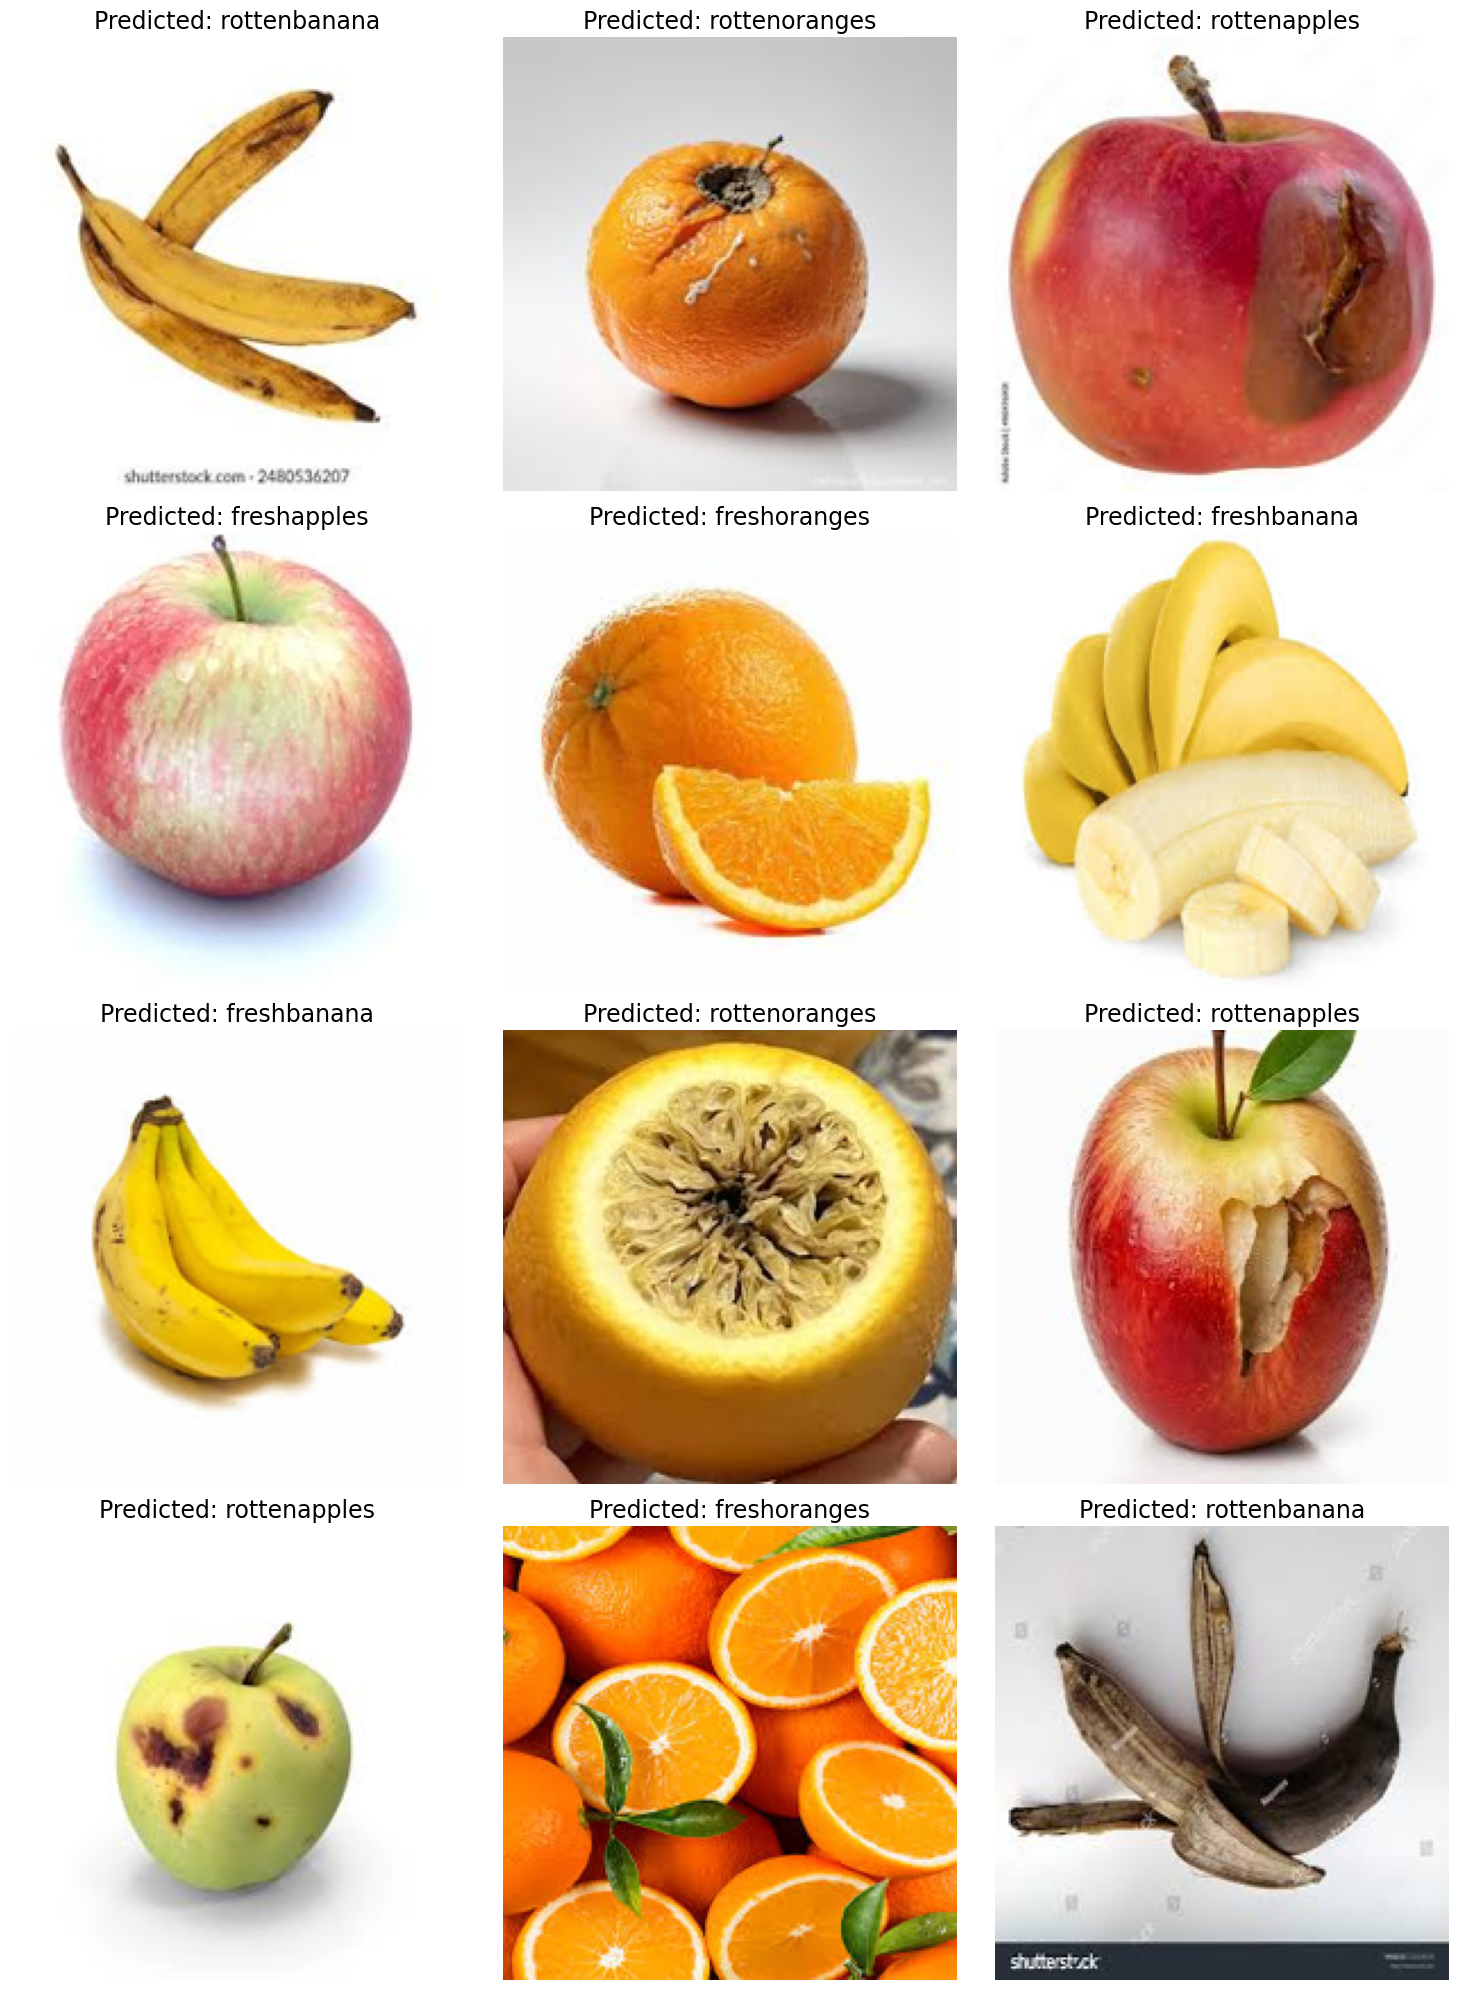

In [85]:
predict_and_visualize(images,model)


In [87]:
model.save('/kaggle/working/freshness_fruit.h5')

# 